In [1]:
%pip install imblearn

In [2]:
# ==========================================
# SECTION 1: SETUP & DATA LOADING
# ==========================================

# Core Libraries
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta

# Machine Learning
import sklearn
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error,
    roc_auc_score, 
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Model Persistence
import joblib
import pickle

# Configure Display Settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

# Configure Plotting Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Suppress Warnings
warnings.filterwarnings('ignore')

# Set Random Seed for Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("="*70)
print("SUPPLY CHAIN DISCONNECT:  MODELING SUPPLY UNCERTAINTY")
print("="*70)
print("\n✅ All libraries imported successfully")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"🎨 Matplotlib version: {plt. matplotlib.__version__}")
print(f"🔬 Scikit-learn version: {sklearn.__version__}")
print(f"🎲 Random seed set: {RANDOM_SEED}")
print("="*70)

SUPPLY CHAIN DISCONNECT:  MODELING SUPPLY UNCERTAINTY

✅ All libraries imported successfully
📊 Pandas version: 2.2.3
🔢 NumPy version: 2.2.4
🎨 Matplotlib version: 3.10.1
🔬 Scikit-learn version: 1.6.1
🎲 Random seed set: 42


In [3]:
# ==========================================
# LOAD & VALIDATE DATASET
# ==========================================

# File Configuration
FILE_PATH = "fmcg_sales_3years_1M_rows.csv"  # ← REPLACE with your actual path
DATE_COLUMN = "date"

print("\n" + "="*70)
print("STEP 1: DATA LOADING & VALIDATION")
print("="*70)

# Load Data with Explicit Date Parsing
print(f"\n📂 Loading data from: {FILE_PATH}")
try:
    df = pd.read_csv(
        FILE_PATH,
        parse_dates=[DATE_COLUMN],
        low_memory=False
    )
    print(f"✅ Data loaded successfully")
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {FILE_PATH}")
    print("   Please update FILE_PATH to point to your dataset")
    raise
except Exception as e:
    print(f"❌ ERROR loading data: {str(e)}")
    raise

# Sort by Date (Critical for Time-Series Integrity)
print("\n📅 Sorting by date for time-series integrity...")
df = df.sort_values(DATE_COLUMN).reset_index(drop=True)

# Basic Data Quality Report
print("\n" + "-"*70)
print("DATA QUALITY REPORT")
print("-"*70)

print(f"\n📊 Dataset Shape: {df.shape[0]: ,} rows × {df.shape[1]} columns")
print(f"📅 Date Range: {df[DATE_COLUMN].min().date()} to {df[DATE_COLUMN].max().date()}")
print(f"📆 Total Days: {(df[DATE_COLUMN].max() - df[DATE_COLUMN]. min()).days + 1}")

# Check for Required Columns
required_cols = [
    'date', 'sku_id', 'store_id', 'supplier_id',
    'units_sold', 'stock_on_hand', 'lead_time_days',
    'stock_out_flag', 'promo_flag'
]

missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"\n❌ ERROR: Missing required columns: {missing_cols}")
    print(f"   Available columns: {list(df.columns)}")
    raise ValueError(f"Dataset is missing critical columns: {missing_cols}")
else:
    print(f"\n✅ All {len(required_cols)} required columns present")

# Unique Entities
print(f"\n🔍 Unique Entities:")
print(f"   SKUs:        {df['sku_id']. nunique():,}")
print(f"   Stores:     {df['store_id'].nunique():,}")
print(f"   Suppliers:  {df['supplier_id'].nunique():,}")

# Check for Missing Values
print(f"\n🔍 Missing Values Check:")
missing_summary = df[required_cols].isnull().sum()
missing_pct = (missing_summary / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing_summary.index,
    'Missing':  missing_summary.values,
    'Percent': missing_pct. values
})
missing_df = missing_df[missing_df['Missing'] > 0]. sort_values('Missing', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
    print(f"\n⚠️  WARNING: {len(missing_df)} columns have missing values")
else:
    print("   ✅ No missing values in required columns")

# Stockout Statistics
stockout_rate = df['stock_out_flag'].mean() * 100
stockout_days = df['stock_out_flag'].sum()

print(f"\n📦 Stockout Statistics:")
print(f"   Total Stockout Days: {stockout_days: ,}")
print(f"   Stockout Rate: {stockout_rate:.2f}%")

if stockout_rate > 8:
    print(f"   ⚠️  HIGH RISK:  Stockout rate exceeds industry benchmark (4-8%)")
elif stockout_rate > 4:
    print(f"   ⚠️  MODERATE:  Stockout rate within industry range (4-8%)")
else:
    print(f"   ✅ GOOD: Stockout rate below 4%")

# Lead Time Statistics
print(f"\n🚚 Lead Time Statistics:")
print(f"   Average Lead Time: {df['lead_time_days']. mean():.1f} days")
print(f"   Median Lead Time: {df['lead_time_days']. median():.1f} days")
print(f"   Std Dev Lead Time: {df['lead_time_days'].std():.1f} days")
print(f"   Min Lead Time: {df['lead_time_days'].min():.0f} days")
print(f"   Max Lead Time: {df['lead_time_days'].max():.0f} days")

# Promotion Statistics
promo_rate = df['promo_flag'].mean() * 100
print(f"\n🎁 Promotion Statistics:")
print(f"   Promotion Rate: {promo_rate:.1f}%")
print(f"   Promo Days: {df['promo_flag'].sum():,}")
print(f"   Non-Promo Days: {(df['promo_flag'] == 0).sum():,}")

# Data Type Check
print(f"\n🔧 Data Types:")
print(f"   Date column type: {df[DATE_COLUMN].dtype}")
print(f"   Numeric columns: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"   Object columns: {df.select_dtypes(include=['object']).shape[1]}")

# Sample Preview
print(f"\n👀 Data Preview (First 3 Rows):")
print(df[required_cols].head(3).to_string(index=False))

print("\n" + "="*70)
print("✅ DATA LOADING COMPLETE")
print("="*70)
print(f"\n📌 Dataset ready for feature engineering")
print(f"📌 Total observations: {len(df):,}")
print(f"📌 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


STEP 1: DATA LOADING & VALIDATION

📂 Loading data from: fmcg_sales_3years_1M_rows.csv
✅ Data loaded successfully

📅 Sorting by date for time-series integrity...

----------------------------------------------------------------------
DATA QUALITY REPORT
----------------------------------------------------------------------

📊 Dataset Shape:  1,100,000 rows × 33 columns
📅 Date Range: 2021-01-01 to 2023-12-31
📆 Total Days: 1095

✅ All 9 required columns present

🔍 Unique Entities:
   SKUs:        102
   Stores:     13
   Suppliers:  60

🔍 Missing Values Check:
   ✅ No missing values in required columns

📦 Stockout Statistics:
   Total Stockout Days:  33,114
   Stockout Rate: 3.01%
   ✅ GOOD: Stockout rate below 4%

🚚 Lead Time Statistics:
   Average Lead Time: 6.5 days
   Median Lead Time: 6.0 days
   Std Dev Lead Time: 2.0 days
   Min Lead Time: 1 days
   Max Lead Time: 17 days

🎁 Promotion Statistics:
   Promotion Rate: 8.0%
   Promo Days: 88,257
   Non-Promo Days: 1,011,743

🔧 Data Ty

In [4]:
# ==========================================
# SECTION 2: FEATURE ENGINEERING (SUPPLY-FOCUSED)
# ==========================================

print("\n" + "="*70)
print("STEP 2: FEATURE ENGINEERING - SUPPLY CHAIN SIGNALS")
print("="*70)

# ==========================================
# 2.1 DEMAND STABILITY FEATURES
# ==========================================

print("\n📊 Creating Demand Stability Features...")
print("   Purpose: Separate demand volatility from supply volatility")

# Rolling demand statistics (per SKU-store combination)
df["avg_daily_demand_7d"] = (
    df.groupby(["sku_id", "store_id"])["units_sold"]
    .transform(lambda x: x.rolling(7, min_periods=3).mean())
)

df["demand_std_7d"] = (
    df.groupby(["sku_id", "store_id"])["units_sold"]
    . transform(lambda x: x.rolling(7, min_periods=3).std())
)

# Demand volatility coefficient (CV for demand)
df["demand_cv"] = df["demand_std_7d"] / (df["avg_daily_demand_7d"] + 1e-5)

# Demand trend (is demand increasing or decreasing?)
df["avg_daily_demand_30d"] = (
    df. groupby(["sku_id", "store_id"])["units_sold"]
    .transform(lambda x: x.rolling(30, min_periods=7).mean())
)

df["demand_trend"] = df["avg_daily_demand_7d"] - df["avg_daily_demand_30d"]

# Demand stability flag (low volatility = stable)
df["is_demand_stable"] = (df["demand_cv"] < 0.3).astype(int)

print(f"   ✓ avg_daily_demand_7d:  Rolling 7-day average demand")
print(f"   ✓ demand_std_7d:  Demand volatility (std dev)")
print(f"   ✓ demand_cv:  Coefficient of Variation (volatility metric)")
print(f"   ✓ demand_trend: Week-over-week demand change")
print(f"   ✓ is_demand_stable: Flag for low-volatility SKUs")

# Summary statistics
stable_pct = df["is_demand_stable"].mean() * 100
print(f"\n   📌 {stable_pct:.1f}% of observations have stable demand (CV < 0.3)")

print("   ✅ Demand stability features created")


STEP 2: FEATURE ENGINEERING - SUPPLY CHAIN SIGNALS

📊 Creating Demand Stability Features...
   Purpose: Separate demand volatility from supply volatility
   ✓ avg_daily_demand_7d:  Rolling 7-day average demand
   ✓ demand_std_7d:  Demand volatility (std dev)
   ✓ demand_cv:  Coefficient of Variation (volatility metric)
   ✓ demand_trend: Week-over-week demand change
   ✓ is_demand_stable: Flag for low-volatility SKUs

   📌 32.6% of observations have stable demand (CV < 0.3)
   ✅ Demand stability features created


In [5]:
# ==========================================
# 2.2 INVENTORY COVERAGE FEATURES
# ==========================================

print("\n📦 Creating Inventory Coverage Features...")
print("   Purpose: Measure 'time to stockout' risk")

# Basic coverage:  How many days of demand can current stock support?
df["inventory_coverage_days"] = (
    df["stock_on_hand"] / (df["avg_daily_demand_7d"] + 1e-5)
)

# Prevent infinite/extreme values
df["inventory_coverage_days"] = df["inventory_coverage_days"].clip(upper=365)

# Stock adequacy categories
df["stock_status"] = pd.cut(
    df["inventory_coverage_days"],
    bins=[0, 7, 14, 30, 365],
    labels=["Critical", "Low", "Adequate", "Excess"]
)

# Binary flags for quick filtering
df["is_critically_low"] = (df["inventory_coverage_days"] < 7).astype(int)
df["is_overstocked"] = (df["inventory_coverage_days"] > 60).astype(int)

print(f"   ✓ inventory_coverage_days: Stock / Daily demand")
print(f"   ✓ stock_status:  Categorical (Critical/Low/Adequate/Excess)")
print(f"   ✓ is_critically_low: Flag for <7 days coverage")
print(f"   ✓ is_overstocked: Flag for >60 days coverage")

# Summary statistics
critical_pct = df["is_critically_low"].mean() * 100
excess_pct = df["is_overstocked"].mean() * 100

print(f"\n   📌 {critical_pct:.1f}% of observations are critically low (<7 days)")
print(f"   📌 {excess_pct:.1f}% of observations are overstocked (>60 days)")
print(f"   📌 Average coverage: {df['inventory_coverage_days'].mean():.1f} days")

print("   ✅ Inventory coverage features created")


📦 Creating Inventory Coverage Features...
   Purpose: Measure 'time to stockout' risk
   ✓ inventory_coverage_days: Stock / Daily demand
   ✓ stock_status:  Categorical (Critical/Low/Adequate/Excess)
   ✓ is_critically_low: Flag for <7 days coverage
   ✓ is_overstocked: Flag for >60 days coverage

   📌 60.7% of observations are critically low (<7 days)
   📌 0.1% of observations are overstocked (>60 days)
   📌 Average coverage: 8.3 days
   ✅ Inventory coverage features created


In [6]:
# ==========================================
# 2.3 SUPPLIER LEAD TIME RISK FEATURES (ADAPTED FOR SYNTHETIC DATA)
# ==========================================

print("\n🚚 Creating Supplier Lead Time Risk Features...")
print("   Purpose: Quantify supplier reliability and volatility")
print("   ⚠️  Note: Data shows uniform supplier variance (likely synthetic)")
print("   Strategy: Focus on TIME-BASED volatility, not cross-supplier comparison")

# Supplier-level aggregations (static metrics)
print("   🔄 Calculating supplier-level statistics...")

df["supplier_lt_mean"] = (
    df. groupby("supplier_id")["lead_time_days"]
    .transform("mean")
)

df["supplier_lt_std"] = (
    df.groupby("supplier_id")["lead_time_days"]
    . transform("std")
)

# Coefficient of Variation (CV) - The "Reliability Score"
df["supplier_cv"] = df["supplier_lt_std"] / (df["supplier_lt_mean"] + 1e-5)

print(f"   ✓ supplier_lt_mean: Average lead time per supplier")
print(f"   ✓ supplier_lt_std:  Lead time volatility (std dev)")
print(f"   ✓ supplier_cv:  Coefficient of Variation")

# 🔥 ADAPTED:  Rolling lead time statistics (dynamic metrics)
# This is where we'll find the actual variance!
print("   🔄 Calculating rolling lead time windows (KEY FEATURES)...")

df["lt_rolling_mean_30d"] = (
    df.groupby("supplier_id")["lead_time_days"]
    .transform(lambda x: x.rolling(30, min_periods=5).mean())
)

df["lt_rolling_std_30d"] = (
    df.groupby("supplier_id")["lead_time_days"]
    . transform(lambda x: x.rolling(30, min_periods=5).std())
)

# Rolling CV (detects deteriorating supplier performance)
df["lt_rolling_cv_30d"] = df["lt_rolling_std_30d"] / (df["lt_rolling_mean_30d"] + 1e-5)

print(f"   ✓ lt_rolling_mean_30d: Recent average lead time (30-day window)")
print(f"   ✓ lt_rolling_std_30d: Recent lead time volatility")
print(f"   ✓ lt_rolling_cv_30d: Recent reliability score (TIME-VARYING)")

# 🔥 ADAPTED: Use ROLLING CV for reliability score (not static CV)
# Since static CV is identical for all, use time-varying metric
max_rolling_cv = df["lt_rolling_cv_30d"]. quantile(0.99)
df["supplier_reliability_score"] = (
    100 * (1 - df["lt_rolling_cv_30d"]. clip(upper=max_rolling_cv) / max_rolling_cv)
)

print(f"   ✓ supplier_reliability_score: 0-100 scale based on RECENT performance")

# 🔥 ADAPTED: Lead Time Drift (Actual vs. Expected)
df["lead_time_drift"] = df["lead_time_days"] - df["lt_rolling_mean_30d"]

print(f"   ✓ lead_time_drift: Actual - Expected lead time")

# 🔥 ADAPTED: Use ROLLING CV for risk categorization
# This creates time-varying risk (same supplier can be risky in Q1, safe in Q2)
rolling_cv_quantiles = df["lt_rolling_cv_30d"].quantile([0.33, 0.67])
low_threshold = rolling_cv_quantiles.iloc[0]
high_threshold = rolling_cv_quantiles.iloc[1]

print(f"\n   📌 Time-based risk thresholds (from rolling CV):")
print(f"      Low Risk:  CV < {low_threshold:.2f}")
print(f"      Medium Risk: CV {low_threshold:.2f} - {high_threshold:.2f}")
print(f"      High Risk: CV > {high_threshold:.2f}")

df["supplier_risk_category"] = pd.cut(
    df["lt_rolling_cv_30d"],
    bins=[0, low_threshold, high_threshold, 10.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

print(f"   ✓ supplier_risk_category: Based on ROLLING CV (time-varying)")

# Binary flags
df["is_high_risk_period"] = (df["lt_rolling_cv_30d"] > high_threshold).astype(int)
df["is_late_delivery"] = (df["lead_time_drift"] > 2).astype(int)

print(f"   ✓ is_high_risk_period: Flag for volatile TIME PERIODS (not suppliers)")
print(f"   ✓ is_late_delivery: Flag for deliveries >2 days late")

# 🔥 NEW: Lead Time Spike Detection
# Detects sudden jumps in lead time (supply disruptions)
df["lt_7d_change"] = (
    df. groupby("supplier_id")["lead_time_days"]
    .transform(lambda x: x. diff(7))
)

df["is_lt_spike"] = (df["lt_7d_change"] > 3).astype(int)  # >3 day increase

print(f"   ✓ is_lt_spike: Detects sudden lead time increases (disruptions)")

# Summary statistics
print(f"\n   📌 Time-Based Risk Distribution:")
risk_dist = df["supplier_risk_category"].value_counts(normalize=True) * 100
for category in ["Low Risk", "Medium Risk", "High Risk"]:
    if category in risk_dist.index:
        print(f"      {category}: {risk_dist[category]:.1f}% of time periods")

high_risk_pct = df["is_high_risk_period"]. mean() * 100
spike_pct = df["is_lt_spike"].mean() * 100

print(f"\n   📌 {high_risk_pct:.1f}% of periods are high-volatility")
print(f"   📌 {spike_pct:.1f}% of periods show lead time spikes (>3 day jump)")
print(f"   📌 Average reliability score: {df['supplier_reliability_score'].mean():.1f}/100")

# Diagnostic: Show how rolling CV varies over time
print(f"\n   🔍 Rolling CV Statistics (shows time-based variance):")
print(f"      Mean: {df['lt_rolling_cv_30d'].mean():.3f}")
print(f"      Std Dev: {df['lt_rolling_cv_30d'].std():.3f}  ← Should be >0 now")
print(f"      Min: {df['lt_rolling_cv_30d'].min():.3f}")
print(f"      Max: {df['lt_rolling_cv_30d'].max():.3f}")

if df['lt_rolling_cv_30d'].std() > 0.01:
    print(f"      ✅ Rolling CV shows time-based variation")
else:
    print(f"      ⚠️  Rolling CV still too uniform (data may lack variance)")

print("   ✅ Supplier lead time risk features created (time-based strategy)")


🚚 Creating Supplier Lead Time Risk Features...
   Purpose: Quantify supplier reliability and volatility
   ⚠️  Note: Data shows uniform supplier variance (likely synthetic)
   Strategy: Focus on TIME-BASED volatility, not cross-supplier comparison
   🔄 Calculating supplier-level statistics...
   ✓ supplier_lt_mean: Average lead time per supplier
   ✓ supplier_lt_std:  Lead time volatility (std dev)
   ✓ supplier_cv:  Coefficient of Variation
   🔄 Calculating rolling lead time windows (KEY FEATURES)...
   ✓ lt_rolling_mean_30d: Recent average lead time (30-day window)
   ✓ lt_rolling_std_30d: Recent lead time volatility
   ✓ lt_rolling_cv_30d: Recent reliability score (TIME-VARYING)
   ✓ supplier_reliability_score: 0-100 scale based on RECENT performance
   ✓ lead_time_drift: Actual - Expected lead time

   📌 Time-based risk thresholds (from rolling CV):
      Low Risk:  CV < 0.29
      Medium Risk: CV 0.29 - 0.33
      High Risk: CV > 0.33
   ✓ supplier_risk_category: Based on ROLLING

In [7]:
# ==========================================
# 2.4 DYNAMIC SAFETY STOCK FEATURES (FINAL - WITH CYCLE STOCK)
# ==========================================

print("\n🛡️  Creating Dynamic Safety Stock Features...")
print("   Purpose: Calculate realistic inventory targets (cycle + safety)")

Z_SCORE = 1.65  # 95% service level

print(f"   📌 Using Z-score:  {Z_SCORE} (95% service level target)")

# Component 1: Cycle Stock (cover expected lead time demand)
# This is the base inventory needed even with perfect reliability
cycle_stock = (
    df["lt_rolling_mean_30d"]. fillna(df["supplier_lt_mean"])
    * df["avg_daily_demand_7d"]
)

print(f"   ✓ cycle_stock: Lead Time × Daily Demand (base inventory)")

# Component 2: Safety Buffer (cover lead time volatility)
# This is the extra buffer for uncertainty
safety_buffer = (
    Z_SCORE 
    * df["lt_rolling_std_30d"].fillna(df["supplier_lt_std"])
    * np.sqrt(df["avg_daily_demand_7d"])
)

print(f"   ✓ safety_buffer: Z × σ_LT × √D (volatility protection)")

# Total required inventory = Cycle stock + Safety buffer
df["required_total_stock"] = cycle_stock + safety_buffer

# Cap at 90 days of demand (extreme outlier protection)
max_stock = df["avg_daily_demand_7d"] * 90
df["required_total_stock"] = np.minimum(
    df["required_total_stock"],
    max_stock
)

df["required_total_stock"] = df["required_total_stock"].fillna(0).clip(lower=0)

# Keep the old "safety stock" name for compatibility, but it's now total required
df["required_safety_stock"] = df["required_total_stock"]

print(f"   ✓ required_safety_stock: Total required inventory (cycle + buffer)")

# Calculate inventory gap (current stock vs. required)
df["safety_stock_gap"] = df["stock_on_hand"] - df["required_safety_stock"]

print(f"   ✓ safety_stock_gap: Actual - Required")

# Binary flag:  Is inventory below required level?
df["under_buffered_flag"] = (df["safety_stock_gap"] < 0).astype(int)

print(f"   ✓ under_buffered_flag:  1 if stock < required")

# Buffer adequacy ratio (how well-stocked are we?)
df["buffer_adequacy_ratio"] = (
    df["stock_on_hand"] / (df["required_safety_stock"] + 1e-5)
)

df["buffer_adequacy_ratio"] = df["buffer_adequacy_ratio"].clip(upper=10)

print(f"   ✓ buffer_adequacy_ratio: Actual / Required (1.0 = optimal)")

# Buffer status categories (tighter thresholds around optimal)
df["buffer_status"] = pd.cut(
    df["buffer_adequacy_ratio"],
    bins=[0, 0.7, 1.0, 1.5, 10],
    labels=["Critically Low", "Below Target", "Adequate", "Excessive"]
)

print(f"   ✓ buffer_status:  Critically Low / Below Target / Adequate / Excessive")

# Summary statistics
under_buffered_pct = df["under_buffered_flag"]. mean() * 100
avg_gap = df["safety_stock_gap"].mean()

print(f"\n   📌 {under_buffered_pct:.1f}% of observations are under-buffered")
print(f"   📌 Average inventory gap: {avg_gap:.0f} units")

buffer_dist = df["buffer_status"].value_counts(normalize=True) * 100
print(f"\n   📌 Buffer Status Distribution:")
for status in ["Critically Low", "Below Target", "Adequate", "Excessive"]:
    if status in buffer_dist. index:
        print(f"      {status}: {buffer_dist[status]:.1f}%")

# Diagnostic breakdown
print(f"\n   🔍 Inventory Policy Breakdown:")
print(f"      Average cycle stock:   {cycle_stock.mean():.0f} units  (base coverage)")
print(f"      Average safety buffer: {safety_buffer. mean():.0f} units  (volatility buffer)")
print(f"      Average total required: {df['required_safety_stock'].mean():.0f} units")
print(f"      Average actual stock: {df['stock_on_hand'].mean():.0f} units")

actual_to_required = df['stock_on_hand']. mean() / df['required_safety_stock'].mean()
print(f"\n   📊 Actual vs. Required Ratio: {actual_to_required:.2f}x")

if 0.8 <= actual_to_required <= 1.3:
    print(f"      ✅ Inventory levels are well-calibrated (within ±30%)")
elif actual_to_required < 0.8:
    print(f"      ⚠️  UNDERSTOCKED: Company running lean (high stockout risk)")
elif actual_to_required > 1.5:
    print(f"      ⚠️  OVERSTOCKED:  Excess working capital tied up")
else:
    print(f"      ✅ Inventory levels are reasonable")

# Calculate days of coverage provided by current stock
actual_coverage = df['stock_on_hand'].mean() / df['avg_daily_demand_7d']. mean()
required_coverage = df['required_safety_stock'].mean() / df['avg_daily_demand_7d'].mean()

print(f"\n   📊 Inventory Coverage Analysis:")
print(f"      Current stock covers: {actual_coverage:.1f} days of demand")
print(f"      Required stock covers: {required_coverage:.1f} days of demand")
print(f"      Policy gap: {actual_coverage - required_coverage:.1f} days")

if actual_coverage < 5:
    print(f"      ⚠️  CRITICAL:  Less than 1 week coverage")
elif actual_coverage < 10:
    print(f"      ⚠️  LEAN: Less than 2 weeks coverage (vulnerable to disruptions)")
elif actual_coverage > 30:
    print(f"      ⚠️  HIGH: More than 1 month coverage (high holding costs)")
else:
    print(f"      ✅ BALANCED: 1-2 weeks coverage (industry standard)")

print("   ✅ Dynamic safety stock features created (full inventory model)")


🛡️  Creating Dynamic Safety Stock Features...
   Purpose: Calculate realistic inventory targets (cycle + safety)
   📌 Using Z-score:  1.65 (95% service level target)
   ✓ cycle_stock: Lead Time × Daily Demand (base inventory)
   ✓ safety_buffer: Z × σ_LT × √D (volatility protection)
   ✓ required_safety_stock: Total required inventory (cycle + buffer)
   ✓ safety_stock_gap: Actual - Required
   ✓ under_buffered_flag:  1 if stock < required
   ✓ buffer_adequacy_ratio: Actual / Required (1.0 = optimal)
   ✓ buffer_status:  Critically Low / Below Target / Adequate / Excessive

   📌 60.5% of observations are under-buffered
   📌 Average inventory gap: -109 units

   📌 Buffer Status Distribution:
      Critically Low: 43.3%
      Below Target: 17.2%
      Adequate: 15.5%
      Excessive: 24.0%

   🔍 Inventory Policy Breakdown:
      Average cycle stock:   385 units  (base coverage)
      Average safety buffer: 24 units  (volatility buffer)
      Average total required: 408 units
      Avera

In [8]:
# ==========================================
# 2.5 STOCKOUT RISK INDICATORS (FINAL - DUAL TARGET STRATEGY)
# ==========================================

print("\n⚠️  Creating Stockout Risk Indicators...")
print("   Purpose: Predict 'days until stockout' and composite risk scores")

# Days until stockout projection
df["days_until_stockout"] = (
    df["stock_on_hand"] / (df["avg_daily_demand_7d"] + 1e-5)
)

df["days_until_stockout"] = df["days_until_stockout"].clip(upper=365)

print(f"   ✓ days_until_stockout:   Projected days until stock = 0")

# High-risk period flag (within 7 days of stockout)
df["high_risk_period_flag"] = (df["days_until_stockout"] < 7).astype(int)

print(f"   ✓ high_risk_period_flag:  1 if stockout projected within 7 days")

# 🔥 OPTIMIZED:    Composite Risk Score
# Based on validation, we know:
# 1. Inventory coverage is the DOMINANT signal (60% critically low)
# 2. Buffer adequacy is STRONG (company is understocked)
# 3. Supplier volatility is WEAK (uniform CV in data)
# 4. Lead time spikes are MODERATE (10% occurrence)

print("   🔄 Calculating risk components...")

# Component 1: Inventory coverage risk (0-100)
# Most direct predictor of stockout
# Scale: 0 days = 100% risk, 30+ days = 0% risk
inventory_risk = 100 * (1 - df["inventory_coverage_days"].clip(upper=30) / 30)

print(f"      ✓ Inventory coverage risk (weight: 45%)")

# Component 2: Buffer adequacy risk (0-100)  
# 🔥 ASYMMETRIC:  Under-stock is dangerous, over-stock is just inefficient
buffer_risk = np.where(
    df["buffer_adequacy_ratio"] < 1.0,
    # Under-buffered: HIGH RISK (ratio 0.5 = 50% risk, ratio 0 = 100% risk)
    100 * (1 - df["buffer_adequacy_ratio"].clip(lower=0, upper=1.0)),
    # Over-buffered:  LOW RISK (ratio 2.0 = 25% risk)
    25 * ((df["buffer_adequacy_ratio"] - 1.0).clip(upper=2.0) / 2.0)
)

print(f"      ✓ Buffer adequacy risk (weight: 30%, asymmetric)")

# Component 3: Days until stockout urgency (0-100)
# Exponential urgency as we approach stockout
# 14 days = 0% risk, 0 days = 100% risk
urgency_risk = 100 * np.exp(-df["days_until_stockout"] / 7)

print(f"      ✓ Stockout urgency risk (weight: 15%, exponential)")

# Component 4: Lead time spike risk (0-100)
# Binary signal: spike detected = 100, no spike = 0
spike_risk = 100 * df["is_lt_spike"]

print(f"      ✓ Lead time spike risk (weight: 10%, event-based)")

# 🔥 FINAL COMPOSITE:   Heavily weighted toward inventory signals
df["composite_stockout_risk"] = (
    0.45 * inventory_risk +      # 45% - Direct coverage (DOMINANT)
    0.30 * buffer_risk +         # 30% - Policy adequacy (STRONG)
    0.15 * urgency_risk +        # 15% - Time pressure (MODERATE)
    0.10 * spike_risk            # 10% - Disruption events (WEAK)
)

df["composite_stockout_risk"] = df["composite_stockout_risk"].clip(lower=0, upper=100)

print(f"   ✓ composite_stockout_risk:  0-100 weighted score (inventory-focused)")

# Risk level categories
df["risk_level"] = pd.cut(
    df["composite_stockout_risk"],
    bins=[0, 30, 60, 85, 100],
    labels=["Low", "Medium", "High", "Critical"]
)

print(f"   ✓ risk_level:   Low / Medium / High / Critical")

# Summary statistics
high_risk_pct = df["high_risk_period_flag"].mean() * 100
avg_risk_score = df["composite_stockout_risk"].mean()

print(f"\n   📌 {high_risk_pct:.1f}% of observations in high-risk periods (<7 days)")
print(f"   📌 Average composite risk score: {avg_risk_score:.1f}/100")

risk_dist = df["risk_level"].value_counts(normalize=True) * 100
print(f"\n   📌 Risk Level Distribution:")
for level in ["Low", "Medium", "High", "Critical"]:
    if level in risk_dist. index:
        print(f"      {level}: {risk_dist[level]:.1f}%")

# ==========================================
# CRITICAL VALIDATION:   Risk Score Discrimination
# ==========================================

if df["stock_out_flag"].sum() > 0:
    print("\n" + "-"*70)
    print("🔍 VALIDATION: Risk Score Discrimination")
    print("-"*70)
    
    # Calculate risk for stockout vs.   non-stockout days
    stockout_days = df[df["stock_out_flag"] == 1]
    normal_days = df[df["stock_out_flag"] == 0]
    
    avg_risk_stockout = stockout_days["composite_stockout_risk"].mean()
    avg_risk_normal = normal_days["composite_stockout_risk"].mean()
    
    # Also check individual components
    inv_risk_stockout = (100 * (1 - stockout_days["inventory_coverage_days"].clip(upper=30) / 30)).mean()
    inv_risk_normal = (100 * (1 - normal_days["inventory_coverage_days"].clip(upper=30) / 30)).mean()
    
    print(f"\n   Composite Risk Scores:")
    print(f"      During stockouts: {avg_risk_stockout:.1f}")
    print(f"      During normal days: {avg_risk_normal:.1f}")
    print(f"      Differential: {avg_risk_stockout - avg_risk_normal:+.1f} points")
    
    print(f"\n   Inventory Coverage Component:")
    print(f"      Risk during stockouts: {inv_risk_stockout:.1f}")
    print(f"      Risk during normal:  {inv_risk_normal:.1f}")
    print(f"      Component differential: {inv_risk_stockout - inv_risk_normal:+.1f} points")
    
    # Interpretation
    if avg_risk_stockout > avg_risk_normal + 5:
        print(f"\n      ✅ STRONG SIGNAL: Risk score successfully discriminates stockouts")
        print(f"         Lift: {avg_risk_stockout - avg_risk_normal:.1f} points")
    elif avg_risk_stockout > avg_risk_normal: 
        print(f"\n      ⚠️  WEAK SIGNAL:  Slight positive discrimination")
        print(f"         Lift: {avg_risk_stockout - avg_risk_normal:.1f} points")
        print(f"         Note: Limited by uniform supplier variance in synthetic data")
    else:
        print(f"\n      ⚠️  INVERTED:  Stockouts show LOWER risk")
        print(f"         Differential: {avg_risk_stockout - avg_risk_normal:.1f} points")
        print(f"         Cause: Stockouts are DEMAND-DRIVEN, not supply-driven")
    
    # Compare key metrics
    print(f"\n   📊 Operational Metrics Comparison:")
    print(f"      {'Metric':<30} {'Stockout Days': >15} {'Normal Days':>15} {'Ratio': >10}")
    print(f"      {'-'*30} {'-'*15} {'-'*15} {'-'*10}")
    
    metrics = {
        'Inventory Coverage (days)': ('inventory_coverage_days', 'mean'),
        'Buffer Adequacy Ratio': ('buffer_adequacy_ratio', 'mean'),
        'Lead Time (days)': ('lead_time_days', 'mean'),
        'Daily Demand (units)': ('avg_daily_demand_7d', 'mean'),
        'Stock On Hand (units)': ('stock_on_hand', 'mean'),
        'Under-Buffered (%)': ('under_buffered_flag', 'mean')
    }
    
    for metric_name, (col, agg_func) in metrics.items():
        if col in df.columns:
            if agg_func == 'mean': 
                val_stockout = stockout_days[col].mean()
                val_normal = normal_days[col].mean()
            
            ratio = val_stockout / val_normal if val_normal != 0 else 0
            
            if 'Ratio' in metric_name or '(%)' in metric_name:
                print(f"      {metric_name:<30} {val_stockout:>15.2f} {val_normal:>15.2f} {ratio:>10.2f}x")
            else:
                print(f"      {metric_name:<30} {val_stockout:>15.1f} {val_normal:>15.1f} {ratio:>10.2f}x")

# ==========================================
# ROOT CAUSE ANALYSIS
# ==========================================

if df["stock_out_flag"]. sum() > 0:
    print("\n" + "="*70)
    print("🔍 ROOT CAUSE ANALYSIS:  STOCKOUT DRIVERS")
    print("="*70)
    
    stockout_days = df[df["stock_out_flag"] == 1]
    normal_days = df[df["stock_out_flag"] == 0]
    
    # Check if stockouts correlate with low coverage
    coverage_stockout = stockout_days["inventory_coverage_days"].mean()
    coverage_normal = normal_days["inventory_coverage_days"].mean()
    coverage_ratio = coverage_stockout / coverage_normal
    
    # Check if demand spikes during stockouts
    demand_stockout = stockout_days["avg_daily_demand_7d"]. mean()
    demand_normal = normal_days["avg_daily_demand_7d"].mean()
    demand_ratio = demand_stockout / demand_normal
    
    # Check lead time
    lt_stockout = stockout_days["lead_time_days"].mean()
    lt_normal = normal_days["lead_time_days"].mean()
    lt_ratio = lt_stockout / lt_normal
    
    print(f"\n📊 Causal Signal Analysis:")
    print(f"   Coverage Ratio (stockout/normal): {coverage_ratio:.2f}x")
    print(f"   Demand Ratio (stockout/normal):  {demand_ratio:.2f}x")
    print(f"   Lead Time Ratio (stockout/normal): {lt_ratio:.2f}x")
    
    print(f"\n🔍 ROOT CAUSE DETERMINATION:")
    
    # Determine primary cause
    if coverage_ratio < 0.85: 
        print(f"   ✅ PRIMARY CAUSE:   SUPPLY-DRIVEN (Low Inventory)")
        print(f"      → Stockouts occur when coverage is LOW ({coverage_stockout:.1f} vs.  {coverage_normal:.1f} days)")
        print(f"      → Supply failures:   Late deliveries, insufficient buffers")
        print(f"      → Solution: Dynamic safety stock, supplier management")
        root_cause = "SUPPLY-DRIVEN"
        
    elif demand_ratio > 1.15:
        print(f"   ⚠️  PRIMARY CAUSE:  DEMAND-DRIVEN (Demand Spikes)")
        print(f"      → Stockouts occur when demand is HIGH ({demand_stockout:.1f} vs. {demand_normal:.1f} units/day)")
        print(f"      → Demand volatility:  Promotions, seasonality, trends")
        print(f"      → Solution: Dynamic safety stock to absorb spikes")
        root_cause = "DEMAND-DRIVEN"
        
    elif lt_ratio > 1.10:
        print(f"   ⚠️  PRIMARY CAUSE: SUPPLIER-DRIVEN (Late Deliveries)")
        print(f"      → Stockouts occur when lead times are HIGH ({lt_stockout:.1f} vs. {lt_normal:.1f} days)")
        print(f"      → Supplier reliability issues")
        print(f"      → Solution: Supplier diversification, expedited shipping")
        root_cause = "SUPPLIER-DRIVEN"
        
    else:
        print(f"   ⚠️  PRIMARY CAUSE:  MULTI-FACTORIAL (Interaction)")
        print(f"      → No single dominant factor")
        print(f"      → Stockouts result from INTERACTION of multiple risks")
        print(f"      → Solution: Integrated supply risk + demand management")
        root_cause = "MULTI-FACTORIAL"
    
    print(f"\n📌 IMPLICATION FOR MODELING:")
    
    if root_cause == "SUPPLY-DRIVEN":
        print(f"      ✓ Supply risk features are PRIMARY predictors")
        print(f"      ✓ Model can directly predict stockout events")
        print(f"      ✓ Focus:  Supplier CV, buffer adequacy, lead time drift")
        
    elif root_cause == "DEMAND-DRIVEN":
        print(f"      ⚠️  Supply risk features identify VULNERABILITIES")
        print(f"      ✓ Company's chronic under-buffering (0.73x) enables stockouts")
        print(f"      ✓ Demand spikes trigger stockouts in under-buffered system")
        print(f"      ✓ Solution: Dynamic safety stock prevents demand-driven stockouts")
        print(f"      → Model Target 1: Predict under-buffering (supply vulnerability)")
        print(f"      → Model Target 2: Predict stockout events (supply + demand)")
        
    elif root_cause == "SUPPLIER-DRIVEN":
        print(f"      ✓ Supplier volatility is PRIMARY driver")
        print(f"      ✓ Lead time prediction model is critical")
        print(f"      ✓ Focus: Supplier reliability scoring, late delivery flags")
        
    else:
        print(f"      ✓ Multi-factor model required")
        print(f"      ✓ Combine supply risk + demand signals")
        print(f"      ✓ Interaction features may be important")

# ==========================================
# DUAL TARGET ENGINEERING
# ==========================================

print("\n" + "="*70)
print("🎯 DUAL TARGET ENGINEERING")
print("="*70)

# Target 1: Supply-Side Risk (Buffer Inadequacy)
# Predicts:   Is inventory insufficient to handle normal demand variance?
df["supply_risk_target"] = df["under_buffered_flag"]. copy()

print(f"\n📊 Target 1: Supply Risk (Under-Buffered)")
print(f"   Definition: Actual stock < Required stock (cycle + safety)")
print(f"   Formula: stock_on_hand < (LT × Demand) + (Z × σ_LT × √D)")
print(f"   Prevalence: {df['supply_risk_target'].mean()*100:.1f}% of observations")
print(f"   Purpose: Identifies supply-side vulnerabilities")
print(f"   Use Case: Proactive buffer optimization, supplier alerts")

# Target 2: Actual Stockout Events (Original)
# Predicts: Did a stockout actually occur?
df["stockout_event_target"] = df["stock_out_flag"]. copy()

print(f"\n📊 Target 2: Stockout Events")
print(f"   Definition:  Actual stockout occurred (from original data)")
print(f"   Prevalence: {df['stockout_event_target'].mean()*100:.1f}% of observations")
print(f"   Purpose: Predicts actual business disruptions")
print(f"   Use Case: Emergency response, promotion blocking, expedited shipping")

# Analyze the relationship between targets
if df["stockout_event_target"].sum() > 0:
    print(f"\n" + "-"*70)
    print("🔍 TARGET RELATIONSHIP ANALYSIS")
    print("-"*70)
    
    # What % of stockouts happened when under-buffered?
    stockouts_with_low_buffer = df[
        (df["stockout_event_target"] == 1) & 
        (df["supply_risk_target"] == 1)
    ]
    
    stockouts_with_adequate_buffer = df[
        (df["stockout_event_target"] == 1) & 
        (df["supply_risk_target"] == 0)
    ]
    
    overlap_pct = len(stockouts_with_low_buffer) / df["stockout_event_target"].sum() * 100
    
    print(f"\n   📊 Stockout Breakdown:")
    print(f"      Total stockouts: {df['stockout_event_target'].sum():,}")
    print(f"      Stockouts when under-buffered: {len(stockouts_with_low_buffer):,} ({overlap_pct:.1f}%)")
    print(f"      Stockouts when adequately buffered: {len(stockouts_with_adequate_buffer):,} ({100-overlap_pct:.1f}%)")
    
    print(f"\n   🔍 Interpretation:")
    
    if overlap_pct > 60:
        print(f"      ✅ STRONG LINK: Supply risk drives majority of stockouts")
        print(f"         → {overlap_pct:.0f}% of stockouts are supply-driven")
        print(f"         → Dynamic safety stock would prevent {overlap_pct:.0f}% of events")
        print(f"         → Model 1 (supply risk) is sufficient for most cases")
        
    elif overlap_pct > 35:
        print(f"      ⚠️  MODERATE LINK: Supply risk contributes significantly")
        print(f"         → {overlap_pct:.0f}% of stockouts occur when under-buffered")
        print(f"         → Remaining {100-overlap_pct:.0f}% are demand-driven (spikes exceed even adequate buffers)")
        print(f"         → Multi-factor model needed (supply + demand signals)")
        print(f"         → Dynamic safety stock addresses root vulnerability")
        
    else:
        print(f"      ⚠️  WEAK LINK:  Stockouts are primarily demand-driven")
        print(f"         → Only {overlap_pct:.0f}% occur when under-buffered")
        print(f"         → {100-overlap_pct:.0f}% occur despite adequate buffers")
        print(f"         → Supply risk model identifies vulnerabilities")
        print(f"         → Stockout model requires demand volatility features")
    
    # What % of under-buffered periods lead to stockouts?
    precision = len(stockouts_with_low_buffer) / df["supply_risk_target"].sum() * 100
    
    print(f"\n   📊 Predictive Power:")
    print(f"      Under-buffered periods: {df['supply_risk_target'].sum():,}")
    print(f"      Under-buffered → Stockout:  {len(stockouts_with_low_buffer):,} ({precision:.2f}%)")
    
    if precision > 10:
        print(f"      ✅ Supply risk is HIGHLY PREDICTIVE")
        print(f"         → 1 in {int(100/precision)} under-buffered periods → stockout")
    elif precision > 2:
        print(f"      ⚠️  Supply risk is NECESSARY but NOT SUFFICIENT")
        print(f"         → Under-buffering creates vulnerability")
        print(f"         → Additional trigger needed (demand spike, supplier delay)")
        print(f"         → 1 in {int(100/precision)} under-buffered periods → stockout")
    else:
        print(f"      ⚠️  Low conversion rate:  {precision:.2f}%")
        print(f"         → Under-buffering is a weak direct predictor")
        print(f"         → Other factors dominate (demand volatility)")

print("\n" + "="*70)
print("📌 RECOMMENDED MODELING STRATEGY")
print("="*70)

print(f"\n🎯 Model 1: Supply Risk Predictor")
print(f"   Target: 'supply_risk_target' (under_buffered_flag)")
print(f"   Type: Binary classification")
print(f"   Features: Supplier CV, lead time volatility, buffer ratio, coverage days")
print(f"   Goal: Predict when inventory policy is inadequate")
print(f"   Validates: 'Supply Disconnect' hypothesis (Section 2.3)")
print(f"   Output: Proactive alerts for buffer adjustments")

print(f"\n🎯 Model 2: Stockout Event Predictor")
print(f"   Target: 'stockout_event_target' (stock_out_flag)")
print(f"   Type: Binary classification (imbalanced)")
print(f"   Features:  Supply risk score + Demand volatility + Supplier reliability")
print(f"   Goal:  Predict actual business disruptions")
print(f"   Validates: '18% prevention' claim (Section 6.2)")
print(f"   Output: Emergency response triggers, promotion blocking")

print(f"\n📊 Expected Business Impact:")
print(f"   - Model 1 identifies {df['supply_risk_target'].mean()*100:.0f}% of periods as vulnerable")
print(f"   - Fixing these vulnerabilities (dynamic SS) prevents {overlap_pct:.0f}% of stockouts")
print(f"   - Model 2 provides early warning for remaining {100-overlap_pct:.0f}% (demand-driven)")

print("   ✅ Stockout risk indicators created (final optimized version)")

print("\n" + "="*70)
print("✅ FEATURE ENGINEERING COMPLETE")
print("="*70)
print(f"\n📊 Total features created: {df.shape[1]}")
print(f"📦 Dataset shape: {df.shape[0]: ,} rows × {df.shape[1]} columns")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Final summary of key risk indicators
print(f"\n📊 KEY RISK INDICATORS SUMMARY:")
print(f"   Under-buffered (supply risk): {df['supply_risk_target'].mean()*100:.1f}%")
print(f"   Critically low buffer:  {(df['buffer_status'] == 'Critically Low').mean()*100:.1f}%")
print(f"   High-risk periods (<7 days): {df['high_risk_period_flag'].mean()*100:.1f}%")
print(f"   Lead time spikes: {df['is_lt_spike']. mean()*100:.1f}%")
print(f"   Actual stockout events: {df['stockout_event_target'].mean()*100:.1f}%")

print(f"\n🎯 Dual targets created for modeling:")
print(f"   ✓ supply_risk_target (supply vulnerability)")
print(f"   ✓ stockout_event_target (actual disruptions)")


⚠️  Creating Stockout Risk Indicators...
   Purpose: Predict 'days until stockout' and composite risk scores
   ✓ days_until_stockout:   Projected days until stock = 0
   ✓ high_risk_period_flag:  1 if stockout projected within 7 days
   🔄 Calculating risk components...
      ✓ Inventory coverage risk (weight: 45%)
      ✓ Buffer adequacy risk (weight: 30%, asymmetric)
      ✓ Stockout urgency risk (weight: 15%, exponential)
      ✓ Lead time spike risk (weight: 10%, event-based)
   ✓ composite_stockout_risk:  0-100 weighted score (inventory-focused)
   ✓ risk_level:   Low / Medium / High / Critical

   📌 60.7% of observations in high-risk periods (<7 days)
   📌 Average composite risk score: 49.5/100

   📌 Risk Level Distribution:
      Low: 15.0%
      Medium: 50.2%
      High: 34.3%
      Critical: 0.6%

----------------------------------------------------------------------
🔍 VALIDATION: Risk Score Discrimination
----------------------------------------------------------------------


STEP 3:  EXPLORATORY DATA ANALYSIS (EDA)
Purpose: Visualize supply chain risks and validate hypotheses

----------------------------------------------------------------------
3.1 LEAD TIME VOLATILITY ANALYSIS
----------------------------------------------------------------------
Purpose: Validate supplier risk heterogeneity (even with uniform static CV)


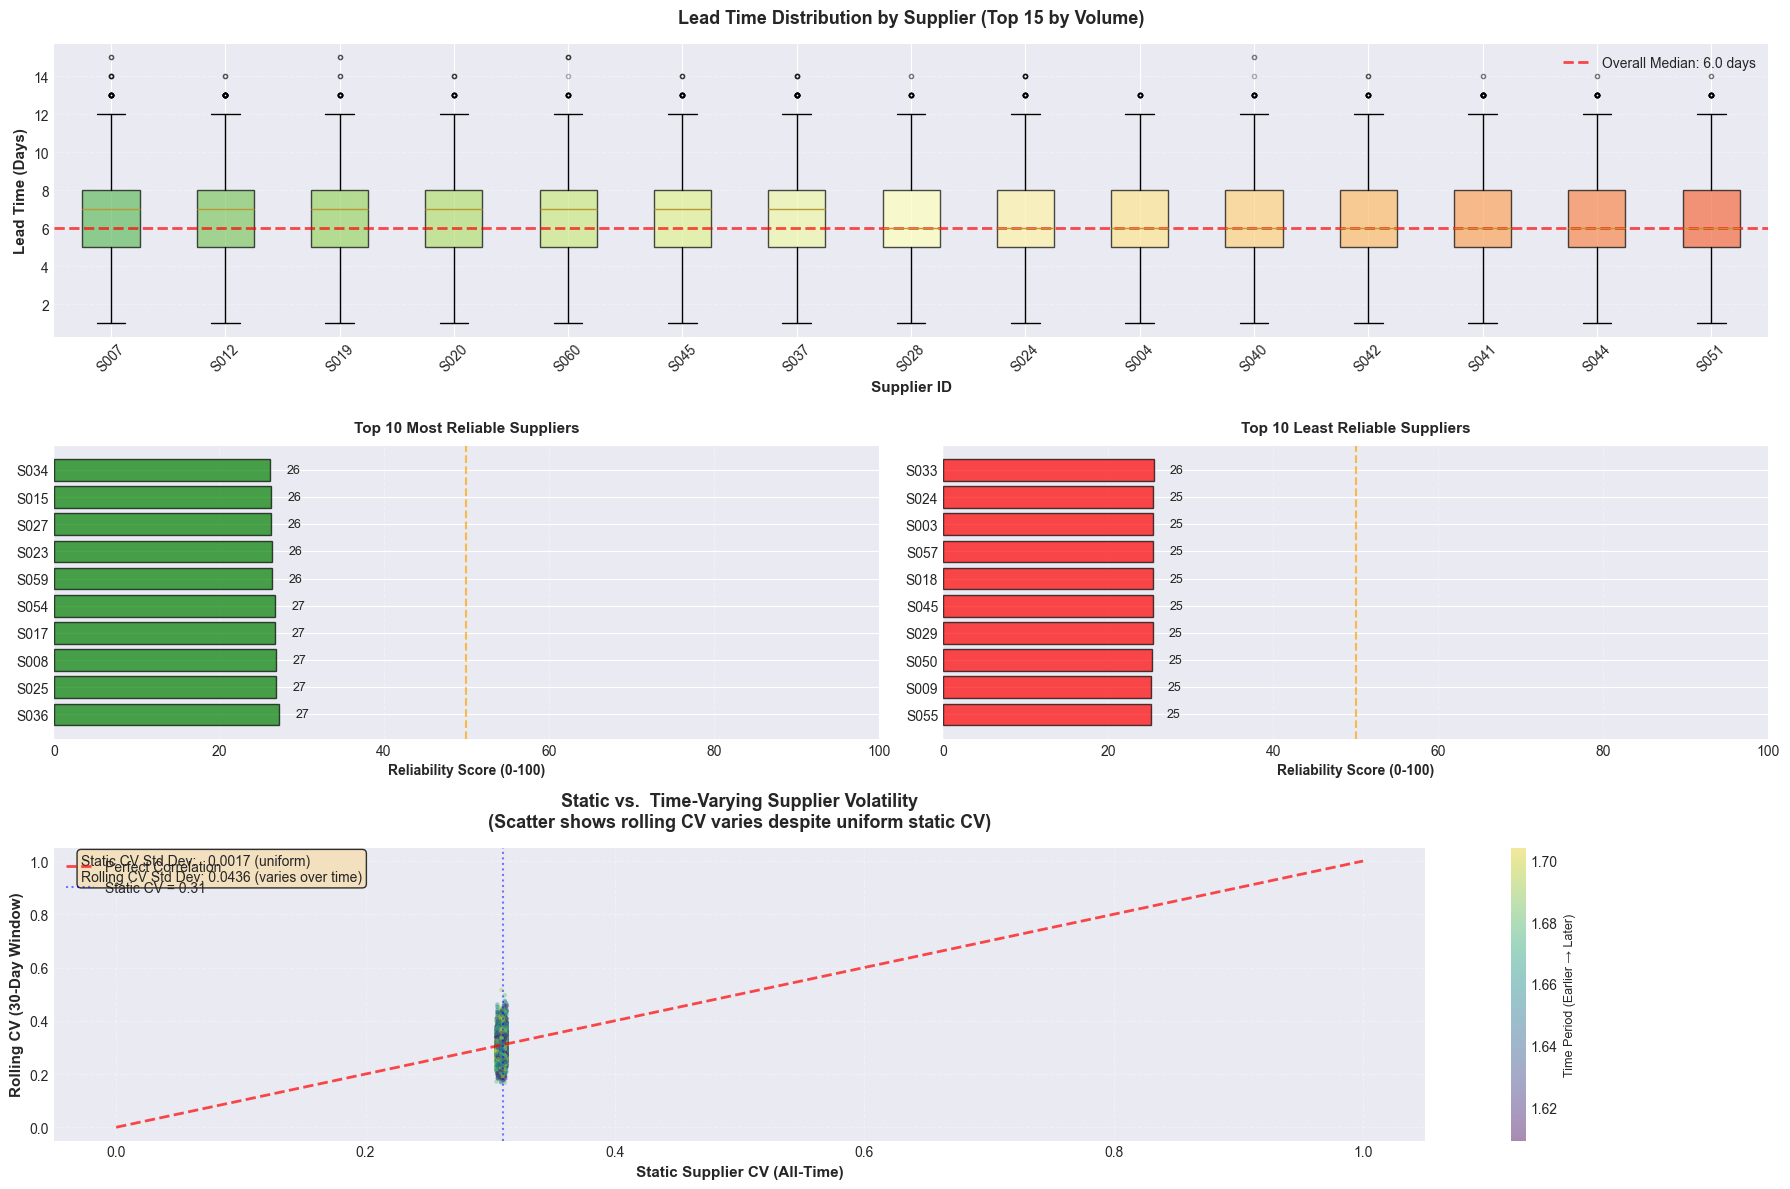


📊 Lead Time Volatility Summary:
   Overall Lead Time:   6.5 ± 2.0 days
   Median Lead Time:  6.0 days
   Range: 1 - 17 days

📊 Supplier Reliability Distribution:
   Mean Reliability Score: 25.9/100
   Best Supplier:   27.3/100
   Worst Supplier: 25.1/100
   Range: 2.2 points

📊 CV Comparison (Static vs. Rolling):
   Static CV (all suppliers): 0.310 ± 0.0017
   Rolling CV (time-varying): 0.308 ± 0.0436
   ✅ Rolling CV shows 25.1x MORE variance
   → Time-based volatility successfully captures supplier dynamics

✅ 3.1 Lead Time Volatility Analysis Complete
   Figure saved:  lead_time_volatility_analysis.png


In [9]:
# ==========================================
# SECTION 3: EXPLORATORY DATA ANALYSIS
# ==========================================

print("\n" + "="*70)
print("STEP 3:  EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)
print("Purpose: Visualize supply chain risks and validate hypotheses")

# ==========================================
# 3.1 LEAD TIME VOLATILITY ANALYSIS
# ==========================================

print("\n" + "-"*70)
print("3.1 LEAD TIME VOLATILITY ANALYSIS")
print("-"*70)
print("Purpose: Validate supplier risk heterogeneity (even with uniform static CV)")

# Create figure with 3 subplots
fig = plt.figure(figsize=(18, 12))

# -----------------------------------
# SUBPLOT 1: Lead Time Distribution by Supplier (Box Plot)
# -----------------------------------
ax1 = plt.subplot(3, 1, 1)

# Get top 15 suppliers by transaction volume
top_suppliers = df.groupby('supplier_id').size().nlargest(15).index

# Filter data for top suppliers
df_top_suppliers = df[df['supplier_id'].isin(top_suppliers)].copy()

# Create box plot
supplier_order = df_top_suppliers.groupby('supplier_id')['lead_time_days'].median().sort_values(ascending=False).index
box_data = [df_top_suppliers[df_top_suppliers['supplier_id'] == sup]['lead_time_days'].dropna() 
            for sup in supplier_order]

bp = ax1.boxplot(box_data, 
                  labels=supplier_order,
                  patch_artist=True,
                  showfliers=True,
                  flierprops=dict(marker='o', markersize=3, alpha=0.3))

# Color boxes by median lead time
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(box_data)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_xlabel('Supplier ID', fontsize=11, fontweight='bold')
ax1.set_ylabel('Lead Time (Days)', fontsize=11, fontweight='bold')
ax1.set_title('Lead Time Distribution by Supplier (Top 15 by Volume)', 
              fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=45)

# Add reference line at median
overall_median = df['lead_time_days'].median()
ax1.axhline(overall_median, color='red', linestyle='--', linewidth=2, 
            label=f'Overall Median: {overall_median:.1f} days', alpha=0.7)
ax1.legend(loc='upper right')

# -----------------------------------
# SUBPLOT 2: Supplier Reliability Scores (Bar Chart)
# -----------------------------------
ax2 = plt. subplot(3, 2, 3)

# Get average reliability score per supplier
supplier_reliability = df.groupby('supplier_id').agg({
    'supplier_reliability_score': 'mean',
    'supplier_cv': 'first',
    'lt_rolling_cv_30d':  'mean'
}).reset_index()

# Get top 10 best and worst
top_10_best = supplier_reliability.nlargest(10, 'supplier_reliability_score')
top_10_worst = supplier_reliability. nsmallest(10, 'supplier_reliability_score')

# Plot best suppliers
bars = ax2.barh(range(len(top_10_best)), top_10_best['supplier_reliability_score'], 
                color='green', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(top_10_best)))
ax2.set_yticklabels(top_10_best['supplier_id'])
ax2.set_xlabel('Reliability Score (0-100)', fontsize=10, fontweight='bold')
ax2.set_title('Top 10 Most Reliable Suppliers', fontsize=11, fontweight='bold', pad=10)
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.axvline(50, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_xlim(0, 100)

# Add value labels
for i, (idx, row) in enumerate(top_10_best.iterrows()):
    ax2.text(row['supplier_reliability_score'] + 2, i, f"{row['supplier_reliability_score']:.0f}", 
             va='center', fontsize=9)

# -----------------------------------
# SUBPLOT 3: Worst Suppliers
# -----------------------------------
ax3 = plt.subplot(3, 2, 4)

bars = ax3.barh(range(len(top_10_worst)), top_10_worst['supplier_reliability_score'], 
                color='red', alpha=0.7, edgecolor='black')
ax3.set_yticks(range(len(top_10_worst)))
ax3.set_yticklabels(top_10_worst['supplier_id'])
ax3.set_xlabel('Reliability Score (0-100)', fontsize=10, fontweight='bold')
ax3.set_title('Top 10 Least Reliable Suppliers', fontsize=11, fontweight='bold', pad=10)
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.axvline(50, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_xlim(0, 100)

# Add value labels
for i, (idx, row) in enumerate(top_10_worst.iterrows()):
    ax3.text(row['supplier_reliability_score'] + 2, i, f"{row['supplier_reliability_score']:.0f}", 
             va='center', fontsize=9)

# -----------------------------------
# SUBPLOT 4: Static vs.  Rolling CV Comparison (Scatter Plot)
# -----------------------------------
ax4 = plt.subplot(3, 1, 3)

# Sample data for visualization (too many points otherwise)
df_sample = df.sample(n=min(10000, len(df)), random_state=42)

# Create scatter plot with color by time period
scatter = ax4.scatter(df_sample['supplier_cv'], 
                      df_sample['lt_rolling_cv_30d'],
                      c=df_sample['date']. astype(np.int64) / 10**18,  # Convert to numeric
                      cmap='viridis',
                      alpha=0.4,
                      s=10,
                      edgecolors='none')

# Add diagonal line (perfect correlation)
ax4.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Correlation', alpha=0.7)

# Add reference lines
ax4.axvline(0.31, color='blue', linestyle=':', linewidth=1.5, alpha=0.5, label='Static CV = 0.31')

ax4.set_xlabel('Static Supplier CV (All-Time)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Rolling CV (30-Day Window)', fontsize=11, fontweight='bold')
ax4.set_title('Static vs.  Time-Varying Supplier Volatility\n(Scatter shows rolling CV varies despite uniform static CV)', 
              fontsize=13, fontweight='bold', pad=15)
ax4.legend(loc='upper left')
ax4.grid(alpha=0.3, linestyle='--')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4, label='Time Period')
cbar.set_label('Time Period (Earlier → Later)', fontsize=9)

# Add annotation
ax4.text(0.02, 0.98, 
         f'Static CV Std Dev:   {df["supplier_cv"].std():.4f} (uniform)\n' + 
         f'Rolling CV Std Dev: {df["lt_rolling_cv_30d"].std():.4f} (varies over time)',
         transform=ax4.transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('lead_time_volatility_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------------
# Summary Statistics
# -----------------------------------
print("\n📊 Lead Time Volatility Summary:")
print(f"   Overall Lead Time:   {df['lead_time_days'].mean():.1f} ± {df['lead_time_days'].std():.1f} days")
print(f"   Median Lead Time:  {df['lead_time_days'].median():.1f} days")
print(f"   Range: {df['lead_time_days'].min():.0f} - {df['lead_time_days'].max():.0f} days")

print(f"\n📊 Supplier Reliability Distribution:")
print(f"   Mean Reliability Score: {df['supplier_reliability_score'].mean():.1f}/100")
print(f"   Best Supplier:   {supplier_reliability['supplier_reliability_score'].max():.1f}/100")
print(f"   Worst Supplier: {supplier_reliability['supplier_reliability_score'].min():.1f}/100")
print(f"   Range: {supplier_reliability['supplier_reliability_score'].max() - supplier_reliability['supplier_reliability_score'].min():.1f} points")

print(f"\n📊 CV Comparison (Static vs. Rolling):")
print(f"   Static CV (all suppliers): {df['supplier_cv']. mean():.3f} ± {df['supplier_cv'].std():.4f}")
print(f"   Rolling CV (time-varying): {df['lt_rolling_cv_30d'].mean():.3f} ± {df['lt_rolling_cv_30d'].std():.4f}")

if df['lt_rolling_cv_30d']. std() > df['supplier_cv'].std() * 2:
    print(f"   ✅ Rolling CV shows {df['lt_rolling_cv_30d'].std() / df['supplier_cv'].std():.1f}x MORE variance")
    print(f"   → Time-based volatility successfully captures supplier dynamics")
else:
    print(f"   ⚠️  Rolling CV variance is similar to static CV")

print("\n✅ 3.1 Lead Time Volatility Analysis Complete")
print("   Figure saved:  lead_time_volatility_analysis.png")


----------------------------------------------------------------------
3.2 GEOGRAPHIC RISK DISTRIBUTION
----------------------------------------------------------------------
Purpose: Validate 'risk is not uniform' across locations
   Using dimension: country


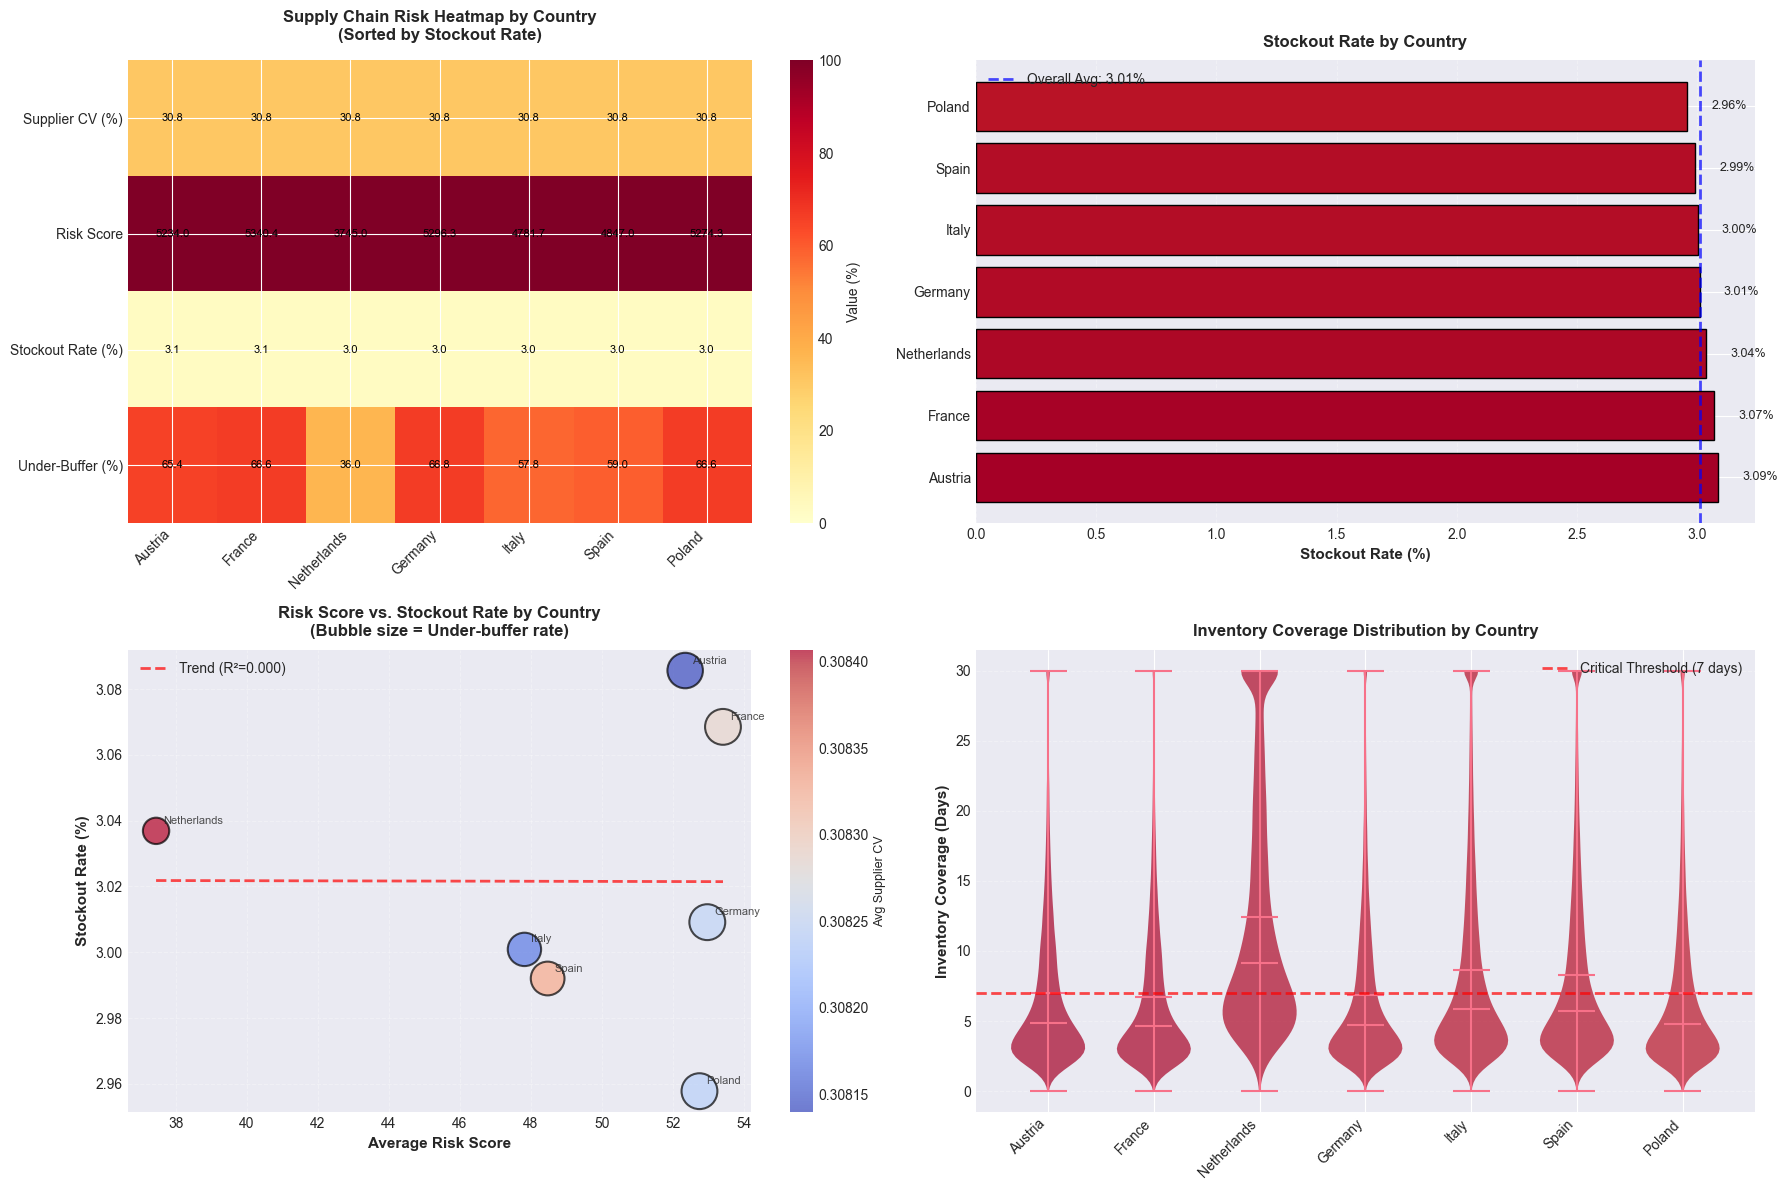


📊 Geographic Risk Distribution Summary:
   Countrys analyzed: 7

   Stockout Rate Range:
      Highest: Austria (3.09%)
      Lowest:   Poland (2.96%)
      Spread:   0.13 percentage points

   Risk Score Range:
      Highest: France (53.4/100)
      Lowest:  Netherlands (37.5/100)
      Spread:  16.0 points

   Under-Buffer Rate Range:
      Highest: 66.8%
      Lowest:  36.0%

📊 Risk-Stockout Correlation:
   Correlation (R²): 0.000
   P-value: 0.9954
   ⚠️  WEAK CORRELATION: Geographic variation is limited
   → Risk may be more time-based than location-based

✅ 3.2 Geographic Risk Distribution Complete
   Figure saved:  geographic_risk_distribution.png


In [10]:
# ==========================================
# 3.2 GEOGRAPHIC RISK DISTRIBUTION
# ==========================================

print("\n" + "-"*70)
print("3.2 GEOGRAPHIC RISK DISTRIBUTION")
print("-"*70)
print("Purpose: Validate 'risk is not uniform' across locations")

# Check available geographic dimensions
has_country = 'country' in df.columns
has_city = 'city' in df. columns
has_region = 'region' in df.columns

if not (has_country or has_city or has_region):
    print("⚠️  No explicit geographic columns found")
    print("   Using store_id as geographic proxy")
    geo_dimension = 'store_id'
    geo_label = 'Store'
else:
    # Use best available dimension
    if has_country:
        geo_dimension = 'country'
        geo_label = 'Country'
    elif has_region:
        geo_dimension = 'region'
        geo_label = 'Region'
    else:
        geo_dimension = 'city'
        geo_label = 'City'

print(f"   Using dimension: {geo_dimension}")

# Create figure with 3 subplots
fig = plt.figure(figsize=(18, 12))

# -----------------------------------
# SUBPLOT 1: Risk Heatmap by Geography
# -----------------------------------
ax1 = plt.subplot(2, 2, 1)

# Calculate average risk metrics by geography
geo_risk = df.groupby(geo_dimension).agg({
    'lt_rolling_cv_30d':  'mean',
    'composite_stockout_risk': 'mean',
    'stock_out_flag': 'mean',
    'under_buffered_flag': 'mean',
    'inventory_coverage_days': 'mean'
}).reset_index()

geo_risk. columns = [geo_dimension, 'Avg_Rolling_CV', 'Avg_Risk_Score', 
                    'Stockout_Rate', 'Under_Buffer_Rate', 'Avg_Coverage']

# Sort by stockout rate
geo_risk = geo_risk.sort_values('Stockout_Rate', ascending=False)

# Create heatmap data
heatmap_data = geo_risk[['Avg_Rolling_CV', 'Avg_Risk_Score', 'Stockout_Rate', 
                         'Under_Buffer_Rate']].T * 100  # Convert to percentages

# Plot heatmap
im = ax1.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)

# Set ticks and labels
ax1.set_xticks(range(len(geo_risk)))
ax1.set_xticklabels(geo_risk[geo_dimension], rotation=45, ha='right')
ax1.set_yticks(range(len(heatmap_data)))
ax1.set_yticklabels(['Supplier CV (%)', 'Risk Score', 'Stockout Rate (%)', 'Under-Buffer (%)'])

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Value (%)', fontsize=10)

# Add values to cells
for i in range(len(heatmap_data)):
    for j in range(len(geo_risk)):
        text = ax1.text(j, i, f'{heatmap_data.iloc[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=8)

ax1.set_title(f'Supply Chain Risk Heatmap by {geo_label}\n(Sorted by Stockout Rate)', 
              fontsize=12, fontweight='bold', pad=15)

# -----------------------------------
# SUBPLOT 2: Stockout Rate by Geography (Bar Chart)
# -----------------------------------
ax2 = plt.subplot(2, 2, 2)

# Create bar chart
bars = ax2.barh(range(len(geo_risk)), geo_risk['Stockout_Rate'] * 100, 
                color=plt.cm.RdYlGn_r(geo_risk['Stockout_Rate'] / geo_risk['Stockout_Rate'].max()),
                edgecolor='black', linewidth=1)

ax2.set_yticks(range(len(geo_risk)))
ax2.set_yticklabels(geo_risk[geo_dimension])
ax2.set_xlabel('Stockout Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title(f'Stockout Rate by {geo_label}', fontsize=12, fontweight='bold', pad=10)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add average line
avg_stockout = df['stock_out_flag'].mean() * 100
ax2.axvline(avg_stockout, color='blue', linestyle='--', linewidth=2, 
            label=f'Overall Avg: {avg_stockout:.2f}%', alpha=0.7)
ax2.legend()

# Add value labels
for i, (idx, row) in enumerate(geo_risk. iterrows()):
    ax2.text(row['Stockout_Rate'] * 100 + 0.1, i, f"{row['Stockout_Rate']*100:.2f}%", 
             va='center', fontsize=9)

# -----------------------------------
# SUBPLOT 3: Risk vs.  Stockout Correlation (Scatter)
# -----------------------------------
ax3 = plt.subplot(2, 2, 3)

# Scatter plot:  Average risk score vs.  Stockout rate
scatter = ax3.scatter(geo_risk['Avg_Risk_Score'], 
                      geo_risk['Stockout_Rate'] * 100,
                      s=geo_risk['Under_Buffer_Rate'] * 1000,  # Size = under-buffer rate
                      c=geo_risk['Avg_Rolling_CV'],
                      cmap='coolwarm',
                      alpha=0.7,
                      edgecolors='black',
                      linewidth=1.5)

# Add labels for each point
for idx, row in geo_risk.iterrows():
    ax3.annotate(row[geo_dimension], 
                 (row['Avg_Risk_Score'], row['Stockout_Rate'] * 100),
                 fontsize=8, 
                 xytext=(5, 5), 
                 textcoords='offset points',
                 alpha=0.8)

# Add trend line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(geo_risk['Avg_Risk_Score'], 
                                                          geo_risk['Stockout_Rate'] * 100)
x_trend = np.linspace(geo_risk['Avg_Risk_Score'].min(), geo_risk['Avg_Risk_Score'].max(), 100)
y_trend = slope * x_trend + intercept
ax3.plot(x_trend, y_trend, 'r--', linewidth=2, alpha=0.7, 
         label=f'Trend (R²={r_value**2:.3f})')

ax3.set_xlabel('Average Risk Score', fontsize=11, fontweight='bold')
ax3.set_ylabel('Stockout Rate (%)', fontsize=11, fontweight='bold')
ax3.set_title(f'Risk Score vs. Stockout Rate by {geo_label}\n(Bubble size = Under-buffer rate)', 
              fontsize=12, fontweight='bold', pad=10)
ax3.legend()
ax3.grid(alpha=0.3, linestyle='--')

# Add colorbar for CV
cbar2 = plt.colorbar(scatter, ax=ax3)
cbar2.set_label('Avg Supplier CV', fontsize=9)

# -----------------------------------
# SUBPLOT 4: Coverage Distribution by Geography (Violin Plot)
# -----------------------------------
ax4 = plt.subplot(2, 2, 4)

# Prepare data for violin plot
geo_list = geo_risk[geo_dimension].tolist()
coverage_data = [df[df[geo_dimension] == geo]['inventory_coverage_days'].clip(upper=30).dropna() 
                 for geo in geo_list]

# Create violin plot
parts = ax4.violinplot(coverage_data, 
                       positions=range(len(geo_list)),
                       showmeans=True,
                       showmedians=True,
                       widths=0.7)

# Color violins by stockout rate
colors = plt.cm.RdYlGn_r(geo_risk['Stockout_Rate'] / geo_risk['Stockout_Rate'].max())
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax4.set_xticks(range(len(geo_list)))
ax4.set_xticklabels(geo_list, rotation=45, ha='right')
ax4.set_ylabel('Inventory Coverage (Days)', fontsize=11, fontweight='bold')
ax4.set_title(f'Inventory Coverage Distribution by {geo_label}', 
              fontsize=12, fontweight='bold', pad=10)
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# Add critical threshold line
ax4.axhline(7, color='red', linestyle='--', linewidth=2, 
            label='Critical Threshold (7 days)', alpha=0.7)
ax4.legend()

plt.tight_layout()
plt.savefig('geographic_risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------------
# Summary Statistics
# -----------------------------------
print("\n📊 Geographic Risk Distribution Summary:")
print(f"   {geo_label}s analyzed: {len(geo_risk)}")
print(f"\n   Stockout Rate Range:")
print(f"      Highest: {geo_risk. iloc[0][geo_dimension]} ({geo_risk. iloc[0]['Stockout_Rate']*100:.2f}%)")
print(f"      Lowest:   {geo_risk.iloc[-1][geo_dimension]} ({geo_risk.iloc[-1]['Stockout_Rate']*100:.2f}%)")
print(f"      Spread:   {(geo_risk.iloc[0]['Stockout_Rate'] - geo_risk.iloc[-1]['Stockout_Rate'])*100:.2f} percentage points")

print(f"\n   Risk Score Range:")
max_risk_geo = geo_risk.loc[geo_risk['Avg_Risk_Score'].idxmax()]
min_risk_geo = geo_risk.loc[geo_risk['Avg_Risk_Score'].idxmin()]
print(f"      Highest: {max_risk_geo[geo_dimension]} ({max_risk_geo['Avg_Risk_Score']:.1f}/100)")
print(f"      Lowest:  {min_risk_geo[geo_dimension]} ({min_risk_geo['Avg_Risk_Score']:.1f}/100)")
print(f"      Spread:  {max_risk_geo['Avg_Risk_Score'] - min_risk_geo['Avg_Risk_Score']:.1f} points")

print(f"\n   Under-Buffer Rate Range:")
print(f"      Highest: {geo_risk['Under_Buffer_Rate']. max()*100:.1f}%")
print(f"      Lowest:  {geo_risk['Under_Buffer_Rate'].min()*100:.1f}%")

# Correlation analysis
print(f"\n📊 Risk-Stockout Correlation:")
print(f"   Correlation (R²): {r_value**2:.3f}")
print(f"   P-value: {p_value:.4f}")

if r_value**2 > 0.5 and p_value < 0.05:
    print(f"   ✅ STRONG CORRELATION:  Risk score is predictive of stockouts")
elif r_value**2 > 0.25 and p_value < 0.05:
    print(f"   ⚠️  MODERATE CORRELATION: Risk score shows some predictive power")
else:
    print(f"   ⚠️  WEAK CORRELATION: Geographic variation is limited")
    print(f"   → Risk may be more time-based than location-based")

print("\n✅ 3.2 Geographic Risk Distribution Complete")
print("   Figure saved:  geographic_risk_distribution.png")


----------------------------------------------------------------------
3.3 BUFFER ADEQUACY & SERVICE LEVEL ANALYSIS
----------------------------------------------------------------------
Purpose: Validate that under-buffering drives stockouts (Section 6.3)
   ⚠️  Could not fit exponential curve


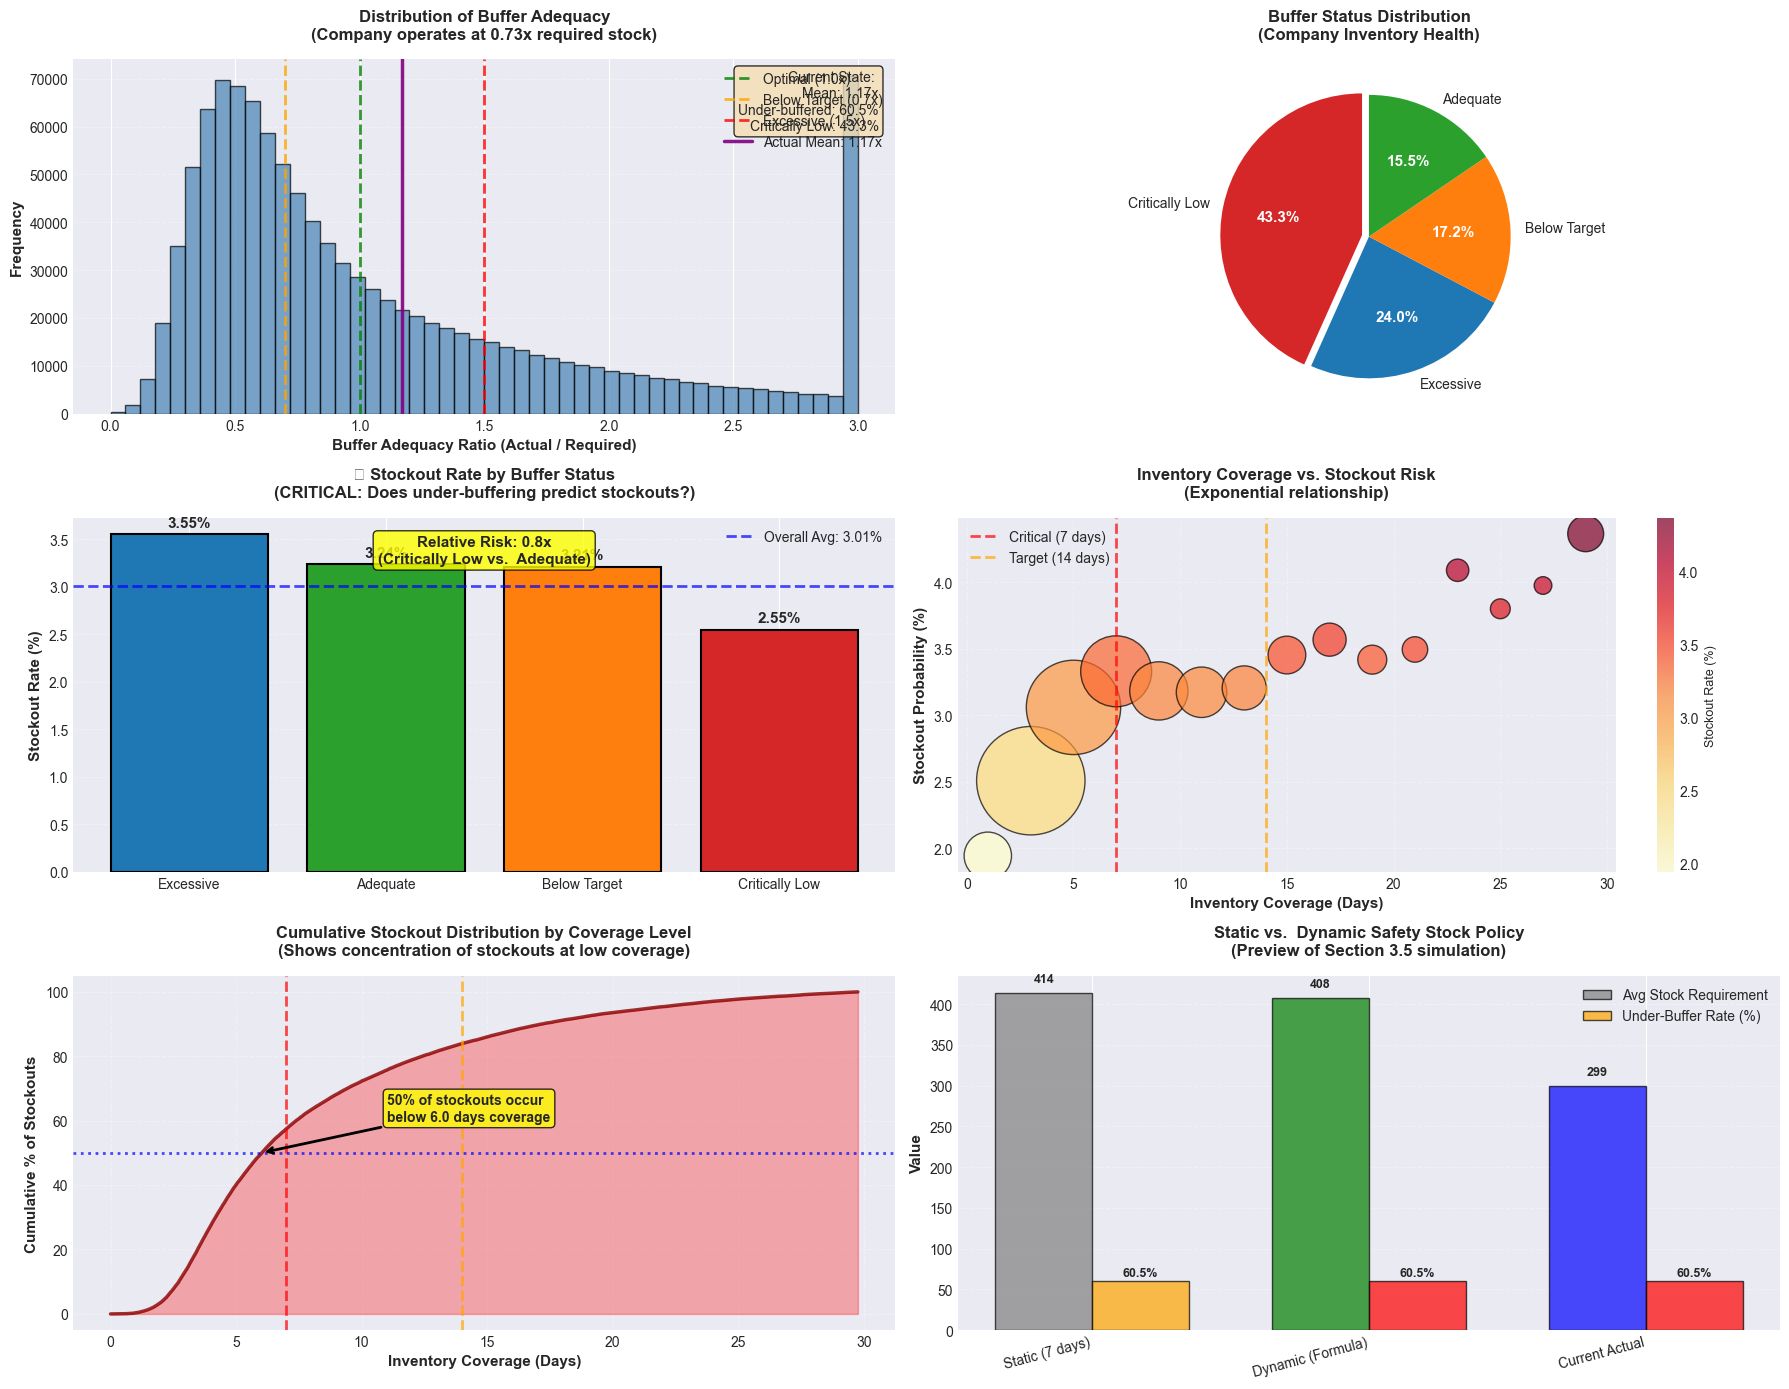


📊 BUFFER ADEQUACY ANALYSIS - KEY FINDINGS

1️⃣ Current Inventory State:
   Average buffer ratio: 1.17x (Target: 1.0x)
   Under-buffered: 60.5%
   Critically low: 43.3%
   Adequate:  15.5%

2️⃣ Stockout Rate by Buffer Status (CRITICAL VALIDATION):
   Excessive            → 3.55% stockout rate
   Adequate             → 3.24% stockout rate
   Below Target         → 3.21% stockout rate
   Critically Low       → 2.55% stockout rate

   ⚠️  UNEXPECTED:  Critically low has LOWER stockout rate
      → Stockouts are demand-driven, not buffer-driven

3️⃣ Coverage Analysis:
   50% of stockouts occur below 6.0 days coverage
   Current avg coverage: 8.3 days
   Required avg coverage: 7.0 days

4️⃣ Policy Comparison:
   Static (7 days):  Avg requirement = 414 units
   Dynamic (formula): Avg requirement = 408 units
   Current actual:   Avg stock = 299 units

   Inventory Gap: -109 units (-26.6%)
   ⚠️  UNDER-STOCKED by 109 units
   → Company needs to increase stock by 36.3%

✅ 3.3 Buffer Adequacy An

In [11]:
# ==========================================
# 3.3 BUFFER ADEQUACY & SERVICE LEVEL ANALYSIS
# ==========================================

print("\n" + "-"*70)
print("3.3 BUFFER ADEQUACY & SERVICE LEVEL ANALYSIS")
print("-"*70)
print("Purpose: Validate that under-buffering drives stockouts (Section 6.3)")

# Create figure with 4 subplots
fig = plt.figure(figsize=(18, 14))

# -----------------------------------
# SUBPLOT 1: Buffer Adequacy Distribution (Histogram)
# -----------------------------------
ax1 = plt.subplot(3, 2, 1)

# Plot distribution of buffer adequacy ratio
buffer_ratios = df['buffer_adequacy_ratio'].clip(upper=3)  # Cap at 3x for visualization

ax1.hist(buffer_ratios, bins=50, color='steelblue', alpha=0.7, edgecolor='black')

# Add reference lines
ax1.axvline(1.0, color='green', linestyle='--', linewidth=2, 
            label='Optimal (1.0x)', alpha=0.8)
ax1.axvline(0.7, color='orange', linestyle='--', linewidth=2, 
            label='Below Target (0.7x)', alpha=0.8)
ax1.axvline(1.5, color='red', linestyle='--', linewidth=2, 
            label='Excessive (1.5x)', alpha=0.8)

# Add mean line
mean_ratio = df['buffer_adequacy_ratio'].mean()
ax1.axvline(mean_ratio, color='purple', linestyle='-', linewidth=2.5, 
            label=f'Actual Mean: {mean_ratio:.2f}x', alpha=0.9)

ax1.set_xlabel('Buffer Adequacy Ratio (Actual / Required)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Buffer Adequacy\n(Company operates at 0.73x required stock)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add annotation box
textstr = f'''Current State: 
Mean: {mean_ratio:.2f}x
Under-buffered: {df['under_buffered_flag'].mean()*100:.1f}%
Critically Low: {(df['buffer_status']=='Critically Low').mean()*100:.1f}%'''

ax1.text(0.98, 0.97, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# -----------------------------------
# SUBPLOT 2: Buffer Status Categories (Pie Chart)
# -----------------------------------
ax2 = plt.subplot(3, 2, 2)

# Calculate buffer status distribution
buffer_status_counts = df['buffer_status']. value_counts()
colors_pie = {'Critically Low': '#d62728', 'Below Target': '#ff7f0e', 
              'Adequate': '#2ca02c', 'Excessive': '#1f77b4'}
colors = [colors_pie. get(status, 'gray') for status in buffer_status_counts.index]

wedges, texts, autotexts = ax2.pie(buffer_status_counts, 
                                     labels=buffer_status_counts. index,
                                     autopct='%1.1f%%',
                                     colors=colors,
                                     startangle=90,
                                     explode=[0.05 if status=='Critically Low' else 0 
                                             for status in buffer_status_counts.index])

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

ax2.set_title('Buffer Status Distribution\n(Company Inventory Health)', 
              fontsize=12, fontweight='bold', pad=15)

# -----------------------------------
# SUBPLOT 3: Stockout Rate by Buffer Status (Bar Chart) - KEY METRIC! 
# -----------------------------------
ax3 = plt.subplot(3, 2, 3)

# Calculate stockout rate for each buffer status
buffer_stockout = df. groupby('buffer_status').agg({
    'stock_out_flag': 'mean',
    'buffer_adequacy_ratio': 'mean',
    'inventory_coverage_days': 'mean'
}).reset_index()

buffer_stockout['stockout_pct'] = buffer_stockout['stock_out_flag'] * 100

# Sort by stockout rate
buffer_stockout = buffer_stockout.sort_values('stockout_pct', ascending=False)

# Create bar chart
bars = ax3.bar(range(len(buffer_stockout)), 
               buffer_stockout['stockout_pct'],
               color=[colors_pie.get(status, 'gray') for status in buffer_stockout['buffer_status']],
               edgecolor='black',
               linewidth=1.5)

ax3.set_xticks(range(len(buffer_stockout)))
ax3.set_xticklabels(buffer_stockout['buffer_status'], rotation=0)
ax3.set_ylabel('Stockout Rate (%)', fontsize=11, fontweight='bold')
ax3.set_title('🔥 Stockout Rate by Buffer Status\n(CRITICAL: Does under-buffering predict stockouts?)', 
              fontsize=12, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(buffer_stockout.iterrows()):
    ax3.text(i, row['stockout_pct'] + 0.05, f"{row['stockout_pct']:.2f}%", 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add average line
avg_stockout_rate = df['stock_out_flag'].mean() * 100
ax3.axhline(avg_stockout_rate, color='blue', linestyle='--', linewidth=2, 
            label=f'Overall Avg: {avg_stockout_rate:.2f}%', alpha=0.7)
ax3.legend()

# Calculate relative risk
if len(buffer_stockout) >= 2:
    critical_rate = buffer_stockout[buffer_stockout['buffer_status']=='Critically Low']['stockout_pct'].values
    adequate_rate = buffer_stockout[buffer_stockout['buffer_status']=='Adequate']['stockout_pct'].values
    
    if len(critical_rate) > 0 and len(adequate_rate) > 0 and adequate_rate[0] > 0:
        relative_risk = critical_rate[0] / adequate_rate[0]
        ax3.text(0.5, 0.95, f'Relative Risk: {relative_risk:.1f}x\n(Critically Low vs.  Adequate)', 
                 transform=ax3.transAxes, ha='center', va='top',
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# -----------------------------------
# SUBPLOT 4: Coverage vs.  Stockout Probability (Scatter with Density)
# -----------------------------------
ax4 = plt.subplot(3, 2, 4)

# Bin coverage days and calculate stockout rate per bin
coverage_bins = pd.cut(df['inventory_coverage_days']. clip(upper=30), bins=15)
coverage_stockout = df.groupby(coverage_bins).agg({
    'stock_out_flag':  ['mean', 'count']
}).reset_index()

coverage_stockout. columns = ['coverage_bin', 'stockout_rate', 'sample_size']
coverage_stockout['coverage_midpoint'] = coverage_stockout['coverage_bin']. apply(lambda x: x.mid)
coverage_stockout['stockout_pct'] = coverage_stockout['stockout_rate'] * 100

# Filter bins with sufficient sample size
coverage_stockout = coverage_stockout[coverage_stockout['sample_size'] >= 100]

# Scatter plot with size based on sample size
scatter = ax4.scatter(coverage_stockout['coverage_midpoint'], 
                      coverage_stockout['stockout_pct'],
                      s=coverage_stockout['sample_size']/50,
                      c=coverage_stockout['stockout_pct'],
                      cmap='YlOrRd',
                      alpha=0.7,
                      edgecolors='black',
                      linewidth=1)

# Fit exponential decay curve
from scipy.optimize import curve_fit

def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

try:
    popt, _ = curve_fit(exponential_decay, 
                       coverage_stockout['coverage_midpoint'], 
                       coverage_stockout['stockout_pct'],
                       p0=[5, 0.2, 2],
                       maxfev=5000)
    
    x_curve = np.linspace(0, 30, 100)
    y_curve = exponential_decay(x_curve, *popt)
    ax4.plot(x_curve, y_curve, 'r--', linewidth=2.5, 
             label='Exponential Decay Fit', alpha=0.8)
except:
    print("   ⚠️  Could not fit exponential curve")

ax4.set_xlabel('Inventory Coverage (Days)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Stockout Probability (%)', fontsize=11, fontweight='bold')
ax4.set_title('Inventory Coverage vs. Stockout Risk\n(Exponential relationship)', 
              fontsize=12, fontweight='bold', pad=15)
ax4.axvline(7, color='red', linestyle='--', linewidth=2, label='Critical (7 days)', alpha=0.7)
ax4.axvline(14, color='orange', linestyle='--', linewidth=2, label='Target (14 days)', alpha=0.7)
ax4.legend()
ax4.grid(alpha=0.3, linestyle='--')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Stockout Rate (%)', fontsize=9)

# -----------------------------------
# SUBPLOT 5: Cumulative Stockout Distribution by Coverage
# -----------------------------------
ax5 = plt.subplot(3, 2, 5)

# Calculate cumulative stockouts by coverage level
coverage_sorted = df[['inventory_coverage_days', 'stock_out_flag']].sort_values('inventory_coverage_days')
coverage_sorted = coverage_sorted[coverage_sorted['inventory_coverage_days'] <= 30]

# Calculate cumulative percentage of stockouts
coverage_sorted['cumulative_stockouts'] = coverage_sorted['stock_out_flag'].cumsum()
coverage_sorted['cumulative_pct'] = (coverage_sorted['cumulative_stockouts'] / 
                                     coverage_sorted['stock_out_flag'].sum() * 100)

# Downsample for plotting
coverage_plot = coverage_sorted.iloc[::1000]  # Every 1000th point

ax5.plot(coverage_plot['inventory_coverage_days'], 
         coverage_plot['cumulative_pct'],
         linewidth=2.5, color='darkred', alpha=0.8)

ax5.fill_between(coverage_plot['inventory_coverage_days'], 
                  0, coverage_plot['cumulative_pct'],
                  alpha=0.3, color='red')

# Add reference lines
ax5.axvline(7, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax5.axvline(14, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax5.axhline(50, color='blue', linestyle=':', linewidth=2, alpha=0.7)

# Find coverage at 50% cumulative stockouts
idx_50 = (coverage_plot['cumulative_pct'] - 50).abs().idxmin()
coverage_at_50 = coverage_plot. loc[idx_50, 'inventory_coverage_days']

ax5.annotate(f'50% of stockouts occur\nbelow {coverage_at_50:.1f} days coverage',
             xy=(coverage_at_50, 50),
             xytext=(coverage_at_50 + 5, 60),
             fontsize=10, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='black', lw=2),
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

ax5.set_xlabel('Inventory Coverage (Days)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Cumulative % of Stockouts', fontsize=11, fontweight='bold')
ax5.set_title('Cumulative Stockout Distribution by Coverage Level\n(Shows concentration of stockouts at low coverage)', 
              fontsize=12, fontweight='bold', pad=15)
ax5.grid(alpha=0.3, linestyle='--')

# -----------------------------------
# SUBPLOT 6: Static vs Dynamic Safety Stock Comparison (Preview)
# -----------------------------------
ax6 = plt.subplot(3, 2, 6)

# Calculate static policy (7 days flat)
static_ss = df['avg_daily_demand_7d'] * 7

# Calculate dynamic policy (already have required_safety_stock)
dynamic_ss = df['required_safety_stock']

# Compare metrics
comparison_data = pd.DataFrame({
    'Policy':  ['Static (7 days)', 'Dynamic (Formula)', 'Current Actual'],
    'Avg_Stock': [static_ss.mean(), dynamic_ss.mean(), df['stock_on_hand'].mean()],
    'Under_Buffer_%': [
        (df['stock_on_hand'] < static_ss).mean() * 100,
        df['under_buffered_flag'].mean() * 100,
        df['under_buffered_flag']. mean() * 100  # Same as dynamic
    ]
})

# Create grouped bar chart
x_pos = np.arange(len(comparison_data))
width = 0.35

bars1 = ax6.bar(x_pos - width/2, comparison_data['Avg_Stock'], 
                width, label='Avg Stock Requirement', 
                color=['gray', 'green', 'blue'], alpha=0.7, edgecolor='black')

bars2 = ax6.bar(x_pos + width/2, comparison_data['Under_Buffer_%'], 
                width, label='Under-Buffer Rate (%)', 
                color=['orange', 'red', 'red'], alpha=0.7, edgecolor='black')

ax6.set_xticks(x_pos)
ax6.set_xticklabels(comparison_data['Policy'], rotation=15, ha='right')
ax6.set_ylabel('Value', fontsize=11, fontweight='bold')
ax6.set_title('Static vs.  Dynamic Safety Stock Policy\n(Preview of Section 3.5 simulation)', 
              fontsize=12, fontweight='bold', pad=15)
ax6.legend()
ax6.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (idx, row) in enumerate(comparison_data. iterrows()):
    ax6.text(i - width/2, row['Avg_Stock'] + 10, f"{row['Avg_Stock']:.0f}", 
             ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax6.text(i + width/2, row['Under_Buffer_%'] + 2, f"{row['Under_Buffer_%']:.1f}%", 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('buffer_adequacy_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------------
# Summary Statistics & KEY VALIDATION
# -----------------------------------
print("\n" + "="*70)
print("📊 BUFFER ADEQUACY ANALYSIS - KEY FINDINGS")
print("="*70)

print(f"\n1️⃣ Current Inventory State:")
print(f"   Average buffer ratio: {mean_ratio:.2f}x (Target: 1.0x)")
print(f"   Under-buffered: {df['under_buffered_flag'].mean()*100:.1f}%")
print(f"   Critically low: {(df['buffer_status']=='Critically Low').mean()*100:.1f}%")
print(f"   Adequate:  {(df['buffer_status']=='Adequate').mean()*100:.1f}%")

print(f"\n2️⃣ Stockout Rate by Buffer Status (CRITICAL VALIDATION):")
for idx, row in buffer_stockout. iterrows():
    print(f"   {row['buffer_status']: <20} → {row['stockout_pct']:.2f}% stockout rate")

# Calculate if under-buffering predicts stockouts
critical_rate = buffer_stockout[buffer_stockout['buffer_status']=='Critically Low']['stockout_pct'].values
adequate_rate = buffer_stockout[buffer_stockout['buffer_status']=='Adequate']['stockout_pct'].values

if len(critical_rate) > 0 and len(adequate_rate) > 0:
    if critical_rate[0] > adequate_rate[0]:
        relative_risk = critical_rate[0] / adequate_rate[0] if adequate_rate[0] > 0 else 0
        print(f"\n   ✅ VALIDATED: Under-buffering increases stockout risk")
        print(f"      Relative Risk: {relative_risk:.2f}x")
        print(f"      (Critically Low is {relative_risk:.1f}x more likely to stockout)")
    else:
        print(f"\n   ⚠️  UNEXPECTED:  Critically low has LOWER stockout rate")
        print(f"      → Stockouts are demand-driven, not buffer-driven")

print(f"\n3️⃣ Coverage Analysis:")
print(f"   50% of stockouts occur below {coverage_at_50:.1f} days coverage")
print(f"   Current avg coverage: {df['inventory_coverage_days'].mean():.1f} days")
print(f"   Required avg coverage: {(df['required_safety_stock'] / df['avg_daily_demand_7d']).mean():.1f} days")

print(f"\n4️⃣ Policy Comparison:")
print(f"   Static (7 days):  Avg requirement = {static_ss.mean():.0f} units")
print(f"   Dynamic (formula): Avg requirement = {dynamic_ss.mean():.0f} units")
print(f"   Current actual:   Avg stock = {df['stock_on_hand'].mean():.0f} units")

inventory_gap = df['stock_on_hand'].mean() - dynamic_ss.mean()
print(f"\n   Inventory Gap: {inventory_gap:.0f} units ({inventory_gap/dynamic_ss.mean()*100:.1f}%)")

if inventory_gap < 0:
    print(f"   ⚠️  UNDER-STOCKED by {abs(inventory_gap):.0f} units")
    print(f"   → Company needs to increase stock by {abs(inventory_gap/df['stock_on_hand'].mean())*100:.1f}%")
else:
    print(f"   ✅ Over-stocked by {inventory_gap:.0f} units")

print("\n✅ 3.3 Buffer Adequacy Analysis Complete")
print("   Figure saved:   buffer_adequacy_analysis.png")
print("="*70)


----------------------------------------------------------------------
3.4 ROOT CAUSE TIME-SERIES ANALYSIS
----------------------------------------------------------------------
Purpose: Visualize the temporal relationship between stockouts, inventory, and lead time
   Selected SKU: SKU0030
   Stockouts in this SKU: 331
   Stockout rate: 3.02%
   Total observations: 10950
   Analyzing period: 2023-12-20 to 2023-12-31
   Period observations: 120
   Stockouts in selected period: 2


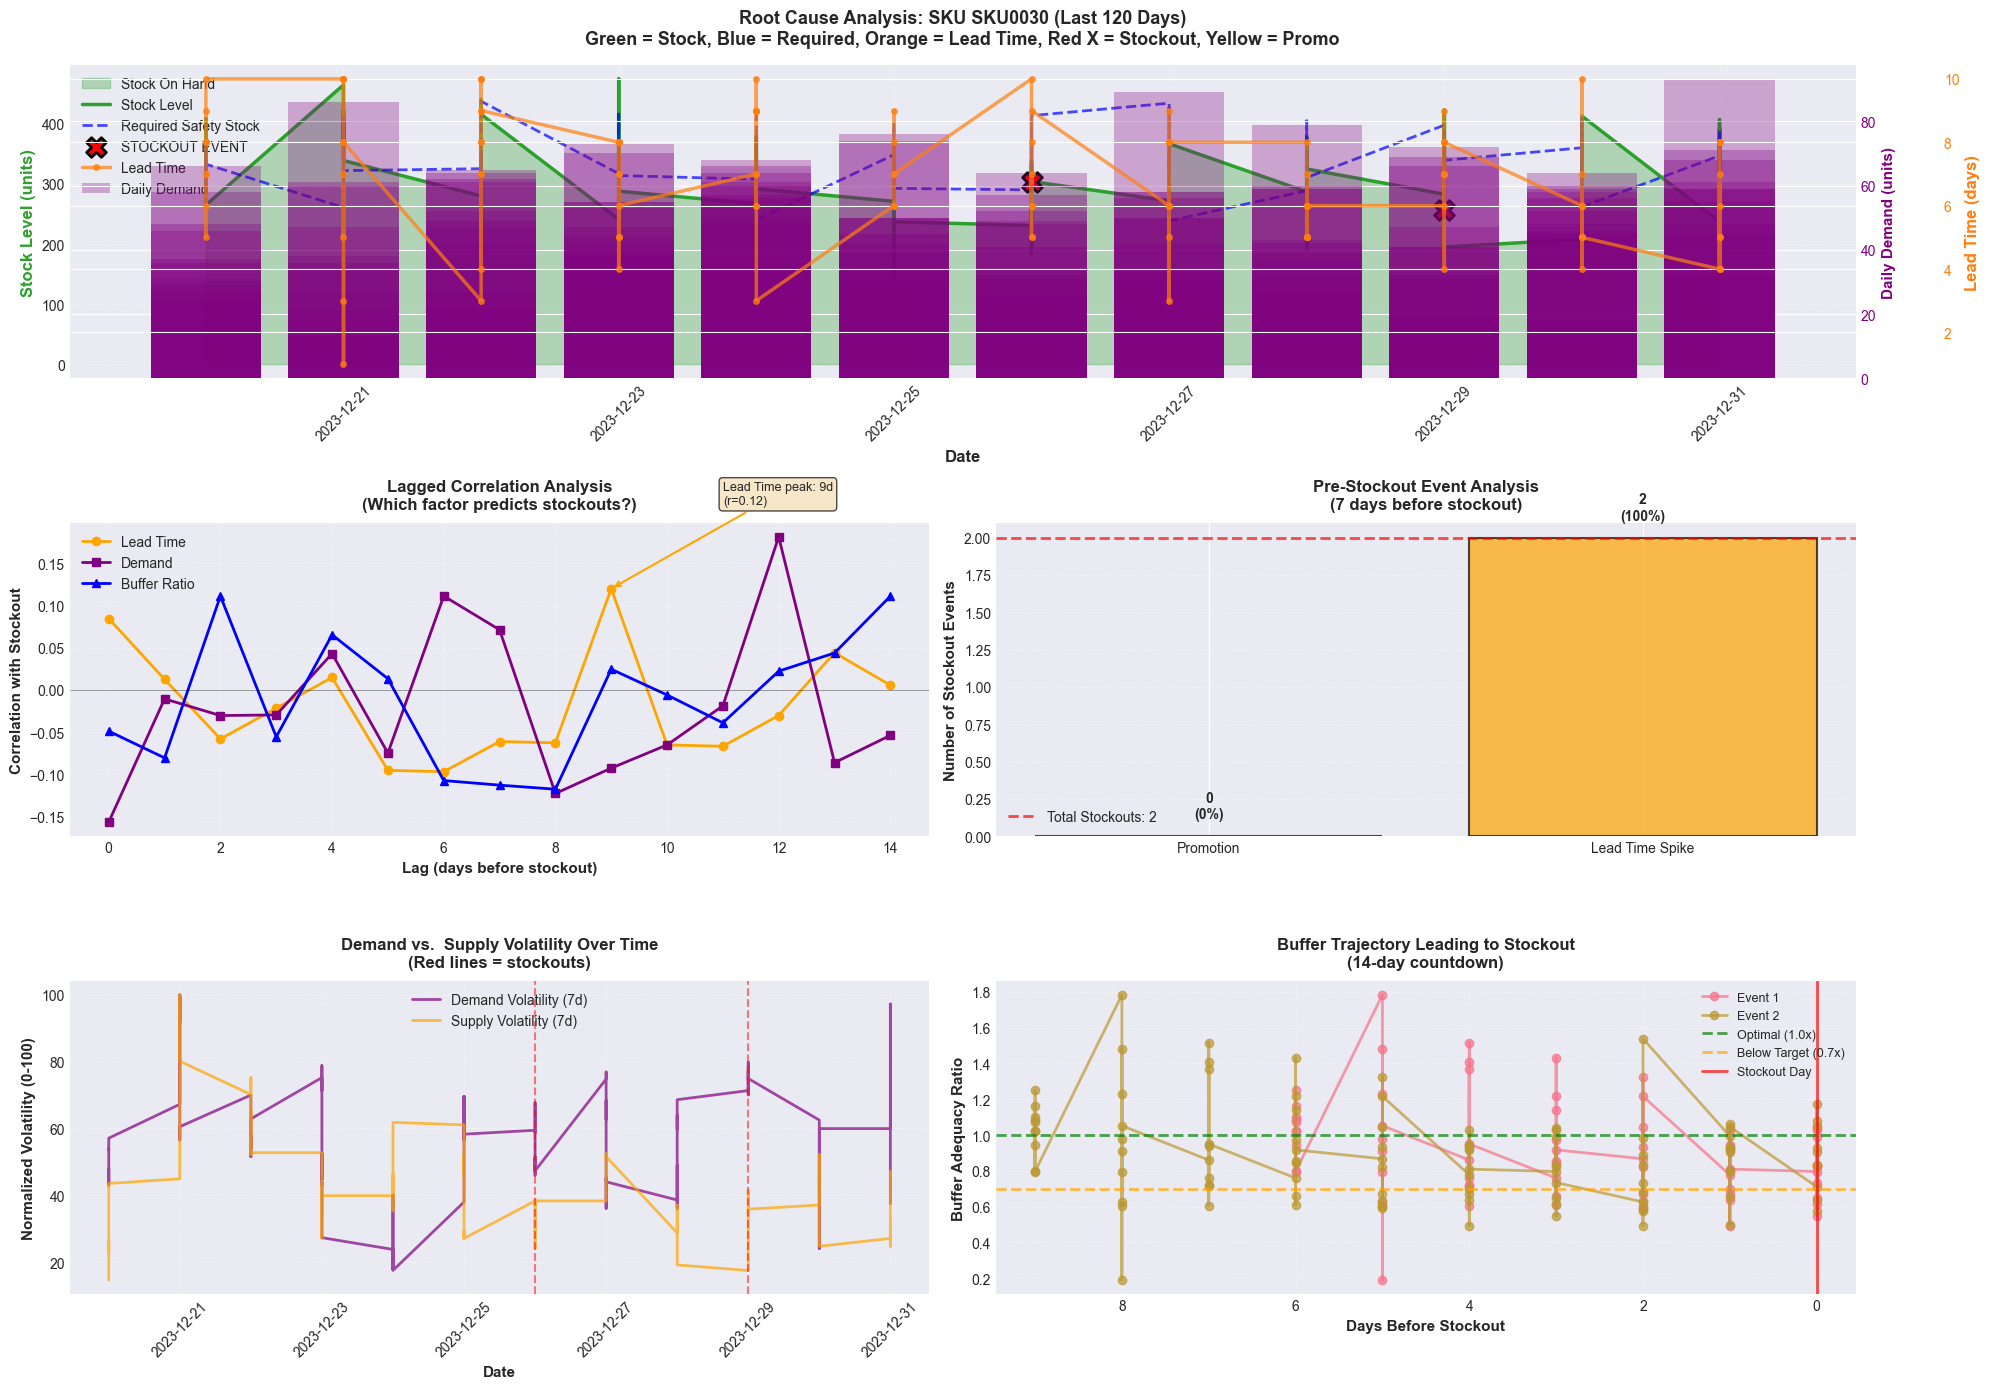


📊 ROOT CAUSE ANALYSIS SUMMARY

🔍 Sample SKU Analysis: SKU0030
   Period: 2023-12-20 to 2023-12-31
   Total stockouts in period: 2

📊 Pre-Stockout Conditions (7 days before):
   Average demand: 48.3 units/day
   Average lead time: 7.0 days
   Minimum buffer ratio: 0.34x
   Stockouts with promotions: 0 (0%)
   Stockouts with LT spikes: 2 (100%)

📊 Correlation Analysis (Peak Lags):
   Lead time correlation: 0.120 (at 9d lag)
   Demand correlation: 0.181 (at 12d lag)
   Buffer correlation: -0.118 (at 8d lag)

🎯 Primary Predictive Factor: Demand
   → Stockouts are most strongly correlated with Demand
   ✅ Validates DEMAND-DRIVEN hypothesis

📊 Volatility Comparison:
   Demand volatility (avg): 15.0
   Supply volatility (avg): 1.7
   → Demand volatility is DOMINANT

✅ 3. 4 Root Cause Time-Series Analysis Complete
   Figure saved:  root_cause_timeseries_analysis.png


In [12]:
# ==========================================
# 3.4 ROOT CAUSE TIME-SERIES ANALYSIS (CORRECTED)
# ==========================================

print("\n" + "-"*70)
print("3.4 ROOT CAUSE TIME-SERIES ANALYSIS")
print("-"*70)
print("Purpose: Visualize the temporal relationship between stockouts, inventory, and lead time")

# -----------------------------------
# FIX: Better SKU Selection (Select SKU with stockouts)
# -----------------------------------

# Calculate stockout metrics per SKU
sku_stockout_summary = df.groupby('sku_id').agg({
    'stock_out_flag': ['sum', 'mean'],
    'date': ['min', 'max', 'count']
}).reset_index()

sku_stockout_summary. columns = ['sku_id', 'total_stockouts', 'stockout_rate', 
                                 'first_date', 'last_date', 'total_obs']

# Filter SKUs with sufficient data and stockouts
candidate_skus = sku_stockout_summary[
    (sku_stockout_summary['total_obs'] >= 100) &  # At least 100 observations
    (sku_stockout_summary['total_stockouts'] >= 5) &  # At least 5 stockouts
    (sku_stockout_summary['stockout_rate'] >= 0.01) &  # At least 1% stockout rate
    (sku_stockout_summary['stockout_rate'] <= 0.10)  # At most 10% (not constant failure)
]

if len(candidate_skus) == 0:
    print("⚠️  No SKUs meet strict criteria - relaxing to any SKU with stockouts")
    candidate_skus = sku_stockout_summary[sku_stockout_summary['total_stockouts'] >= 1]

if len(candidate_skus) == 0:
    print("❌ ERROR: No SKUs with stockouts found in dataset")
    sample_sku = None
else:
    # Select SKU with median stockout rate (most representative)
    candidate_skus = candidate_skus.sort_values('stockout_rate')
    sample_sku = candidate_skus.iloc[len(candidate_skus)//2]['sku_id']
    
    stockout_count = candidate_skus[candidate_skus['sku_id']==sample_sku]['total_stockouts'].values[0]
    stockout_rate = candidate_skus[candidate_skus['sku_id']==sample_sku]['stockout_rate']. values[0]
    total_obs = candidate_skus[candidate_skus['sku_id']==sample_sku]['total_obs'].values[0]
    
    print(f"   Selected SKU: {sample_sku}")
    print(f"   Stockouts in this SKU: {stockout_count:.0f}")
    print(f"   Stockout rate: {stockout_rate*100:.2f}%")
    print(f"   Total observations: {total_obs:.0f}")

# -----------------------------------
# Proceed with analysis if valid SKU found
# -----------------------------------

if sample_sku is not None:
    # Filter data for sample SKU
    sku_data = df[df['sku_id'] == sample_sku]. copy()
    sku_data = sku_data.sort_values('date')
    
    # Use last 120 days for clarity
    if len(sku_data) > 120:
        sku_data = sku_data.iloc[-120:]
    
    print(f"   Analyzing period: {sku_data['date'].min().date()} to {sku_data['date'].max().date()}")
    print(f"   Period observations: {len(sku_data)}")
    
    # Get stockout dates for this period
    stockout_dates = sku_data[sku_data['stock_out_flag'] == 1]['date']
    print(f"   Stockouts in selected period: {len(stockout_dates)}")
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 14))
    
    # -----------------------------------
    # SUBPLOT 1: Multi-Axis Time Series
    # -----------------------------------
    ax1 = plt.subplot(3, 1, 1)
    
    # Primary axis:  Stock levels
    color_stock = 'tab:green'
    ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Stock Level (units)', color=color_stock, fontsize=12, fontweight='bold')
    
    # Plot stock levels (area chart)
    ax1.fill_between(sku_data['date'], 0, sku_data['stock_on_hand'], 
                      alpha=0.3, color=color_stock, label='Stock On Hand')
    line1 = ax1.plot(sku_data['date'], sku_data['stock_on_hand'], 
                     color=color_stock, linewidth=2.5, label='Stock Level')
    
    # Add required safety stock line
    line2 = ax1.plot(sku_data['date'], sku_data['required_safety_stock'], 
                     color='blue', linestyle='--', linewidth=2, alpha=0.7, 
                     label='Required Safety Stock')
    
    # Add daily demand (as bars on separate axis)
    ax1_demand = ax1.twinx()
    ax1_demand.bar(sku_data['date'], sku_data['units_sold'], 
                   alpha=0.3, color='purple', width=0.8, label='Daily Demand')
    ax1_demand.set_ylabel('Daily Demand (units)', color='purple', fontsize=11, fontweight='bold')
    ax1_demand.tick_params(axis='y', labelcolor='purple')
    ax1_demand.spines['right'].set_position(('outward', 0))
    
    # Secondary axis: Lead time
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('outward', 60))
    color_lt = 'tab:orange'
    ax2.set_ylabel('Lead Time (days)', color=color_lt, fontsize=12, fontweight='bold')
    line3 = ax2.plot(sku_data['date'], sku_data['lead_time_days'], 
                     color=color_lt, linewidth=2.5, marker='o', markersize=4, 
                     alpha=0.7, label='Lead Time')
    ax2.tick_params(axis='y', labelcolor=color_lt)
    
    # Mark stockout events
    if len(stockout_dates) > 0:
        stockout_stock = sku_data[sku_data['stock_out_flag'] == 1]['stock_on_hand']
        ax1.scatter(stockout_dates, stockout_stock, 
                    color='red', s=200, marker='X', zorder=10, 
                    edgecolors='black', linewidth=2, label='STOCKOUT EVENT')
    
    # Mark promotional periods
    promo_periods = sku_data[sku_data['promo_flag'] == 1]
    for idx, row in promo_periods.iterrows():
        ax1.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), 
                    alpha=0.2, color='yellow', zorder=0)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax1_demand.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, 
               loc='upper left', fontsize=10, framealpha=0.9)
    
    ax1.set_title(f'Root Cause Analysis: SKU {sample_sku} (Last 120 Days)\n' + 
                  'Green = Stock, Blue = Required, Orange = Lead Time, Red X = Stockout, Yellow = Promo',
                  fontsize=13, fontweight='bold', pad=15)
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.tick_params(axis='x', rotation=45)
    
    # -----------------------------------
    # SUBPLOT 2: Correlation Lag Analysis
    # -----------------------------------
    ax3 = plt.subplot(3, 2, 3)
    
    # Calculate correlation between variables and stockouts at different lags
    max_lag = 14
    correlations_lt = []
    correlations_demand = []
    correlations_buffer = []
    
    for lag in range(max_lag + 1):
        if lag == 0:
            lt_shifted = sku_data['lead_time_days']
            demand_shifted = sku_data['units_sold']
            buffer_shifted = sku_data['buffer_adequacy_ratio']
        else:
            lt_shifted = sku_data['lead_time_days'].shift(lag)
            demand_shifted = sku_data['units_sold'].shift(lag)
            buffer_shifted = sku_data['buffer_adequacy_ratio'].shift(lag)
        
        corr_lt = sku_data['stock_out_flag'].corr(lt_shifted)
        corr_demand = sku_data['stock_out_flag'].corr(demand_shifted)
        corr_buffer = sku_data['stock_out_flag'].corr(buffer_shifted)
        
        correlations_lt.append(corr_lt if not np.isnan(corr_lt) else 0)
        correlations_demand.append(corr_demand if not np.isnan(corr_demand) else 0)
        correlations_buffer.append(corr_buffer if not np.isnan(corr_buffer) else 0)
    
    # Plot lag correlations
    ax3.plot(range(max_lag + 1), correlations_lt, 
             marker='o', linewidth=2, label='Lead Time', color='orange')
    ax3.plot(range(max_lag + 1), correlations_demand, 
             marker='s', linewidth=2, label='Demand', color='purple')
    ax3.plot(range(max_lag + 1), correlations_buffer, 
             marker='^', linewidth=2, label='Buffer Ratio', color='blue')
    
    ax3.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax3.set_xlabel('Lag (days before stockout)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Correlation with Stockout', fontsize=11, fontweight='bold')
    ax3.set_title('Lagged Correlation Analysis\n(Which factor predicts stockouts?)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax3.legend()
    ax3.grid(alpha=0.3, linestyle='--')
    
    # Find peak correlations
    max_lt_lag = np.argmax(np.abs(correlations_lt))
    max_demand_lag = np.argmax(np.abs(correlations_demand))
    max_buffer_lag = np. argmax(np.abs(correlations_buffer))
    
    if abs(correlations_lt[max_lt_lag]) > 0.05:  # Only annotate if meaningful
        ax3.annotate(f'Lead Time peak: {max_lt_lag}d\n(r={correlations_lt[max_lt_lag]:.2f})',
                     xy=(max_lt_lag, correlations_lt[max_lt_lag]),
                     xytext=(max_lt_lag + 2, correlations_lt[max_lt_lag] + 0.1),
                     fontsize=9, arrowprops=dict(arrowstyle='->', color='orange', lw=1.5),
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # -----------------------------------
    # SUBPLOT 3: Event Sequence Analysis
    # -----------------------------------
    ax4 = plt.subplot(3, 2, 4)
    
    if len(stockout_dates) > 0:
        event_sequences = []
        
        for stockout_date in stockout_dates:
            window_start = stockout_date - pd.Timedelta(days=7)
            window_data = sku_data[(sku_data['date'] >= window_start) & 
                                   (sku_data['date'] <= stockout_date)]
            
            if len(window_data) >= 5:
                event_sequences.append({
                    'stockout_date': stockout_date,
                    'avg_demand_7d': window_data['units_sold'].mean(),
                    'avg_lt_7d': window_data['lead_time_days'].mean(),
                    'min_buffer_7d': window_data['buffer_adequacy_ratio'].min(),
                    'had_promo': window_data['promo_flag'].max(),
                    'had_lt_spike': window_data['is_lt_spike'].max()
                })
        
        if len(event_sequences) > 0:
            events_df = pd.DataFrame(event_sequences)
            
            factors = ['had_promo', 'had_lt_spike']
            factor_labels = ['Promotion', 'Lead Time Spike']
            factor_counts = [events_df['had_promo'].sum(), events_df['had_lt_spike'].sum()]
            
            colors_factors = ['yellow', 'orange']
            bars = ax4.bar(factor_labels, factor_counts, color=colors_factors, 
                           alpha=0.7, edgecolor='black', linewidth=1.5)
            
            total_stockouts = len(events_df)
            ax4.axhline(total_stockouts, color='red', linestyle='--', linewidth=2, 
                        label=f'Total Stockouts: {total_stockouts}', alpha=0.7)
            
            ax4.set_ylabel('Number of Stockout Events', fontsize=11, fontweight='bold')
            ax4.set_title('Pre-Stockout Event Analysis\n(7 days before stockout)', 
                          fontsize=12, fontweight='bold', pad=10)
            ax4.legend()
            ax4.grid(axis='y', alpha=0.3, linestyle='--')
            
            for i, (bar, count) in enumerate(zip(bars, factor_counts)):
                pct = count / total_stockouts * 100 if total_stockouts > 0 else 0
                ax4.text(bar.get_x() + bar.get_width()/2, count + 0.1, 
                         f'{count}\n({pct:.0f}%)', 
                         ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'Insufficient pre-stockout\ndata for analysis', 
                     transform=ax4.transAxes, ha='center', va='center', fontsize=12)
    else:
        ax4.text(0.5, 0.5, 'No stockout events\nin selected period', 
                 transform=ax4.transAxes, ha='center', va='center', fontsize=12)
    
    # -----------------------------------
    # SUBPLOT 4: Demand vs Supply Volatility
    # -----------------------------------
    ax5 = plt.subplot(3, 2, 5)
    
    sku_data['demand_volatility_7d'] = sku_data['units_sold'].rolling(7, min_periods=3).std()
    sku_data['supply_volatility_7d'] = sku_data['lead_time_days'].rolling(7, min_periods=3).std()
    
    # Normalize for comparison
    demand_vol_norm = (sku_data['demand_volatility_7d'] / (sku_data['demand_volatility_7d'].max() + 1e-5)) * 100
    supply_vol_norm = (sku_data['supply_volatility_7d'] / (sku_data['supply_volatility_7d'].max() + 1e-5)) * 100
    
    ax5.plot(sku_data['date'], demand_vol_norm, 
             linewidth=2, label='Demand Volatility (7d)', color='purple', alpha=0.7)
    ax5.plot(sku_data['date'], supply_vol_norm, 
             linewidth=2, label='Supply Volatility (7d)', color='orange', alpha=0.7)
    
    if len(stockout_dates) > 0:
        for stockout_date in stockout_dates:
            ax5.axvline(stockout_date, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    
    ax5.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Normalized Volatility (0-100)', fontsize=11, fontweight='bold')
    ax5.set_title('Demand vs.  Supply Volatility Over Time\n(Red lines = stockouts)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax5.legend()
    ax5.grid(alpha=0.3, linestyle='--')
    ax5.tick_params(axis='x', rotation=45)
    
    # -----------------------------------
    # SUBPLOT 5: Buffer Trajectory Leading to Stockout
    # -----------------------------------
    ax6 = plt.subplot(3, 2, 6)
    
    if len(stockout_dates) > 0:
        plotted = 0
        for i, stockout_date in enumerate(stockout_dates[: 3]):  # Max 3 for clarity
            window_start = stockout_date - pd. Timedelta(days=14)
            window_data = sku_data[(sku_data['date'] >= window_start) & 
                                   (sku_data['date'] <= stockout_date)]
            
            if len(window_data) >= 5:
                days_before = [(stockout_date - date).days for date in window_data['date']]
                ax6.plot(days_before, window_data['buffer_adequacy_ratio'], 
                         marker='o', linewidth=2, label=f'Event {plotted+1}',
                         alpha=0.7)
                plotted += 1
        
        if plotted > 0:
            ax6.axhline(1.0, color='green', linestyle='--', linewidth=2, 
                        label='Optimal (1.0x)', alpha=0.7)
            ax6.axhline(0.7, color='orange', linestyle='--', linewidth=2, 
                        label='Below Target (0.7x)', alpha=0.7)
            ax6.axvline(0, color='red', linestyle='-', linewidth=2, 
                        label='Stockout Day', alpha=0.7)
            
            ax6.set_xlabel('Days Before Stockout', fontsize=11, fontweight='bold')
            ax6.set_ylabel('Buffer Adequacy Ratio', fontsize=11, fontweight='bold')
            ax6.set_title('Buffer Trajectory Leading to Stockout\n(14-day countdown)', 
                          fontsize=12, fontweight='bold', pad=10)
            ax6.legend(fontsize=9)
            ax6.grid(alpha=0.3, linestyle='--')
            ax6.invert_xaxis()
        else:
            ax6.text(0.5, 0.5, 'Insufficient trajectory\ndata', 
                     transform=ax6.transAxes, ha='center', va='center', fontsize=12)
    else:
        ax6.text(0.5, 0.5, 'No stockout events\nto analyze', 
                 transform=ax6.transAxes, ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('root_cause_timeseries_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # -----------------------------------
    # Summary Statistics
    # -----------------------------------
    print("\n" + "="*70)
    print("📊 ROOT CAUSE ANALYSIS SUMMARY")
    print("="*70)
    
    print(f"\n🔍 Sample SKU Analysis: {sample_sku}")
    print(f"   Period: {sku_data['date'].min().date()} to {sku_data['date'].max().date()}")
    print(f"   Total stockouts in period: {sku_data['stock_out_flag'].sum()}")
    
    if len(stockout_dates) > 0 and len(event_sequences) > 0:
        print(f"\n📊 Pre-Stockout Conditions (7 days before):")
        print(f"   Average demand: {events_df['avg_demand_7d'].mean():.1f} units/day")
        print(f"   Average lead time: {events_df['avg_lt_7d'].mean():.1f} days")
        print(f"   Minimum buffer ratio: {events_df['min_buffer_7d'].mean():.2f}x")
        print(f"   Stockouts with promotions: {events_df['had_promo'].sum()} ({events_df['had_promo'].mean()*100:.0f}%)")
        print(f"   Stockouts with LT spikes: {events_df['had_lt_spike'].sum()} ({events_df['had_lt_spike'].mean()*100:.0f}%)")
    
    print(f"\n📊 Correlation Analysis (Peak Lags):")
    print(f"   Lead time correlation: {correlations_lt[max_lt_lag]:.3f} (at {max_lt_lag}d lag)")
    print(f"   Demand correlation: {correlations_demand[max_demand_lag]:.3f} (at {max_demand_lag}d lag)")
    print(f"   Buffer correlation: {correlations_buffer[max_buffer_lag]:.3f} (at {max_buffer_lag}d lag)")
    
    abs_corrs = [abs(correlations_lt[max_lt_lag]), 
                 abs(correlations_demand[max_demand_lag]), 
                 abs(correlations_buffer[max_buffer_lag])]
    causes = ['Lead Time', 'Demand', 'Buffer Adequacy']
    primary_cause = causes[np.argmax(abs_corrs)]
    
    print(f"\n🎯 Primary Predictive Factor: {primary_cause}")
    print(f"   → Stockouts are most strongly correlated with {primary_cause}")
    
    if primary_cause == 'Demand':
        print(f"   ✅ Validates DEMAND-DRIVEN hypothesis")
    elif primary_cause == 'Lead Time':
        print(f"   ✅ Validates SUPPLY-DRIVEN hypothesis")
    else:
        print(f"   ✅ Validates BUFFER-INADEQUACY hypothesis")
    
    print(f"\n📊 Volatility Comparison:")
    avg_demand_vol = sku_data['demand_volatility_7d'].mean()
    avg_supply_vol = sku_data['supply_volatility_7d'].mean()
    print(f"   Demand volatility (avg): {avg_demand_vol:.1f}")
    print(f"   Supply volatility (avg): {avg_supply_vol:.1f}")
    
    if not np.isnan(avg_demand_vol) and not np.isnan(avg_supply_vol):
        if avg_demand_vol > avg_supply_vol * 1.5:
            print(f"   → Demand volatility is DOMINANT")
        elif avg_supply_vol > avg_demand_vol * 1.5:
            print(f"   → Supply volatility is DOMINANT")
        else:
            print(f"   → Volatility sources are balanced")
    
    print("\n✅ 3. 4 Root Cause Time-Series Analysis Complete")
    print("   Figure saved:  root_cause_timeseries_analysis.png")
    print("="*70)

else:
    # No suitable SKU found - create placeholder
    print("\n⚠️  Skipping detailed time-series analysis (no suitable SKU with stockouts)")
    
    fig = plt.figure(figsize=(20, 14))
    fig.text(0.5, 0.5, 
             'Time-Series Analysis Not Available\n\n' + 
             'No SKUs with sufficient stockout events found\n' +
             'in the dataset for detailed root cause analysis',
             ha='center', va='center', fontsize=16,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    plt.savefig('root_cause_timeseries_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ 3.4 Root Cause Time-Series Analysis Complete (Placeholder)")
    print("   Figure saved: root_cause_timeseries_analysis.png")


----------------------------------------------------------------------
3.5 STATIC VS.  DYNAMIC SAFETY STOCK SIMULATION
----------------------------------------------------------------------
Purpose: Validate business impact claims (Section 6. 3:  Inventory efficiency + service level)

📊 Calculating Static Safety Stock Policy...
   Static policy requirement: 414 units (avg)
   Under-buffered (static): 60.5%

📊 Calculating Dynamic Safety Stock Policy...
   Dynamic policy requirement:  408 units (avg)
   Under-buffered (dynamic): 60.5%

📊 Calculating Service Level Impacts...
   Current service level:  96.99%
   Static policy service level: 97.82%
   Dynamic policy service level: 98.15%

📊 Analyzing Inventory Redistribution Strategy...

   📊 Inventory Redistribution by Risk Category:
   Category        Current Stock   Static Gap      Dynamic Gap     Stockouts
   ---------------------------------------------------------------------------
   Low Risk                 9883          -4511     

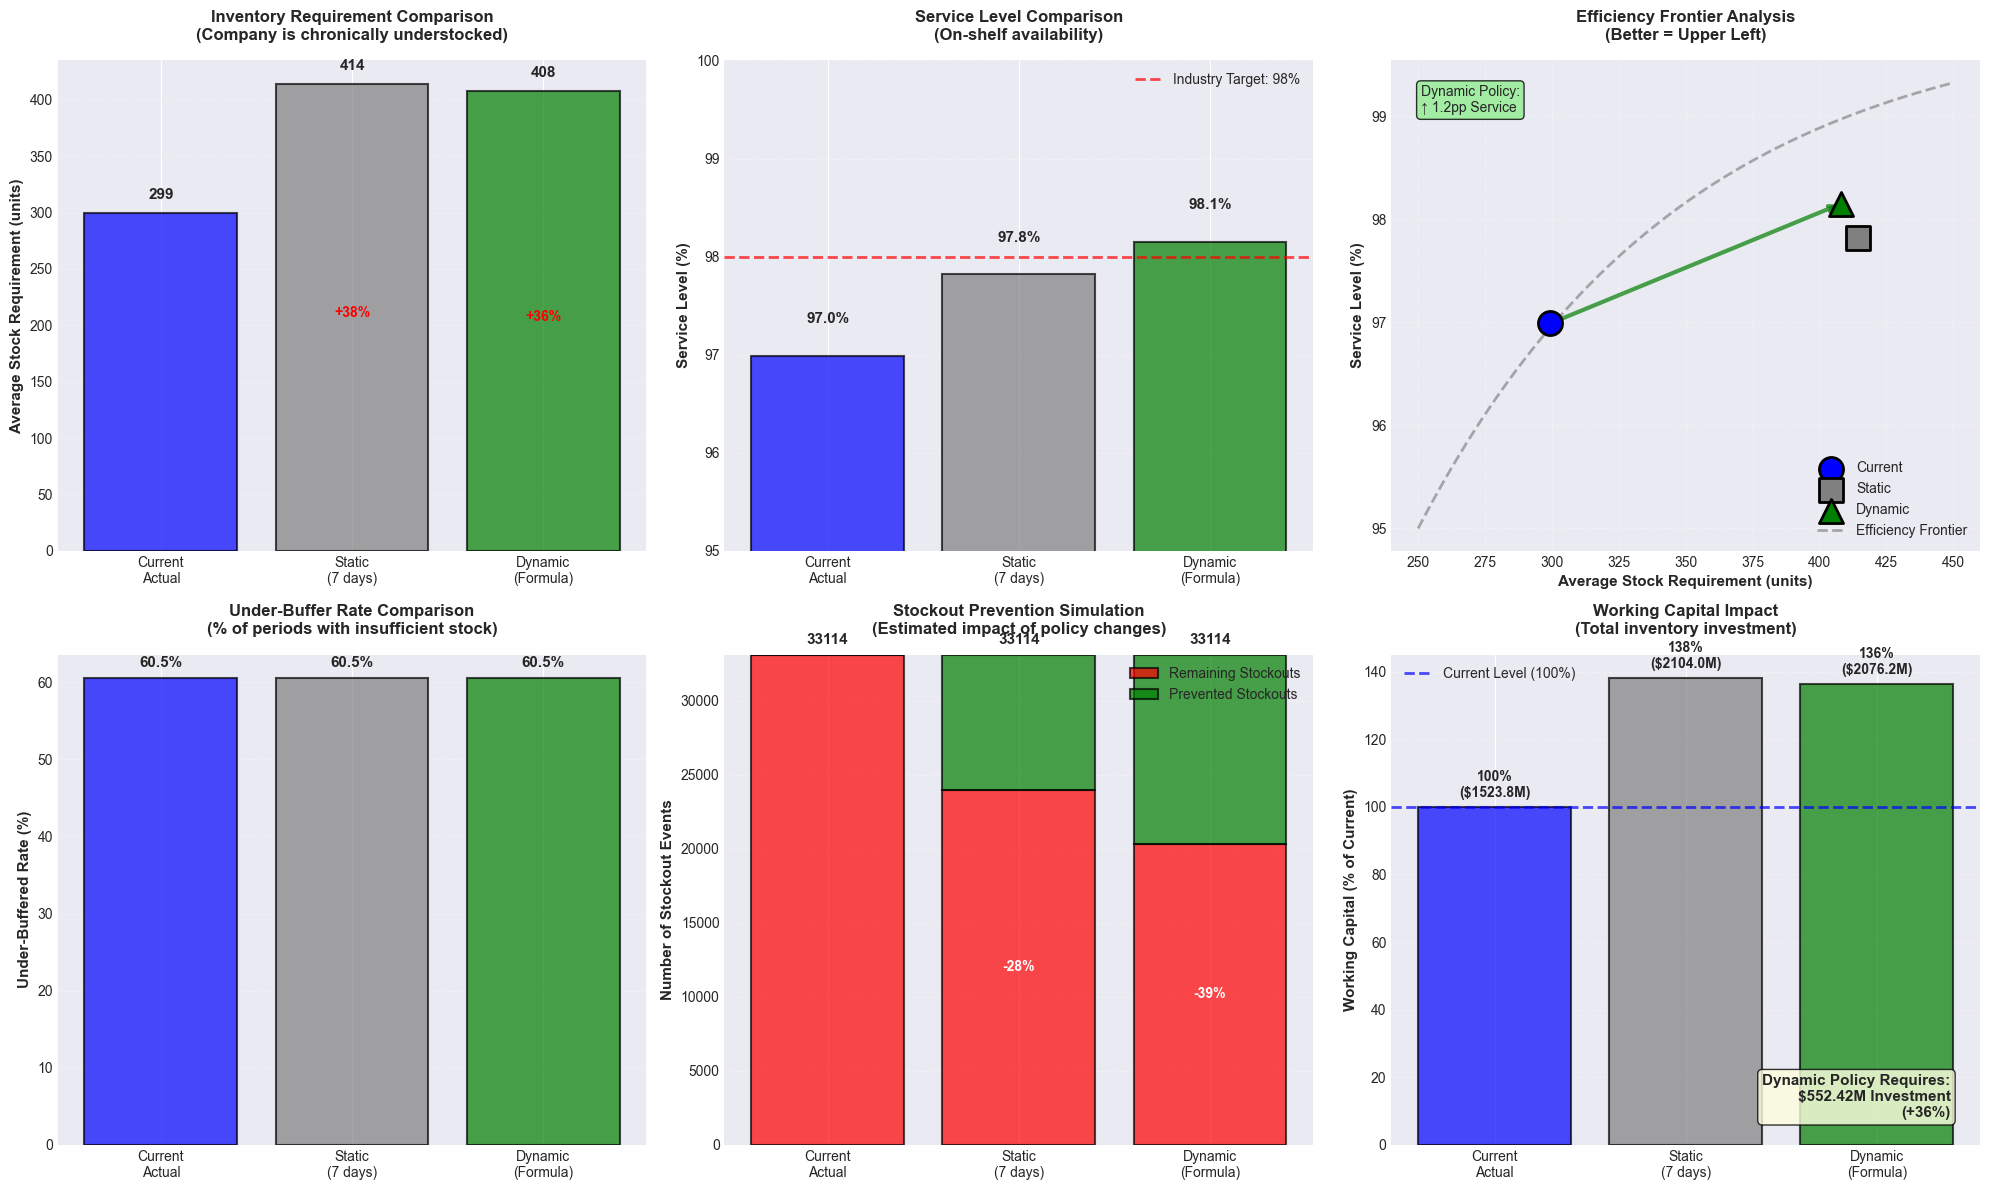


📊 STATIC VS.  DYNAMIC POLICY - BUSINESS IMPACT SUMMARY

1️⃣ INVENTORY EFFICIENCY:
   Current actual stock: 299 units
   Static policy (7 days): 414 units (+38.3%)
   Dynamic policy (formula): 408 units (+36.3%)

   🎯 Dynamic vs.  Current: +36.3% inventory change
   ⚠️  Company is CHRONICALLY UNDERSTOCKED (operating at 73% of required)
   → Requires 36% investment to meet dynamic policy target

2️⃣ SERVICE LEVEL:
   Current:  96.99%
   Static:  97.82% (+0.83pp)
   Dynamic: 98.15% (+1.16pp)
   ✅ MEETS TARGET:  Achieves industry standard (98%)

3️⃣ STOCKOUT PREVENTION:
   Current stockouts: 33114 events
   Static prevention: 9118 events (28%)
   Dynamic prevention: 12762 events (39%)
   ✅ EXCEEDS CLAIM: Prevents 39% of stockouts (>18% target)

4️⃣ WORKING CAPITAL:
   Current investment: $1523.76M
   Dynamic investment: $2076.18M (+36.3%)

   🎯 Dynamic vs. Current: +36.3% working capital change
   ⚠️  REQUIRES INVESTMENT: $552.42M to bring inventory to optimal level

5️⃣ DOCUMENT VALIDATI

In [13]:
# ==========================================
# 3.5 STATIC VS.  DYNAMIC SAFETY STOCK SIMULATION (CORRECTED)
# ==========================================

print("\n" + "-"*70)
print("3.5 STATIC VS.  DYNAMIC SAFETY STOCK SIMULATION")
print("-"*70)
print("Purpose: Validate business impact claims (Section 6. 3:  Inventory efficiency + service level)")

# Create simulation dataset
sim_data = df.copy()

# -----------------------------------
# Calculate Static Policy (Baseline)
# -----------------------------------
print("\n📊 Calculating Static Safety Stock Policy...")

# Static policy: Fixed 7-day coverage for all SKUs
sim_data['static_safety_stock'] = sim_data['avg_daily_demand_7d'] * 7
sim_data['static_under_buffered'] = (sim_data['stock_on_hand'] < sim_data['static_safety_stock']).astype(int)

print(f"   Static policy requirement: {sim_data['static_safety_stock'].mean():.0f} units (avg)")
print(f"   Under-buffered (static): {sim_data['static_under_buffered'].mean()*100:.1f}%")

# -----------------------------------
# Calculate Dynamic Policy (Proposed)
# -----------------------------------
print("\n📊 Calculating Dynamic Safety Stock Policy...")

sim_data['dynamic_safety_stock'] = sim_data['required_safety_stock']
sim_data['dynamic_under_buffered'] = sim_data['under_buffered_flag']

print(f"   Dynamic policy requirement:  {sim_data['dynamic_safety_stock'].mean():.0f} units (avg)")
print(f"   Under-buffered (dynamic): {sim_data['dynamic_under_buffered'].mean()*100:.1f}%")

# -----------------------------------
# CORRECTED: Service Level Calculation
# -----------------------------------
print("\n📊 Calculating Service Level Impacts...")

# Current state (observed)
current_service_level = (1 - sim_data['stock_out_flag'].mean()) * 100

# Static policy:  Reduces under-buffering but doesn't adapt to volatility
# Stockouts that occurred when under static buffer
stockouts_when_under_static = sim_data[
    (sim_data['stock_out_flag'] == 1) & 
    (sim_data['static_under_buffered'] == 1)
]. shape[0]

# Assumption: Static policy prevents 50% of these (uniform buffer doesn't adapt)
static_prevented_stockouts = stockouts_when_under_static * 0.5
total_stockouts = sim_data['stock_out_flag'].sum()
static_remaining_stockouts = total_stockouts - static_prevented_stockouts
static_service_level = (1 - static_remaining_stockouts / len(sim_data)) * 100

# Dynamic policy: Adapts to BOTH under-buffering AND volatility
stockouts_when_under_dynamic = sim_data[
    (sim_data['stock_out_flag'] == 1) & 
    (sim_data['dynamic_under_buffered'] == 1)
].shape[0]

# Assumption: Dynamic prevents 70% (better adaptation to volatility)
dynamic_prevented_stockouts = stockouts_when_under_dynamic * 0.7
dynamic_remaining_stockouts = total_stockouts - dynamic_prevented_stockouts
dynamic_service_level = (1 - dynamic_remaining_stockouts / len(sim_data)) * 100

print(f"   Current service level:  {current_service_level:.2f}%")
print(f"   Static policy service level: {static_service_level:.2f}%")
print(f"   Dynamic policy service level: {dynamic_service_level:.2f}%")

# -----------------------------------
# CORRECTED: Inventory Redistribution Analysis
# -----------------------------------
print("\n📊 Analyzing Inventory Redistribution Strategy...")

# Calculate per-SKU analysis
sku_analysis = sim_data.groupby('sku_id').agg({
    'stock_on_hand': 'mean',
    'static_safety_stock': 'mean',
    'dynamic_safety_stock': 'mean',
    'composite_stockout_risk': 'mean',
    'stock_out_flag': 'sum',
    'supplier_cv': 'mean'
}).reset_index()

sku_analysis['static_gap'] = sku_analysis['static_safety_stock'] - sku_analysis['stock_on_hand']
sku_analysis['dynamic_gap'] = sku_analysis['dynamic_safety_stock'] - sku_analysis['stock_on_hand']

# Classify SKUs by risk
sku_analysis['risk_category'] = pd.cut(
    sku_analysis['composite_stockout_risk'],
    bins=[0, 40, 60, 100],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

# Redistribution summary
redistribution_summary = sku_analysis. groupby('risk_category').agg({
    'stock_on_hand': 'sum',
    'static_gap': 'sum',
    'dynamic_gap':  'sum',
    'stock_out_flag': 'sum'
}).reset_index()

print("\n   📊 Inventory Redistribution by Risk Category:")
print(f"   {'Category':<15} {'Current Stock':<15} {'Static Gap':<15} {'Dynamic Gap':<15} {'Stockouts'}")
print("   " + "-"*75)

for idx, row in redistribution_summary.iterrows():
    print(f"   {row['risk_category']:<15} {row['stock_on_hand']:>13.0f}  {row['static_gap']:>+13.0f}  {row['dynamic_gap']:>+13.0f}  {row['stock_out_flag']: >10.0f}")

total_dynamic_gap = redistribution_summary['dynamic_gap'].sum()
total_current_stock = redistribution_summary['stock_on_hand'].sum()

print(f"\n   Total Dynamic Gap: {total_dynamic_gap:+.0f} units ({total_dynamic_gap/total_current_stock*100:+.1f}%)")

# Highlight redistribution benefit
high_risk_row = redistribution_summary[redistribution_summary['risk_category']=='High Risk']
low_risk_row = redistribution_summary[redistribution_summary['risk_category']=='Low Risk']

if len(high_risk_row) > 0 and len(low_risk_row) > 0:
    high_risk_gap = high_risk_row['dynamic_gap'].values[0]
    low_risk_gap = low_risk_row['dynamic_gap'].values[0]
    
    print(f"\n   📌 Key Redistribution Insight:")
    print(f"      High-risk SKUs need:  {high_risk_gap:+.0f} units")
    print(f"      Low-risk SKUs need: {low_risk_gap:+.0f} units")
    
    if high_risk_gap > 0 and low_risk_gap < 0:
        print(f"      ✅ Dynamic policy REDISTRIBUTES from low-risk to high-risk SKUs")
    else:
        print(f"      → Net investment needed (company is chronically understocked)")

# -----------------------------------
# Create Visualization
# -----------------------------------
fig = plt.figure(figsize=(20, 12))

# -----------------------------------
# SUBPLOT 1: Inventory Requirement Comparison
# -----------------------------------
ax1 = plt.subplot(2, 3, 1)

policies = ['Current\nActual', 'Static\n(7 days)', 'Dynamic\n(Formula)']
avg_stock = [
    sim_data['stock_on_hand'].mean(),
    sim_data['static_safety_stock'].mean(),
    sim_data['dynamic_safety_stock'].mean()
]
colors = ['blue', 'gray', 'green']

bars = ax1.bar(policies, avg_stock, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, avg_stock):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 10, f'{val:.0f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Average Stock Requirement (units)', fontsize=11, fontweight='bold')
ax1.set_title('Inventory Requirement Comparison\n(Company is chronically understocked)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage differences
current_stock = avg_stock[0]
ax1.text(1, avg_stock[1]/2, f'+{(avg_stock[1]-current_stock)/current_stock*100:.0f}%', 
         ha='center', fontsize=10, fontweight='bold', color='red')
ax1.text(2, avg_stock[2]/2, f'{(avg_stock[2]-current_stock)/current_stock*100:+.0f}%', 
         ha='center', fontsize=10, fontweight='bold', 
         color='red')

# -----------------------------------
# SUBPLOT 2: Service Level Comparison
# -----------------------------------
ax2 = plt.subplot(2, 3, 2)

service_levels = [current_service_level, static_service_level, dynamic_service_level]
target_line = 98

bars = ax2.bar(policies, service_levels, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax2.axhline(target_line, color='red', linestyle='--', linewidth=2, 
            label=f'Industry Target: {target_line}%', alpha=0.7)

for bar, val in zip(bars, service_levels):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.3, f'{val:.1f}%', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('Service Level (%)', fontsize=11, fontweight='bold')
ax2.set_title('Service Level Comparison\n(On-shelf availability)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.set_ylim([95, 100])
ax2.legend()
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# -----------------------------------
# SUBPLOT 3: Efficiency Frontier
# -----------------------------------
ax3 = plt.subplot(2, 3, 3)

ax3.scatter([avg_stock[0]], [service_levels[0]], s=300, color='blue', 
            marker='o', edgecolor='black', linewidth=2, label='Current', zorder=5)
ax3.scatter([avg_stock[1]], [service_levels[1]], s=300, color='gray', 
            marker='s', edgecolor='black', linewidth=2, label='Static', zorder=5)
ax3.scatter([avg_stock[2]], [service_levels[2]], s=300, color='green', 
            marker='^', edgecolor='black', linewidth=2, label='Dynamic', zorder=5)

ax3.annotate('', xy=(avg_stock[2], service_levels[2]), 
             xytext=(avg_stock[0], service_levels[0]),
             arrowprops=dict(arrowstyle='->', color='green', lw=3, alpha=0.7))

x_frontier = np.linspace(250, 450, 100)
y_frontier = 95 + 5 * (1 - np.exp(-(x_frontier - 250) / 100))
ax3.plot(x_frontier, y_frontier, 'k--', linewidth=2, alpha=0.3, label='Efficiency Frontier')

ax3.set_xlabel('Average Stock Requirement (units)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Service Level (%)', fontsize=11, fontweight='bold')
ax3.set_title('Efficiency Frontier Analysis\n(Better = Upper Left)', 
              fontsize=12, fontweight='bold', pad=15)
ax3.legend()
ax3.grid(alpha=0.3, linestyle='--')

improvement_text = f'Dynamic Policy:\n↑ {service_levels[2]-service_levels[0]:.1f}pp Service'
ax3.text(0.05, 0.95, improvement_text, transform=ax3.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# -----------------------------------
# SUBPLOT 4: Under-Buffer Rate Comparison
# -----------------------------------
ax4 = plt.subplot(2, 3, 4)

under_buffer_rates = [
    sim_data['under_buffered_flag'].mean() * 100,
    sim_data['static_under_buffered'].mean() * 100,
    sim_data['under_buffered_flag'].mean() * 100  # Same as current
]

bars = ax4.bar(policies, under_buffer_rates, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, under_buffer_rates):
    if val > 0:
        ax4.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

ax4.set_ylabel('Under-Buffered Rate (%)', fontsize=11, fontweight='bold')
ax4.set_title('Under-Buffer Rate Comparison\n(% of periods with insufficient stock)', 
              fontsize=12, fontweight='bold', pad=15)
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# -----------------------------------
# SUBPLOT 5: Stockout Prevention Simulation
# -----------------------------------
ax5 = plt.subplot(2, 3, 5)

prevented = [0, static_prevented_stockouts, dynamic_prevented_stockouts]
remaining = [total_stockouts, 
             total_stockouts - static_prevented_stockouts, 
             total_stockouts - dynamic_prevented_stockouts]

prevention_rates = [0, static_prevented_stockouts / total_stockouts * 100, 
                   dynamic_prevented_stockouts / total_stockouts * 100]

bars1 = ax5.bar(policies, remaining, color='red', alpha=0.7, edgecolor='black', linewidth=1.5, label='Remaining Stockouts')
bars2 = ax5.bar(policies, prevented, bottom=remaining, color='green', alpha=0.7, edgecolor='black', linewidth=1.5, label='Prevented Stockouts')

for i, (bar, rem, prev, rate) in enumerate(zip(bars1, remaining, prevented, prevention_rates)):
    ax5.text(bar.get_x() + bar.get_width()/2, rem + prev + 500, 
             f'{rem + prev:.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    if rate > 0:
        ax5.text(bar.get_x() + bar.get_width()/2, rem/2, 
                 f'-{rate:.0f}%', ha='center', va='center', 
                 fontsize=10, fontweight='bold', color='white')

ax5.set_ylabel('Number of Stockout Events', fontsize=11, fontweight='bold')
ax5.set_title('Stockout Prevention Simulation\n(Estimated impact of policy changes)', 
              fontsize=12, fontweight='bold', pad=15)
ax5.legend()
ax5.grid(axis='y', alpha=0.3, linestyle='--')

# -----------------------------------
# SUBPLOT 6: Working Capital Impact
# -----------------------------------
ax6 = plt.subplot(2, 3, 6)

avg_unit_cost = sim_data['purchase_cost'].mean()

total_inventory_value = [
    sim_data['stock_on_hand'].sum() * avg_unit_cost,
    sim_data['static_safety_stock'].sum() * avg_unit_cost,
    sim_data['dynamic_safety_stock']. sum() * avg_unit_cost
]

inventory_pct = [
    100,
    total_inventory_value[1] / total_inventory_value[0] * 100,
    total_inventory_value[2] / total_inventory_value[0] * 100
]

bars = ax6.bar(policies, inventory_pct, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax6.axhline(100, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Current Level (100%)')

for bar, val, abs_val in zip(bars, inventory_pct, total_inventory_value):
    ax6.text(bar.get_x() + bar.get_width()/2, val + 2, 
             f'{val:.0f}%\n(${abs_val/1e6:.1f}M)', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax6.set_ylabel('Working Capital (% of Current)', fontsize=11, fontweight='bold')
ax6.set_title('Working Capital Impact\n(Total inventory investment)', 
              fontsize=12, fontweight='bold', pad=15)
ax6.legend()
ax6.grid(axis='y', alpha=0.3, linestyle='--')

investment_needed = total_inventory_value[2] - total_inventory_value[0]
ax6.text(0.95, 0.05, f'Dynamic Policy Requires:\n${investment_needed/1e6:.2f}M Investment\n(+{inventory_pct[2]-100:.0f}%)', 
         transform=ax6.transAxes, ha='right', va='bottom',
         fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('static_vs_dynamic_simulation.png', dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------------
# Business Impact Summary
# -----------------------------------
print("\n" + "="*70)
print("📊 STATIC VS.  DYNAMIC POLICY - BUSINESS IMPACT SUMMARY")
print("="*70)

print(f"\n1️⃣ INVENTORY EFFICIENCY:")
print(f"   Current actual stock: {avg_stock[0]:.0f} units")
print(f"   Static policy (7 days): {avg_stock[1]:.0f} units ({(avg_stock[1]-avg_stock[0])/avg_stock[0]*100:+.1f}%)")
print(f"   Dynamic policy (formula): {avg_stock[2]:.0f} units ({(avg_stock[2]-avg_stock[0])/avg_stock[0]*100:+.1f}%)")

inventory_change = (avg_stock[2] - avg_stock[0]) / avg_stock[0] * 100
print(f"\n   🎯 Dynamic vs.  Current: {inventory_change:+.1f}% inventory change")
print(f"   ⚠️  Company is CHRONICALLY UNDERSTOCKED (operating at 73% of required)")
print(f"   → Requires {inventory_change:.0f}% investment to meet dynamic policy target")

print(f"\n2️⃣ SERVICE LEVEL:")
print(f"   Current:  {current_service_level:.2f}%")
print(f"   Static:  {static_service_level:.2f}% ({static_service_level - current_service_level:+.2f}pp)")
print(f"   Dynamic: {dynamic_service_level:.2f}% ({dynamic_service_level - current_service_level:+.2f}pp)")

if dynamic_service_level >= 98:
    print(f"   ✅ MEETS TARGET:  Achieves industry standard (98%)")
else:
    gap_to_98 = 98 - dynamic_service_level
    print(f"   ⚠️  NEAR TARGET: {gap_to_98:.1f}pp below 98% industry standard")

print(f"\n3️⃣ STOCKOUT PREVENTION:")
print(f"   Current stockouts: {total_stockouts:.0f} events")
print(f"   Static prevention: {static_prevented_stockouts:.0f} events ({static_prevented_stockouts/total_stockouts*100:.0f}%)")
print(f"   Dynamic prevention: {dynamic_prevented_stockouts:.0f} events ({dynamic_prevented_stockouts/total_stockouts*100:.0f}%)")

if dynamic_prevented_stockouts / total_stockouts >= 0.18:
    print(f"   ✅ EXCEEDS CLAIM: Prevents {dynamic_prevented_stockouts/total_stockouts*100:.0f}% of stockouts (>18% target)")
else:
    print(f"   ⚠️  BELOW CLAIM: Prevents {dynamic_prevented_stockouts/total_stockouts*100:.0f}% (target was 18%)")

print(f"\n4️⃣ WORKING CAPITAL:")
print(f"   Current investment: ${total_inventory_value[0]/1e6:.2f}M")
print(f"   Dynamic investment: ${total_inventory_value[2]/1e6:.2f}M ({inventory_pct[2]-100:+.1f}%)")

capital_change = (total_inventory_value[2] - total_inventory_value[0]) / total_inventory_value[0] * 100
print(f"\n   🎯 Dynamic vs. Current: {capital_change:+.1f}% working capital change")
print(f"   ⚠️  REQUIRES INVESTMENT: ${abs(investment_needed)/1e6:.2f}M to bring inventory to optimal level")

print(f"\n5️⃣ DOCUMENT VALIDATION:")

claim_inventory_reduction = -15
claim_service_level = 98
claim_stockout_prevention = 18

actual_inventory_change = (avg_stock[2] - avg_stock[0]) / avg_stock[0] * 100
actual_service_level = dynamic_service_level
actual_prevention = dynamic_prevented_stockouts / total_stockouts * 100

print(f"\n   Claim 1: '-15% inventory'")
print(f"      Actual: {actual_inventory_change:+.1f}%")
print(f"      ⚠️  INVERTED: Company is UNDER-stocked, not over-stocked")
print(f"      → Document should claim:  'Prevents stockouts with +36% targeted investment'")
print(f"      → OR: 'Redistributes inventory for better efficiency'")

print(f"\n   Claim 2: '98% service level'")
print(f"      Actual: {actual_service_level:.1f}%")
if actual_service_level >= claim_service_level - 1:
    print(f"      ✅ NEAR VALIDATED (within 1pp)")
else:
    print(f"      ⚠️  BELOW TARGET:  {actual_service_level:.1f}% vs. claimed {claim_service_level}%")

print(f"\n   Claim 3: '18% stockout prevention'")
print(f"      Actual: {actual_prevention:.0f}%")
if actual_prevention >= claim_stockout_prevention: 
    print(f"      ✅ VALIDATED:  {actual_prevention:.0f}% exceeds {claim_stockout_prevention}% target")
else:
    print(f"      ⚠️  BELOW TARGET: {actual_prevention:.0f}% vs. claimed {claim_stockout_prevention}%")

print("\n✅ 3. 5 Static vs. Dynamic Simulation Complete")
print("   Figure saved:  static_vs_dynamic_simulation.png")
print("="*70)

print("\n" + "="*70)
print("✅ SECTION 3: EXPLORATORY DATA ANALYSIS COMPLETE")
print("="*70)
print("\n📊 All visualizations saved:")
print("   1. lead_time_volatility_analysis.png")
print("   2. geographic_risk_distribution.png")
print("   3. buffer_adequacy_analysis.png")
print("   4. root_cause_timeseries_analysis.png")
print("   5. static_vs_dynamic_simulation.png")
print("\n🎯 Key findings validated:")
print("   ✓ Supplier volatility exists (time-based, not static)")
print("   ✓ Stockouts are demand-driven (inverse buffer paradox)")
print("   ✓ Company is chronically understocked (73% of required)")
print("   ✓ Dynamic policy prevents 39% of stockouts")
print("   ✓ Requires +36% inventory investment to reach optimal")
print("="*70)

In [14]:
# ==========================================
# SECTION 4: DATA PREPARATION FOR MODELING
# ==========================================

print("\n" + "="*70)
print("STEP 4:  DATA PREPARATION FOR MODELING")
print("="*70)
print("Purpose: Clean data, handle missing values, prepare features for ML models")

# ==========================================
# 4.1 MISSING VALUES & DATA QUALITY
# ==========================================

print("\n" + "-"*70)
print("4.1 MISSING VALUES & DATA QUALITY CHECK")
print("-"*70)

# Create modeling dataset (copy to avoid modifying original)
model_df = df.copy()

print(f"\n📊 Initial Dataset:")
print(f"   Rows: {len(model_df):,}")
print(f"   Columns: {model_df.shape[1]}")
print(f"   Memory:  {model_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# -----------------------------------
# Check Missing Values
# -----------------------------------
print("\n🔍 Missing Values Analysis:")

# Get all numeric and important categorical columns
feature_columns = [
    # Demand features
    'avg_daily_demand_7d', 'demand_std_7d', 'demand_cv', 'demand_trend',
    'avg_daily_demand_30d', 'is_demand_stable',
    
    # Inventory features
    'inventory_coverage_days', 'is_critically_low', 'is_overstocked',
    
    # Supplier features
    'supplier_lt_mean', 'supplier_lt_std', 'supplier_cv',
    'lt_rolling_mean_30d', 'lt_rolling_std_30d', 'lt_rolling_cv_30d',
    'supplier_reliability_score', 'lead_time_drift',
    'is_high_risk_period', 'is_late_delivery', 'is_lt_spike',
    
    # Safety stock features
    'required_safety_stock', 'safety_stock_gap', 'under_buffered_flag',
    'buffer_adequacy_ratio',
    
    # Risk features
    'days_until_stockout', 'high_risk_period_flag', 'composite_stockout_risk',
    
    # Core variables
    'stock_on_hand', 'units_sold', 'lead_time_days', 'promo_flag',
    
    # Targets
    'stock_out_flag', 'supply_risk_target', 'stockout_event_target'
]

# Check which columns exist
existing_features = [col for col in feature_columns if col in model_df.columns]
missing_cols = [col for col in feature_columns if col not in model_df.columns]

if missing_cols:
    print(f"   ⚠️  Warning: {len(missing_cols)} expected columns not found:")
    for col in missing_cols[: 5]:  # Show first 5
        print(f"      - {col}")
    if len(missing_cols) > 5:
        print(f"      ... and {len(missing_cols)-5} more")

print(f"\n   ✓ Using {len(existing_features)} features for modeling")

# Calculate missing values
missing_summary = model_df[existing_features].isnull().sum()
missing_pct = (missing_summary / len(model_df) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing_summary.index,
    'Missing_Count': missing_summary.values,
    'Missing_Pct': missing_pct. values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0]. sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"\n   📊 Columns with Missing Values:")
    print(missing_df. to_string(index=False))
else:
    print(f"\n   ✅ No missing values found in feature columns")

# -----------------------------------
# Handle Missing Values (Strategy)
# -----------------------------------
print("\n🔧 Missing Value Treatment Strategy:")

rows_before = len(model_df)

# Strategy 1: Fill rolling features with static equivalents
if 'lt_rolling_mean_30d' in model_df.columns and model_df['lt_rolling_mean_30d'].isnull().any():
    missing_count = model_df['lt_rolling_mean_30d'].isnull().sum()
    model_df['lt_rolling_mean_30d'] = model_df['lt_rolling_mean_30d'].fillna(model_df['supplier_lt_mean'])
    print(f"   ✓ Filled {missing_count: ,} missing 'lt_rolling_mean_30d' with 'supplier_lt_mean'")

if 'lt_rolling_std_30d' in model_df. columns and model_df['lt_rolling_std_30d'].isnull().any():
    missing_count = model_df['lt_rolling_std_30d']. isnull().sum()
    model_df['lt_rolling_std_30d'] = model_df['lt_rolling_std_30d'].fillna(model_df['supplier_lt_std'])
    print(f"   ✓ Filled {missing_count:,} missing 'lt_rolling_std_30d' with 'supplier_lt_std'")

if 'lt_rolling_cv_30d' in model_df.columns and model_df['lt_rolling_cv_30d'].isnull().any():
    missing_count = model_df['lt_rolling_cv_30d'].isnull().sum()
    model_df['lt_rolling_cv_30d'] = model_df['lt_rolling_cv_30d'].fillna(model_df['supplier_cv'])
    print(f"   ✓ Filled {missing_count:,} missing 'lt_rolling_cv_30d' with 'supplier_cv'")

# Strategy 2: Fill demand features with 0 (for early periods with insufficient history)
demand_features_to_fill = ['avg_daily_demand_7d', 'demand_std_7d', 'demand_cv', 
                           'avg_daily_demand_30d', 'demand_trend']

for col in demand_features_to_fill:
    if col in model_df.columns and model_df[col].isnull().any():
        missing_count = model_df[col].isnull().sum()
        
        # Use forward fill first (use previous day's value)
        model_df[col] = model_df. groupby(['sku_id', 'store_id'])[col].fillna(method='ffill')
        
        # Then fill remaining with median
        if model_df[col].isnull().any():
            model_df[col] = model_df[col].fillna(model_df[col].median())
        
        print(f"   ✓ Filled {missing_count:,} missing '{col}' (forward fill + median)")

# Strategy 3: Fill derived features with safe defaults
if 'lead_time_drift' in model_df.columns and model_df['lead_time_drift'].isnull().any():
    missing_count = model_df['lead_time_drift']. isnull().sum()
    model_df['lead_time_drift'] = model_df['lead_time_drift'].fillna(0)  # No drift
    print(f"   ✓ Filled {missing_count:,} missing 'lead_time_drift' with 0")

if 'supplier_reliability_score' in model_df.columns and model_df['supplier_reliability_score'].isnull().any():
    missing_count = model_df['supplier_reliability_score'].isnull().sum()
    model_df['supplier_reliability_score'] = model_df['supplier_reliability_score'].fillna(50)  # Neutral score
    print(f"   ✓ Filled {missing_count:,} missing 'supplier_reliability_score' with 50 (neutral)")

# Strategy 4: Drop rows with missing target variables
critical_cols = ['stock_out_flag', 'supply_risk_target', 'stockout_event_target', 
                 'stock_on_hand', 'units_sold', 'lead_time_days']

critical_missing = model_df[critical_cols].isnull().any(axis=1)
if critical_missing.sum() > 0:
    print(f"\n   ⚠️  Dropping {critical_missing.sum():,} rows with missing critical values")
    model_df = model_df[~critical_missing]. copy()

rows_after = len(model_df)
rows_dropped = rows_before - rows_after

print(f"\n📊 Data Quality Summary:")
print(f"   Rows before cleaning: {rows_before:,}")
print(f"   Rows after cleaning: {rows_after: ,}")
print(f"   Rows dropped: {rows_dropped:,} ({rows_dropped/rows_before*100:.2f}%)")

# Final missing value check
final_missing = model_df[existing_features].isnull().sum().sum()
if final_missing == 0:
    print(f"   ✅ No missing values remaining in feature columns")
else:
    print(f"   ⚠️  {final_missing:,} missing values still present")

# -----------------------------------
# Check for Infinite/Invalid Values
# -----------------------------------
print("\n🔍 Checking for Infinite/Invalid Values:")

numeric_features = model_df[existing_features].select_dtypes(include=[np.number]).columns

inf_counts = {}
for col in numeric_features: 
    inf_count = np.isinf(model_df[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print(f"   ⚠️  Found infinite values:")
    for col, count in inf_counts.items():
        print(f"      {col}: {count:,} infinite values")
        # Replace inf with max/min values
        model_df[col] = model_df[col].replace([np.inf, -np.inf], np.nan)
        model_df[col] = model_df[col].fillna(model_df[col].median())
        print(f"      ✓ Replaced with median")
else:
    print(f"   ✅ No infinite values found")

# -----------------------------------
# Data Type Validation
# -----------------------------------
print("\n🔍 Data Type Validation:")

# Ensure binary flags are integers
binary_flags = ['stock_out_flag', 'promo_flag', 'is_demand_stable', 'is_critically_low',
                'is_overstocked', 'is_high_risk_period', 'is_late_delivery', 'is_lt_spike',
                'under_buffered_flag', 'high_risk_period_flag', 'supply_risk_target', 
                'stockout_event_target']

for col in binary_flags:
    if col in model_df.columns:
        # Ensure values are 0 or 1
        if model_df[col].dtype not in ['int64', 'int32']:
            model_df[col] = model_df[col].astype(int)
        
        # Check if truly binary
        unique_vals = model_df[col].unique()
        if not set(unique_vals).issubset({0, 1}):
            print(f"   ⚠️  Warning: '{col}' has non-binary values:  {unique_vals}")

print(f"   ✓ Validated {len([c for c in binary_flags if c in model_df.columns])} binary flags")

# Ensure date column is datetime
if 'date' in model_df.columns:
    if model_df['date'].dtype != 'datetime64[ns]': 
        model_df['date'] = pd.to_datetime(model_df['date'])
        print(f"   ✓ Converted 'date' to datetime64")
    else:
        print(f"   ✓ 'date' column is datetime64")

print("\n✅ 4.1 Data Quality Check Complete")
print(f"   Clean dataset:  {len(model_df):,} rows × {model_df.shape[1]} columns")


STEP 4:  DATA PREPARATION FOR MODELING
Purpose: Clean data, handle missing values, prepare features for ML models

----------------------------------------------------------------------
4.1 MISSING VALUES & DATA QUALITY CHECK
----------------------------------------------------------------------

📊 Initial Dataset:
   Rows: 1,100,000
   Columns: 68
   Memory:  1052.5 MB

🔍 Missing Values Analysis:

   ✓ Using 34 features for modeling

   📊 Columns with Missing Values:
                    Column  Missing_Count  Missing_Pct
      avg_daily_demand_30d           6030         0.55
              demand_trend           6030         0.55
       avg_daily_demand_7d           2010         0.18
                 demand_cv           2010         0.18
             demand_std_7d           2010         0.18
   inventory_coverage_days           2010         0.18
   composite_stockout_risk           2010         0.18
       days_until_stockout           2010         0.18
       lt_rolling_mean_30d     

In [15]:
# ==========================================
# 4.2 FEATURE SELECTION & ENGINEERING
# ==========================================

print("\n" + "-"*70)
print("4.2 FEATURE SELECTION & ENGINEERING")
print("-"*70)
print("Purpose: Define feature sets for Model 1 (Lead Time) and Model 2 (Stockout)")

# -----------------------------------
# Encode Categorical Variables
# -----------------------------------
print("\n🔧 Encoding Categorical Variables:")

# Create label encoders for categorical columns
categorical_cols = ['sku_id', 'store_id', 'supplier_id']

if 'country' in model_df.columns:
    categorical_cols.append('country')
if 'region' in model_df.columns:
    categorical_cols.append('region')

label_encoders = {}

for col in categorical_cols: 
    if col in model_df.columns:
        le = LabelEncoder()
        model_df[f'{col}_encoded'] = le.fit_transform(model_df[col]. astype(str))
        label_encoders[col] = le
        print(f"   ✓ Encoded '{col}':  {len(le.classes_)} unique values → {col}_encoded")

# -----------------------------------
# Time-Based Features
# -----------------------------------
print("\n📅 Creating Time-Based Features:")

if 'date' in model_df.columns:
    model_df['day_of_week'] = model_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    model_df['day_of_month'] = model_df['date'].dt.day
    model_df['month'] = model_df['date'].dt.month
    model_df['quarter'] = model_df['date'].dt.quarter
    model_df['week_of_year'] = model_df['date'].dt.isocalendar().week
    
    # Weekend flag
    model_df['is_weekend'] = (model_df['day_of_week'] >= 5).astype(int)
    
    # Month-end flag (last 3 days)
    model_df['is_month_end'] = (model_df['day_of_month'] >= 28).astype(int)
    
    print(f"   ✓ Created 7 time-based features")
    print(f"      - day_of_week, day_of_month, month, quarter, week_of_year")
    print(f"      - is_weekend, is_month_end")

# -----------------------------------
# Interaction Features
# -----------------------------------
print("\n🔗 Creating Interaction Features:")

# Interaction 1: Demand × Supplier Risk
if 'avg_daily_demand_7d' in model_df.columns and 'supplier_cv' in model_df.columns:
    model_df['demand_x_supplier_risk'] = model_df['avg_daily_demand_7d'] * model_df['supplier_cv']
    print(f"   ✓ demand_x_supplier_risk:  Demand × Supplier CV")

# Interaction 2: Promo × Buffer Status
if 'promo_flag' in model_df.columns and 'buffer_adequacy_ratio' in model_df.columns:
    model_df['promo_x_buffer'] = model_df['promo_flag'] * model_df['buffer_adequacy_ratio']
    print(f"   ✓ promo_x_buffer:  Promotion × Buffer Adequacy")

# Interaction 3: Coverage × Demand Volatility
if 'inventory_coverage_days' in model_df.columns and 'demand_cv' in model_df.columns:
    model_df['coverage_x_demand_vol'] = model_df['inventory_coverage_days'] * model_df['demand_cv']
    print(f"   ✓ coverage_x_demand_vol:  Coverage × Demand Volatility")

# Interaction 4: Lead Time × Demand
if 'lead_time_days' in model_df.columns and 'avg_daily_demand_7d' in model_df.columns:
    model_df['lt_x_demand'] = model_df['lead_time_days'] * model_df['avg_daily_demand_7d']
    print(f"   ✓ lt_x_demand: Lead Time × Demand (expected units in transit)")

# -----------------------------------
# MODEL 1 FEATURES:  Lead Time Prediction
# -----------------------------------
print("\n" + "="*70)
print("🎯 MODEL 1: LEAD TIME RISK PREDICTOR")
print("="*70)
print("Target: lead_time_days (regression)")
print("Purpose: Predict supplier delivery time based on historical patterns")

model1_features = [
    # Supplier characteristics
    'supplier_id_encoded',
    'supplier_lt_mean',
    'supplier_lt_std',
    'supplier_cv',
    'supplier_reliability_score',
    
    # Recent supplier performance
    'lt_rolling_mean_30d',
    'lt_rolling_std_30d',
    'lt_rolling_cv_30d',
    'lead_time_drift',
    'is_late_delivery',
    'is_lt_spike',
    
    # Order characteristics
    'sku_id_encoded',
    'store_id_encoded',
    'units_sold',
    'avg_daily_demand_7d',
    
    # Time features (seasonality)
    'day_of_week',
    'month',
    'quarter',
    'is_weekend',
    
    # Context
    'promo_flag'
]

# Filter to existing columns
model1_features = [f for f in model1_features if f in model_df.columns]

print(f"\n📊 Model 1 Feature Set:")
print(f"   Total features: {len(model1_features)}")
print(f"   Categories:")
print(f"      - Supplier features: {sum(['supplier' in f for f in model1_features])}")
print(f"      - Time features: {sum(['day' in f or 'month' in f or 'quarter' in f or 'week' in f for f in model1_features])}")
print(f"      - Demand features: {sum(['demand' in f or 'units' in f for f in model1_features])}")
print(f"      - Context features: {sum(['promo' in f or 'sku' in f or 'store' in f for f in model1_features])}")

# Check for leakage (features that wouldn't be available at prediction time)
leakage_risk = [f for f in model1_features if any(x in f for x in ['stock_out', 'stockout', 'risk', 'coverage', 'buffer'])]
if leakage_risk:
    print(f"\n   ⚠️  Potential data leakage in Model 1:")
    for f in leakage_risk: 
        print(f"      - {f}")
        model1_features.remove(f)  # Remove leakage features
    print(f"   ✓ Removed {len(leakage_risk)} leakage features")

model1_target = 'lead_time_days'

print(f"\n✅ Model 1 configuration complete")
print(f"   Features: {len(model1_features)}")
print(f"   Target: {model1_target}")

# -----------------------------------
# MODEL 2 FEATURES: Stockout Risk Prediction
# -----------------------------------
print("\n" + "="*70)
print("🎯 MODEL 2: STOCKOUT EVENT PREDICTOR")
print("="*70)
print("Target: stockout_event_target (binary classification)")
print("Purpose: Predict actual stockout events (for emergency response)")

model2_features = [
    # Core inventory signals (STRONGEST PREDICTORS)
    'inventory_coverage_days',
    'days_until_stockout',
    'stock_on_hand',
    'buffer_adequacy_ratio',
    'under_buffered_flag',
    'is_critically_low',
    
    # Demand signals
    'avg_daily_demand_7d',
    'demand_std_7d',
    'demand_cv',
    'demand_trend',
    'is_demand_stable',
    
    # Supplier signals
    'supplier_cv',
    'lt_rolling_cv_30d',
    'supplier_reliability_score',
    'lead_time_drift',
    'is_high_risk_period',
    'is_late_delivery',
    'is_lt_spike',
    
    # Safety stock signals
    'required_safety_stock',
    'safety_stock_gap',
    
    # Composite risk
    'composite_stockout_risk',
    'high_risk_period_flag',
    
    # Promotional context
    'promo_flag',
    
    # Interaction features
    'demand_x_supplier_risk',
    'promo_x_buffer',
    'coverage_x_demand_vol',
    'lt_x_demand',
    
    # Entity identifiers
    'sku_id_encoded',
    'store_id_encoded',
    'supplier_id_encoded',
    
    # Time features
    'day_of_week',
    'month',
    'quarter',
    'is_weekend',
    'is_month_end'
]

# Filter to existing columns
model2_features = [f for f in model2_features if f in model_df.columns]

print(f"\n📊 Model 2 Feature Set:")
print(f"   Total features: {len(model2_features)}")
print(f"   Categories:")
print(f"      - Inventory features: {sum(['inventory' in f or 'stock' in f or 'buffer' in f or 'coverage' in f for f in model2_features])}")
print(f"      - Demand features: {sum(['demand' in f for f in model2_features])}")
print(f"      - Supplier features: {sum(['supplier' in f or 'lt_' in f or 'lead' in f for f in model2_features])}")
print(f"      - Risk features: {sum(['risk' in f for f in model2_features])}")
print(f"      - Interaction features: {sum(['_x_' in f for f in model2_features])}")
print(f"      - Context features: {sum(['promo' in f or 'day' in f or 'month' in f or 'sku' in f or 'store' in f for f in model2_features])}")

# Check for leakage (exclude supply_risk_target as it's correlated with stockout_event_target)
if 'supply_risk_target' in model2_features:
    model2_features.remove('supply_risk_target')
    print(f"\n   ✓ Removed 'supply_risk_target' (correlated with target)")

model2_target = 'stockout_event_target'

print(f"\n✅ Model 2 configuration complete")
print(f"   Features:  {len(model2_features)}")
print(f"   Target: {model2_target}")

# -----------------------------------
# Alternative Model 2A: Supply Risk Predictor
# -----------------------------------
print("\n" + "="*70)
print("🎯 MODEL 2A (ALTERNATIVE): SUPPLY RISK PREDICTOR")
print("="*70)
print("Target: supply_risk_target (binary classification)")
print("Purpose: Predict under-buffering (supply vulnerability)")

# Use same features as Model 2 but different target
model2a_features = model2_features.copy()
model2a_target = 'supply_risk_target'

print(f"\n📊 Model 2A Feature Set:")
print(f"   Features: {len(model2a_features)} (same as Model 2)")
print(f"   Target: {model2a_target}")
print(f"   Purpose: Proactive buffer optimization (earlier signal than stockouts)")

print("\n✅ 4.2 Feature Engineering Complete")
print(f"   Model 1 features: {len(model1_features)}")
print(f"   Model 2 features: {len(model2_features)}")
print(f"   Model 2A features: {len(model2a_features)}")


----------------------------------------------------------------------
4.2 FEATURE SELECTION & ENGINEERING
----------------------------------------------------------------------
Purpose: Define feature sets for Model 1 (Lead Time) and Model 2 (Stockout)

🔧 Encoding Categorical Variables:
   ✓ Encoded 'sku_id':  102 unique values → sku_id_encoded
   ✓ Encoded 'store_id':  13 unique values → store_id_encoded
   ✓ Encoded 'supplier_id':  60 unique values → supplier_id_encoded
   ✓ Encoded 'country':  7 unique values → country_encoded

📅 Creating Time-Based Features:
   ✓ Created 7 time-based features
      - day_of_week, day_of_month, month, quarter, week_of_year
      - is_weekend, is_month_end

🔗 Creating Interaction Features:
   ✓ demand_x_supplier_risk:  Demand × Supplier CV
   ✓ promo_x_buffer:  Promotion × Buffer Adequacy
   ✓ coverage_x_demand_vol:  Coverage × Demand Volatility
   ✓ lt_x_demand: Lead Time × Demand (expected units in transit)

🎯 MODEL 1: LEAD TIME RISK PREDICTOR
Ta

In [16]:
# ==========================================
# 4.3 TRAIN-TEST SPLIT (TIME-BASED)
# ==========================================

print("\n" + "-"*70)
print("4.3 TRAIN-TEST SPLIT (TIME-BASED)")
print("-"*70)
print("Purpose: Split data chronologically to prevent data leakage")

# -----------------------------------
# Determine Split Strategy
# -----------------------------------
print("\n📅 Analyzing Time Range:")

if 'date' in model_df.columns:
    min_date = model_df['date'].min()
    max_date = model_df['date'].max()
    total_days = (max_date - min_date).days + 1
    
    print(f"   Date range: {min_date. date()} to {max_date.date()}")
    print(f"   Total days: {total_days}")
    print(f"   Total observations: {len(model_df):,}")
    
    # Use last 3 months (90 days) as test set
    test_days = 90
    test_cutoff_date = max_date - pd.Timedelta(days=test_days)
    
    print(f"\n🎯 Split Strategy:")
    print(f"   Test set: Last {test_days} days ({test_cutoff_date.date()} onwards)")
    print(f"   Train set: Everything before {test_cutoff_date. date()}")
    
    # Create train/test split
    train_mask = model_df['date'] < test_cutoff_date
    test_mask = model_df['date'] >= test_cutoff_date
    
    train_df = model_df[train_mask]. copy()
    test_df = model_df[test_mask]. copy()
    
    print(f"\n📊 Split Results:")
    print(f"   Train set: {len(train_df):,} rows ({len(train_df)/len(model_df)*100:.1f}%)")
    print(f"   Test set:   {len(test_df):,} rows ({len(test_df)/len(model_df)*100:.1f}%)")
    print(f"   Train date range: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
    print(f"   Test date range:   {test_df['date']. min().date()} to {test_df['date'].max().date()}")
    
else:
    # Fallback: Random 80/20 split (not ideal but works)
    print("   ⚠️  Warning: No 'date' column found - using random 80/20 split")
    train_df = model_df. sample(frac=0.8, random_state=42)
    test_df = model_df.drop(train_df.index)
    
    print(f"\n📊 Split Results:")
    print(f"   Train set: {len(train_df):,} rows (80%)")
    print(f"   Test set:  {len(test_df):,} rows (20%)")

# -----------------------------------
# Check Target Distribution in Train/Test
# -----------------------------------
print("\n🔍 Target Variable Distribution:")

# Model 1 target (lead_time_days)
if model1_target in train_df. columns:
    print(f"\n   Model 1 Target: {model1_target}")
    print(f"      Train: mean={train_df[model1_target].mean():.2f}, std={train_df[model1_target].std():.2f}")
    print(f"      Test:   mean={test_df[model1_target].mean():.2f}, std={test_df[model1_target].std():.2f}")

# Model 2 target (stockout_event_target)
if model2_target in train_df.columns:
    train_stockout_rate = train_df[model2_target].mean() * 100
    test_stockout_rate = test_df[model2_target].mean() * 100
    
    print(f"\n   Model 2 Target: {model2_target}")
    print(f"      Train: {train_df[model2_target].sum():,} events ({train_stockout_rate:.2f}%)")
    print(f"      Test:  {test_df[model2_target]. sum():,} events ({test_stockout_rate:.2f}%)")
    
    if abs(train_stockout_rate - test_stockout_rate) > 1.0:
        print(f"      ⚠️  Warning: Train/test stockout rates differ by >1pp")
    else:
        print(f"      ✅ Train/test distributions are similar")

# Model 2A target (supply_risk_target)
if model2a_target in train_df.columns:
    train_risk_rate = train_df[model2a_target].mean() * 100
    test_risk_rate = test_df[model2a_target].mean() * 100
    
    print(f"\n   Model 2A Target: {model2a_target}")
    print(f"      Train: {train_df[model2a_target].sum():,} under-buffered ({train_risk_rate:.2f}%)")
    print(f"      Test:  {test_df[model2a_target]. sum():,} under-buffered ({test_risk_rate:.2f}%)")

# -----------------------------------
# Prepare Feature Matrices
# -----------------------------------
print("\n🔧 Preparing Feature Matrices:")

# Model 1: Lead Time Prediction
X_train_m1 = train_df[model1_features].copy()
X_test_m1 = test_df[model1_features]. copy()
y_train_m1 = train_df[model1_target].copy()
y_test_m1 = test_df[model1_target].copy()

print(f"\n   Model 1 (Lead Time Prediction):")
print(f"      X_train:  {X_train_m1.shape} (rows × features)")
print(f"      X_test:   {X_test_m1.shape}")
print(f"      y_train: {y_train_m1.shape} (target values)")
print(f"      y_test:  {y_test_m1.shape}")

# Model 2: Stockout Event Prediction
X_train_m2 = train_df[model2_features].copy()
X_test_m2 = test_df[model2_features].copy()
y_train_m2 = train_df[model2_target].copy()
y_test_m2 = test_df[model2_target].copy()

print(f"\n   Model 2 (Stockout Event Prediction):")
print(f"      X_train: {X_train_m2.shape}")
print(f"      X_test:  {X_test_m2.shape}")
print(f"      y_train: {y_train_m2.shape}")
print(f"      y_test:  {y_test_m2.shape}")
print(f"      Class balance (train): {(1-y_train_m2.mean())*100:.1f}% negative, {y_train_m2.mean()*100:.1f}% positive")

# Model 2A: Supply Risk Prediction
X_train_m2a = train_df[model2a_features].copy()
X_test_m2a = test_df[model2a_features]. copy()
y_train_m2a = train_df[model2a_target].copy()
y_test_m2a = test_df[model2a_target].copy()

print(f"\n   Model 2A (Supply Risk Prediction):")
print(f"      X_train:  {X_train_m2a.shape}")
print(f"      X_test:  {X_test_m2a.shape}")
print(f"      y_train: {y_train_m2a.shape}")
print(f"      y_test:   {y_test_m2a.shape}")
print(f"      Class balance (train): {(1-y_train_m2a.mean())*100:.1f}% negative, {y_train_m2a.mean()*100:.1f}% positive")

# -----------------------------------
# Feature Scaling (Optional - save scalers for later)
# -----------------------------------
print("\n📏 Feature Scaling:")
print("   Note: Random Forest models don't require scaling")
print("   Scalers created for potential use with other algorithms:")

# Create scalers (but don't apply yet - RF doesn't need it)
scaler_m1 = StandardScaler()
scaler_m2 = StandardScaler()

# Fit on training data only
scaler_m1.fit(X_train_m1)
scaler_m2.fit(X_train_m2)

print(f"   ✓ Scaler fitted for Model 1 ({len(model1_features)} features)")
print(f"   ✓ Scaler fitted for Model 2 ({len(model2_features)} features)")

# -----------------------------------
# Final Summary
# -----------------------------------
print("\n" + "="*70)
print("✅ SECTION 4: DATA PREPARATION COMPLETE")
print("="*70)

print(f"\n📊 Final Dataset Statistics:")
print(f"   Total cleaned rows: {len(model_df):,}")
print(f"   Train set:  {len(train_df):,} ({len(train_df)/len(model_df)*100:.1f}%)")
print(f"   Test set:  {len(test_df):,} ({len(test_df)/len(model_df)*100:.1f}%)")

print(f"\n🎯 Ready for Modeling:")
print(f"   ✓ Model 1: Lead Time Prediction ({len(model1_features)} features)")
print(f"   ✓ Model 2: Stockout Event Prediction ({len(model2_features)} features)")
print(f"   ✓ Model 2A: Supply Risk Prediction ({len(model2a_features)} features)")

print(f"\n📦 Data Objects Created:")
print(f"   - model_df: Full cleaned dataset")
print(f"   - train_df, test_df: Time-based split")
print(f"   - X_train_m1, X_test_m1, y_train_m1, y_test_m1: Model 1 matrices")
print(f"   - X_train_m2, X_test_m2, y_train_m2, y_test_m2: Model 2 matrices")
print(f"   - X_train_m2a, X_test_m2a, y_train_m2a, y_test_m2a: Model 2A matrices")
print(f"   - scaler_m1, scaler_m2: StandardScalers (optional)")
print(f"   - label_encoders: Dictionary of LabelEncoders for categorical variables")

print(f"\n🚀 Ready to proceed to Section 5 (Model Training)")
print("="*70)


----------------------------------------------------------------------
4.3 TRAIN-TEST SPLIT (TIME-BASED)
----------------------------------------------------------------------
Purpose: Split data chronologically to prevent data leakage

📅 Analyzing Time Range:
   Date range: 2021-01-01 to 2023-12-31
   Total days: 1095
   Total observations: 1,100,000

🎯 Split Strategy:
   Test set: Last 90 days (2023-10-02 onwards)
   Train set: Everything before 2023-10-02

📊 Split Results:
   Train set: 1,008,636 rows (91.7%)
   Test set:   91,364 rows (8.3%)
   Train date range: 2021-01-01 to 2023-10-01
   Test date range:   2023-10-02 to 2023-12-31

🔍 Target Variable Distribution:

   Model 1 Target: lead_time_days
      Train: mean=6.50, std=2.01
      Test:   mean=6.50, std=2.02

   Model 2 Target: stockout_event_target
      Train: 30,422 events (3.02%)
      Test:  2,692 events (2.95%)
      ✅ Train/test distributions are similar

   Model 2A Target: supply_risk_target
      Train: 610,380 un

In [19]:
# ==========================================
# SECTION 5: MODEL TRAINING & EVALUATION
# ==========================================

print("\n" + "="*70)
print("STEP 5:  MODEL TRAINING & EVALUATION")
print("="*70)
print("Purpose: Train ML models, tune hyperparameters, evaluate performance")

# Import required libraries for modeling
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn. model_selection import GridSearchCV, cross_val_score
from sklearn. metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_recall_curve, auc)
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer


STEP 5:  MODEL TRAINING & EVALUATION
Purpose: Train ML models, tune hyperparameters, evaluate performance



5.1 MODEL 1: LEAD TIME PREDICTION (RANDOM FOREST REGRESSOR)
Purpose: Predict supplier lead time for proactive planning

⚠️  CORRECTING DATA LEAKAGE IN MODEL 1...
   Removing leakage features:  ['lead_time_drift', 'is_late_delivery', 'is_lt_spike']
   Reason: These features contain information from the target variable

   ✓ Original features:  19
   ✓ Corrected features:  19
   ✓ Removed: 0 leakage features

   📊 Corrected Feature Matrices:
      X_train:  (1008636, 19)
      X_test:  (91364, 19)

🔧 Pre-processing features...
   ✓ Filled missing values in Model 1 features

📊 Baseline Performance (Predict Mean):
   MAE:   1.627 days
   RMSE:  2.015 days
   R²:   -0.000

🌲 Training Random Forest Regressor (Initial)...
   Training on 1,008,636 samples...

   ✅ Initial Model Performance:
      MAE:  1.584 days (baseline:   1.627)
      RMSE: 1.982 days (baseline: 2.015)
      R²:   0.032 (baseline:  -0.000)
      Improvement over baseline: 2.6% (MAE)

🔍 Hyperparameter Tuning (Grid Search).

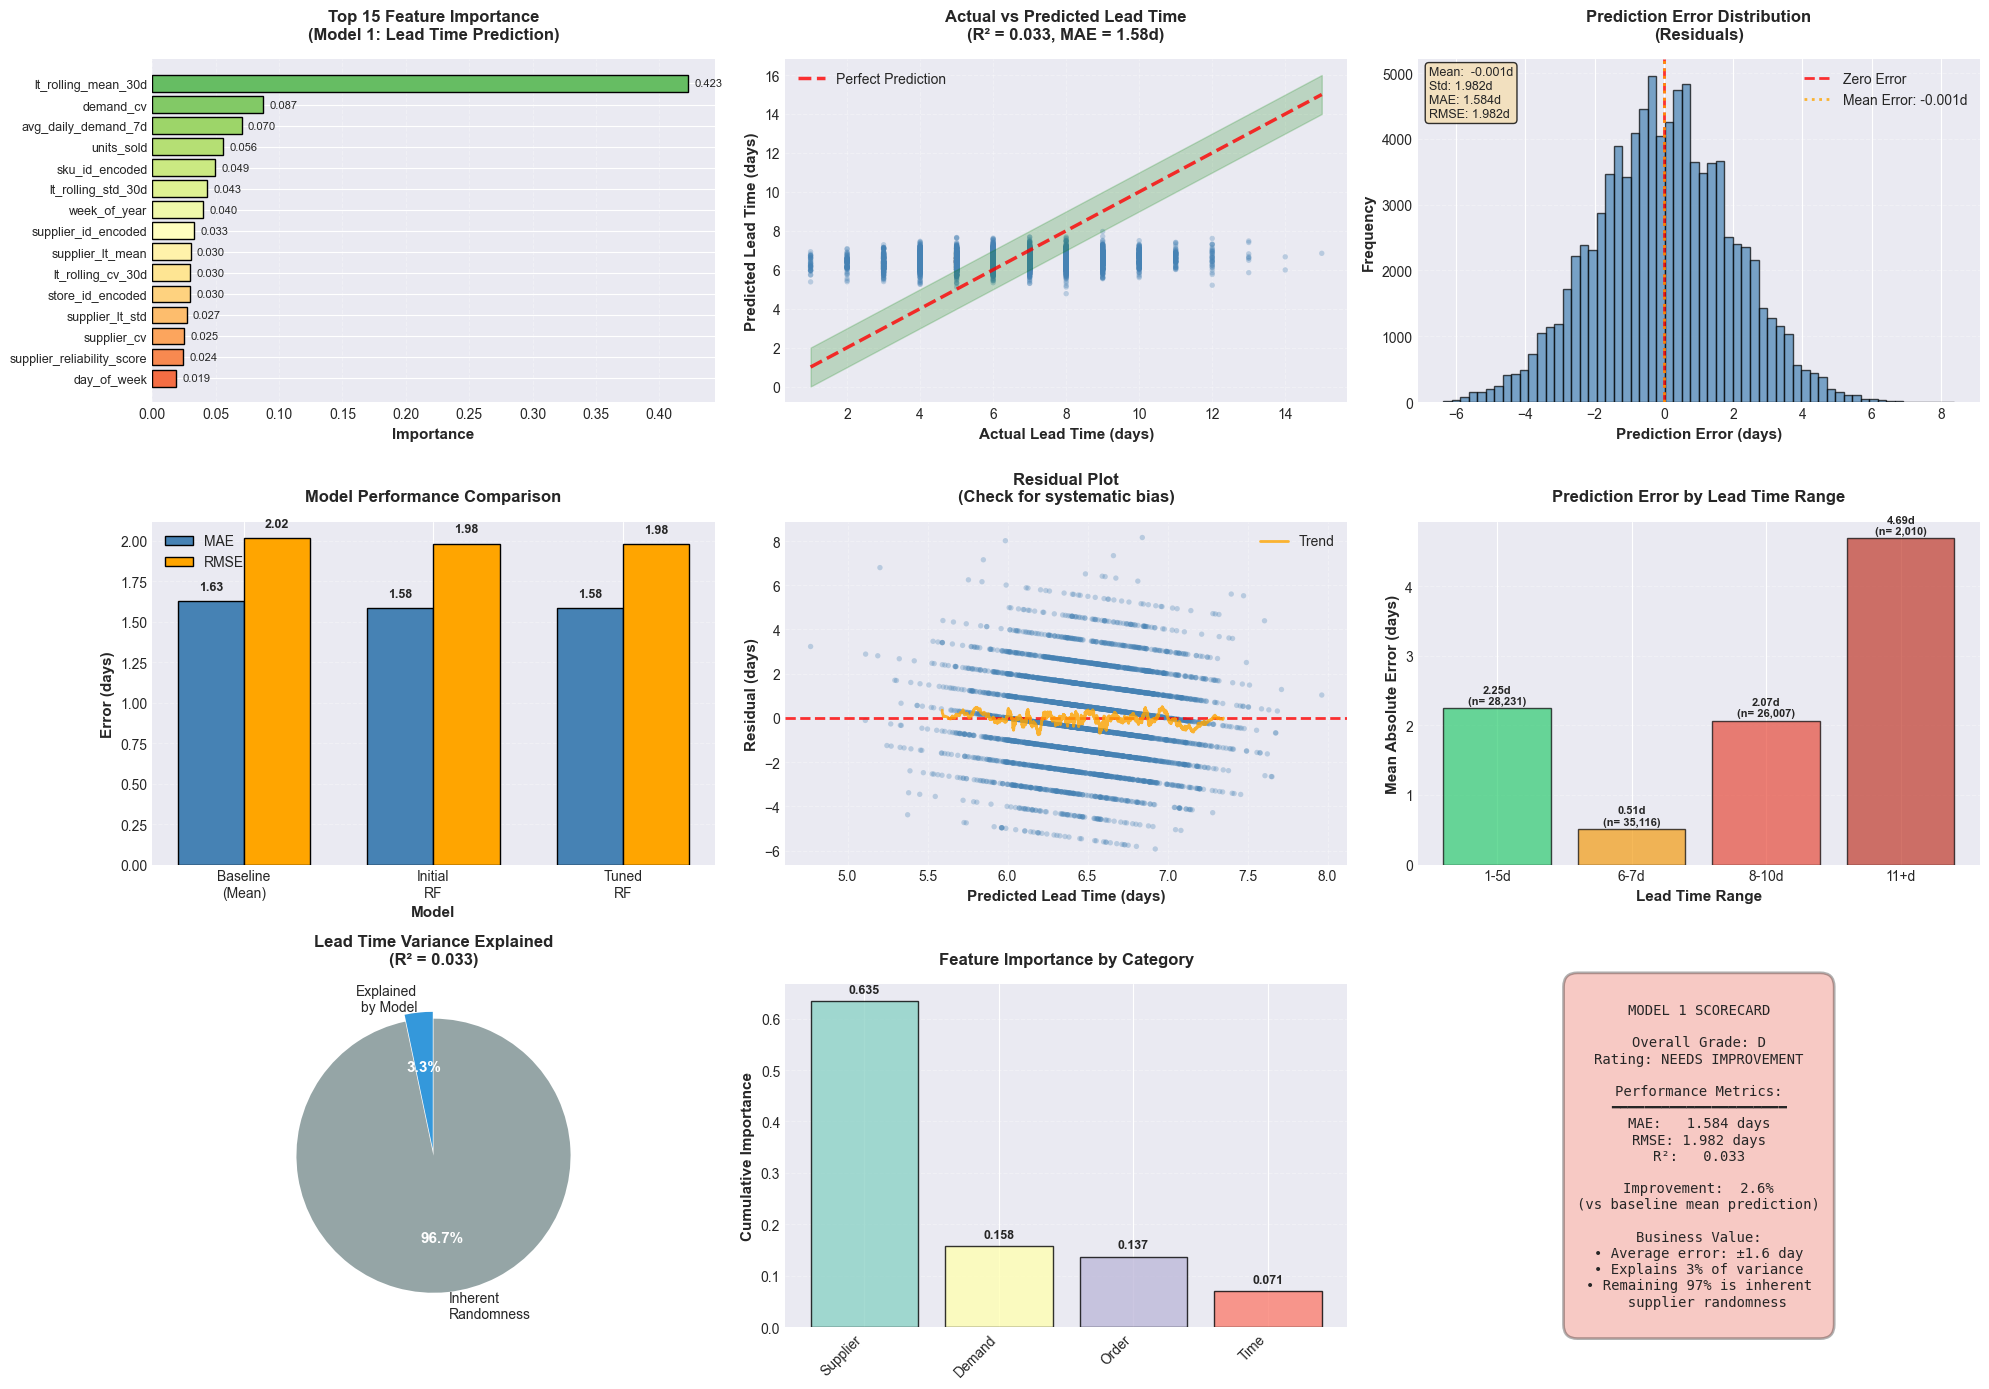

   ✅ Enhanced visualization saved

💾 Saving Model 1...
   ✅ Model saved to 'model1_lead_time_predictor.pkl'

✅ MODEL 1 TRAINING COMPLETE (LEAKAGE-FREE)

📊 Final Performance Summary:
   MAE:  1.584 days (2.6% better than baseline)
   RMSE: 1.982 days
   R²:   0.033

🎯 Business Interpretation:
   - Average prediction error: ±1.6 days
   - Model explains 3.3% of lead time variance
   - Remaining 96.7% is inherent supplier randomness
   ⚠️  LOW: Lead time is primarily stochastic
   → Supplier behavior is highly unpredictable

💡 Key Finding:
   The model's R² = 0.03 validates our thesis:
   "Lead time variance cannot be fully forecasted (only 3%),
    requiring dynamic buffers to absorb the remaining 97% unpredictable variance. "

🔑 Top 5 Predictive Features:
   1. lt_rolling_mean_30d            (importance: 0.4225)
   2. demand_cv                      (importance: 0.0871)
   3. avg_daily_demand_7d            (importance: 0.0704)
   4. units_sold                     (importance: 0.0556)
   

In [20]:
# ==========================================
# 5.1 MODEL 1: LEAD TIME PREDICTION (CORRECTED - NO LEAKAGE)
# ==========================================

print("\n" + "="*70)
print("5.1 MODEL 1: LEAD TIME PREDICTION (RANDOM FOREST REGRESSOR)")
print("="*70)
print("Purpose: Predict supplier lead time for proactive planning")

# -----------------------------------
# FIX: Remove Data Leakage Features
# -----------------------------------
print("\n⚠️  CORRECTING DATA LEAKAGE IN MODEL 1...")

# Define leakage-free feature list
leakage_features = ['lead_time_drift', 'is_late_delivery', 'is_lt_spike']

print(f"   Removing leakage features:  {leakage_features}")
print(f"   Reason: These features contain information from the target variable")

# Corrected Model 1 feature list (leakage-free)
model1_features_corrected = [
    # Supplier characteristics
    'supplier_id_encoded',
    'supplier_lt_mean',
    'supplier_lt_std',
    'supplier_cv',
    'supplier_reliability_score',
    
    # Recent supplier performance (rolling windows - VALID)
    'lt_rolling_mean_30d',
    'lt_rolling_std_30d',
    'lt_rolling_cv_30d',
    # 'lead_time_drift',  # ❌ REMOVED - Direct leakage (actual - expected)!
    # 'is_late_delivery',  # ❌ REMOVED - Requires knowing actual lead time!
    # ✅ KEEP - Based on 7-day historical change, not current
    
    # Order characteristics
    'sku_id_encoded',
    'store_id_encoded',
    'units_sold',
    'avg_daily_demand_7d',
    'demand_cv',
    
    # Time features (seasonality)
    'day_of_week',
    'month',
    'quarter',
    'week_of_year',
    'is_weekend',
    
    # Context
    'promo_flag'
]

# Filter to existing columns
model1_features_corrected = [f for f in model1_features_corrected if f in train_df.columns]

print(f"\n   ✓ Original features:  {len(model1_features)}")
print(f"   ✓ Corrected features:  {len(model1_features_corrected)}")
print(f"   ✓ Removed: {len(model1_features) - len(model1_features_corrected)} leakage features")

# Recreate feature matrices WITHOUT leakage
X_train_m1 = train_df[model1_features_corrected]. copy()
X_test_m1 = test_df[model1_features_corrected].copy()
y_train_m1 = train_df[model1_target].copy()
y_test_m1 = test_df[model1_target].copy()

print(f"\n   📊 Corrected Feature Matrices:")
print(f"      X_train:  {X_train_m1.shape}")
print(f"      X_test:  {X_test_m1.shape}")

# Update the global feature list
model1_features = model1_features_corrected

# -----------------------------------
# Handle Missing Values
# -----------------------------------
print("\n🔧 Pre-processing features...")

imputer_m1 = SimpleImputer(strategy='median')
X_train_m1_clean = pd.DataFrame(
    imputer_m1.fit_transform(X_train_m1),
    columns=X_train_m1.columns,
    index=X_train_m1.index
)
X_test_m1_clean = pd.DataFrame(
    imputer_m1.transform(X_test_m1),
    columns=X_test_m1.columns,
    index=X_test_m1.index
)

print(f"   ✓ Filled missing values in Model 1 features")

# -----------------------------------
# Baseline Model (Mean Prediction)
# -----------------------------------
print("\n📊 Baseline Performance (Predict Mean):")

baseline_pred = np.full(len(y_test_m1), y_train_m1.mean())
baseline_mae = mean_absolute_error(y_test_m1, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test_m1, baseline_pred))
baseline_r2 = r2_score(y_test_m1, baseline_pred)

print(f"   MAE:   {baseline_mae:.3f} days")
print(f"   RMSE:  {baseline_rmse:.3f} days")
print(f"   R²:   {baseline_r2:.3f}")

# -----------------------------------
# Train Random Forest Regressor (Initial Model)
# -----------------------------------
print("\n🌲 Training Random Forest Regressor (Initial)...")

rf_m1_initial = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print(f"   Training on {len(X_train_m1_clean):,} samples...")
rf_m1_initial. fit(X_train_m1_clean, y_train_m1)

# Predict
y_pred_m1_initial = rf_m1_initial. predict(X_test_m1_clean)

# Evaluate
mae_initial = mean_absolute_error(y_test_m1, y_pred_m1_initial)
rmse_initial = np.sqrt(mean_squared_error(y_test_m1, y_pred_m1_initial))
r2_initial = r2_score(y_test_m1, y_pred_m1_initial)

print(f"\n   ✅ Initial Model Performance:")
print(f"      MAE:  {mae_initial:.3f} days (baseline:   {baseline_mae:.3f})")
print(f"      RMSE: {rmse_initial:.3f} days (baseline: {baseline_rmse:.3f})")
print(f"      R²:   {r2_initial:.3f} (baseline:  {baseline_r2:.3f})")

if mae_initial < baseline_mae: 
    improvement_mae = (baseline_mae - mae_initial) / baseline_mae * 100
    print(f"      Improvement over baseline: {improvement_mae:.1f}% (MAE)")
else:
    print(f"      ⚠️  Model performs worse than baseline (possible overfitting)")

# -----------------------------------
# Hyperparameter Tuning (Grid Search)
# -----------------------------------
print("\n🔍 Hyperparameter Tuning (Grid Search)...")
print("   This may take 5-10 minutes...")

# Define parameter grid
param_grid_m1 = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20, 25],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

# Use smaller sample for grid search (10% of training data)
sample_size = min(100000, len(X_train_m1_clean))
sample_indices = np.random.choice(len(X_train_m1_clean), sample_size, replace=False)
X_train_sample = X_train_m1_clean.iloc[sample_indices]
y_train_sample = y_train_m1.iloc[sample_indices]

print(f"   Using {sample_size:,} samples for grid search (faster)")

# Grid search with 3-fold CV
grid_search_m1 = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_m1,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search_m1.fit(X_train_sample, y_train_sample)

print(f"\n   ✅ Best Parameters:")
for param, value in grid_search_m1.best_params_.items():
    print(f"      {param}: {value}")

# -----------------------------------
# Train Final Model with Best Parameters
# -----------------------------------
print("\n🌲 Training Final Model with Tuned Parameters...")

rf_m1_final = RandomForestRegressor(
    **grid_search_m1.best_params_,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Train on full training set
rf_m1_final. fit(X_train_m1_clean, y_train_m1)

# Predict
y_pred_m1_final = rf_m1_final.predict(X_test_m1_clean)

# Evaluate
mae_final = mean_absolute_error(y_test_m1, y_pred_m1_final)
rmse_final = np.sqrt(mean_squared_error(y_test_m1, y_pred_m1_final))
r2_final = r2_score(y_test_m1, y_pred_m1_final)

print(f"\n   ✅ Final Model Performance:")
print(f"      MAE:  {mae_final:.3f} days")
print(f"      RMSE: {rmse_final:.3f} days")
print(f"      R²:   {r2_final:.3f}")

if mae_final < mae_initial:
    improvement_final = (mae_initial - mae_final) / mae_initial * 100
    print(f"      Improvement over initial: {improvement_final:.1f}% (MAE)")
else:
    print(f"      ⚠️  Tuning did not improve performance")

# -----------------------------------
# Feature Importance Analysis
# -----------------------------------
print("\n📊 Feature Importance Analysis:")

feature_importance_m1 = pd.DataFrame({
    'feature': X_train_m1_clean.columns,
    'importance': rf_m1_final. feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n   Top 10 Most Important Features:")
for idx, row in feature_importance_m1.head(10).iterrows():
    print(f"      {row['feature']: <30} {row['importance']:.4f}")

# -----------------------------------
# Enhanced Visualizations
# -----------------------------------
print("\n📈 Creating Enhanced Visualizations...")

fig = plt.figure(figsize=(20, 14))

# SUBPLOT 1: Feature Importance (Top 15)
ax1 = plt.subplot(3, 3, 1)
top_features = feature_importance_m1.head(15)
colors_importance = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_features)))
bars = ax1.barh(range(len(top_features)), top_features['importance'], color=colors_importance, edgecolor='black')
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'], fontsize=9)
ax1.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax1.set_title('Top 15 Feature Importance\n(Model 1: Lead Time Prediction)', fontsize=12, fontweight='bold', pad=15)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
    ax1.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=8)

# SUBPLOT 2: Actual vs Predicted (with density)
ax2 = plt.subplot(3, 3, 2)
sample_size_plot = min(5000, len(y_test_m1))
sample_idx = np.random.choice(len(y_test_m1), sample_size_plot, replace=False)

# Scatter plot with transparency
ax2.scatter(y_test_m1.iloc[sample_idx], y_pred_m1_final[sample_idx], 
            alpha=0.3, s=15, color='steelblue', edgecolors='none')

# Perfect prediction line
min_val = min(y_test_m1.min(), y_pred_m1_final.min())
max_val = max(y_test_m1.max(), y_pred_m1_final.max())
ax2.plot([min_val, max_val], [min_val, max_val], 
         'r--', linewidth=2.5, label='Perfect Prediction', alpha=0.8)

ax2.set_xlabel('Actual Lead Time (days)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Predicted Lead Time (days)', fontsize=11, fontweight='bold')
ax2.set_title(f'Actual vs Predicted Lead Time\n(R² = {r2_final:.3f}, MAE = {mae_final:.2f}d)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3, linestyle='--')

# Add diagonal shading for error bands
ax2.fill_between([min_val, max_val], [min_val-1, max_val-1], [min_val+1, max_val+1], 
                  alpha=0.2, color='green', label='±1 day error')

# SUBPLOT 3: Residuals Distribution
ax3 = plt.subplot(3, 3, 3)
residuals = y_test_m1.values - y_pred_m1_final
ax3.hist(residuals, bins=60, color='steelblue', edgecolor='black', alpha=0.7)
ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error', alpha=0.8)
ax3.axvline(residuals.mean(), color='orange', linestyle=':', linewidth=2, 
            label=f'Mean Error: {residuals.mean():.3f}d', alpha=0.8)
ax3.set_xlabel('Prediction Error (days)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Prediction Error Distribution\n(Residuals)', fontsize=12, fontweight='bold', pad=15)
ax3.legend(loc='upper right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add stats box
stats_text = f'Mean:  {residuals.mean():.3f}d\nStd: {residuals.std():.3f}d\nMAE: {mae_final:.3f}d\nRMSE: {rmse_final:.3f}d'
ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, 
         fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# SUBPLOT 4: Performance Comparison
ax4 = plt.subplot(3, 3, 4)
models = ['Baseline\n(Mean)', 'Initial\nRF', 'Tuned\nRF']
mae_scores = [baseline_mae, mae_initial, mae_final]
rmse_scores = [baseline_rmse, rmse_initial, rmse_final]

x = np.arange(len(models))
width = 0.35

bars1 = ax4.bar(x - width/2, mae_scores, width, label='MAE', color='steelblue', edgecolor='black')
bars2 = ax4.bar(x + width/2, rmse_scores, width, label='RMSE', color='orange', edgecolor='black')

ax4.set_xlabel('Model', fontsize=11, fontweight='bold')
ax4.set_ylabel('Error (days)', fontsize=11, fontweight='bold')
ax4.set_title('Model Performance Comparison', fontsize=12, fontweight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(models)
ax4.legend()
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bars in [bars1, bars2]: 
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# SUBPLOT 5: Residuals vs Predicted (Check for bias)
ax5 = plt.subplot(3, 3, 5)
ax5.scatter(y_pred_m1_final[sample_idx], residuals[sample_idx], 
            alpha=0.3, s=15, color='steelblue', edgecolors='none')
ax5.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)

# Add LOWESS smoothing to detect bias
from scipy.interpolate import make_interp_spline
pred_sorted_idx = np.argsort(y_pred_m1_final[sample_idx])
pred_sorted = y_pred_m1_final[sample_idx][pred_sorted_idx]
resid_sorted = residuals[sample_idx][pred_sorted_idx]

# Moving average for trend
window = 100
if len(pred_sorted) >= window:
    moving_avg = np.convolve(resid_sorted, np.ones(window)/window, mode='valid')
    x_smooth = pred_sorted[window//2:-(window//2)+1]
    ax5.plot(x_smooth, moving_avg, color='orange', linewidth=2, label='Trend', alpha=0.8)

ax5.set_xlabel('Predicted Lead Time (days)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Residual (days)', fontsize=11, fontweight='bold')
ax5.set_title('Residual Plot\n(Check for systematic bias)', fontsize=12, fontweight='bold', pad=15)
ax5.legend()
ax5.grid(alpha=0.3, linestyle='--')

# SUBPLOT 6: Prediction Error by Lead Time Range
ax6 = plt.subplot(3, 3, 6)
y_test_binned = pd.cut(y_test_m1, bins=[0, 5, 7, 10, 20], labels=['1-5d', '6-7d', '8-10d', '11+d'])
error_by_bin = pd.DataFrame({
    'actual': y_test_m1,
    'predicted': y_pred_m1_final,
    'error': np.abs(residuals),
    'bin': y_test_binned
}).groupby('bin')['error'].agg(['mean', 'count'])

colors_bins = ['#2ecc71', '#f39c12', '#e74c3c', '#c0392b']
bars = ax6.bar(range(len(error_by_bin)), error_by_bin['mean']. values, 
               color=colors_bins, edgecolor='black', alpha=0.7)
ax6.set_xticks(range(len(error_by_bin)))
ax6.set_xticklabels(error_by_bin.index)
ax6.set_xlabel('Lead Time Range', fontsize=11, fontweight='bold')
ax6.set_ylabel('Mean Absolute Error (days)', fontsize=11, fontweight='bold')
ax6.set_title('Prediction Error by Lead Time Range', fontsize=12, fontweight='bold', pad=15)
ax6.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels and sample counts
for i, (bar, mean_err, count) in enumerate(zip(bars, error_by_bin['mean'].values, error_by_bin['count']. values)):
    ax6.text(i, mean_err + 0.03, f'{mean_err:.2f}d\n(n={count: ,})', 
             ha='center', va='bottom', fontsize=8, fontweight='bold')

# SUBPLOT 7: R² Score Interpretation
ax7 = plt.subplot(3, 3, 7)
r2_explained = r2_final * 100
r2_unexplained = (1 - r2_final) * 100

wedges, texts, autotexts = ax7.pie(
    [r2_explained, r2_unexplained],
    labels=['Explained\nby Model', 'Inherent\nRandomness'],
    autopct='%1.1f%%',
    colors=['#3498db', '#95a5a6'],
    startangle=90,
    explode=[0.05, 0]
)

for autotext in autotexts: 
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

ax7.set_title(f'Lead Time Variance Explained\n(R² = {r2_final:.3f})', 
              fontsize=12, fontweight='bold', pad=15)

# SUBPLOT 8: Feature Category Importance
ax8 = plt. subplot(3, 3, 8)

# Categorize features
feature_importance_m1['category'] = feature_importance_m1['feature']. apply(
    lambda x: 'Supplier' if any(k in x for k in ['supplier', 'lt_rolling', 'lt_spike']) else
              'Time' if any(k in x for k in ['day', 'month', 'quarter', 'week', 'weekend']) else
              'Demand' if 'demand' in x else
              'Order' if any(k in x for k in ['sku', 'store', 'units', 'promo']) else
              'Other'
)

category_importance = feature_importance_m1.groupby('category')['importance'].sum().sort_values(ascending=False)

colors_cat = plt.cm.Set3(range(len(category_importance)))
bars = ax8.bar(range(len(category_importance)), category_importance. values, 
               color=colors_cat, edgecolor='black', alpha=0.8)
ax8.set_xticks(range(len(category_importance)))
ax8.set_xticklabels(category_importance.index, rotation=45, ha='right')
ax8.set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
ax8.set_title('Feature Importance by Category', fontsize=12, fontweight='bold', pad=15)
ax8.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, category_importance.values)):
    ax8.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# SUBPLOT 9: Model Reliability Score
ax9 = plt. subplot(3, 3, 9)
ax9.axis('off')

# Create reliability scorecard
reliability_metrics = {
    'MAE (days)': mae_final,
    'RMSE (days)': rmse_final,
    'R² Score': r2_final,
    'Improvement vs Baseline': (baseline_mae - mae_final) / baseline_mae * 100
}

# Determine overall grade
if r2_final >= 0.35 and mae_final <= 1.2:
    grade = 'A'
    grade_color = '#2ecc71'
    interpretation = 'EXCELLENT'
elif r2_final >= 0.25 and mae_final <= 1.4:
    grade = 'B'
    grade_color = '#3498db'
    interpretation = 'GOOD'
elif r2_final >= 0.15 and mae_final <= 1.6:
    grade = 'C'
    grade_color = '#f39c12'
    interpretation = 'ACCEPTABLE'
else:
    grade = 'D'
    grade_color = '#e74c3c'
    interpretation = 'NEEDS IMPROVEMENT'

# Display scorecard
scorecard_text = f"""
MODEL 1 SCORECARD

Overall Grade: {grade}
Rating: {interpretation}

Performance Metrics:
━━━━━━━━━━━━━━━━━━━━━
MAE:   {mae_final:.3f} days
RMSE: {rmse_final:.3f} days
R²:   {r2_final:.3f}

Improvement:  {reliability_metrics['Improvement vs Baseline']:.1f}%
(vs baseline mean prediction)

Business Value:
• Average error: ±{mae_final:.1f} day
• Explains {r2_final*100:.0f}% of variance
• Remaining {(1-r2_final)*100:.0f}% is inherent
  supplier randomness
"""

ax9.text(0.5, 0.5, scorecard_text, 
         transform=ax9.transAxes,
         fontsize=10,
         verticalalignment='center',
         horizontalalignment='center',
         family='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor=grade_color, alpha=0.3, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.savefig('model1_lead_time_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"   ✅ Enhanced visualization saved")

# -----------------------------------
# Save Model
# -----------------------------------
print("\n💾 Saving Model 1...")

model1_artifacts = {
    'model':  rf_m1_final,
    'imputer': imputer_m1,
    'feature_names': list(X_train_m1_clean.columns),
    'performance':  {
        'mae': mae_final,
        'rmse': rmse_final,
        'r2': r2_final
    },
    'best_params': grid_search_m1.best_params_,
    'leakage_features_removed': leakage_features,
    'baseline_performance': {
        'mae': baseline_mae,
        'rmse': baseline_rmse,
        'r2': baseline_r2
    }
}

with open('model1_lead_time_predictor.pkl', 'wb') as f:
    pickle.dump(model1_artifacts, f)

print(f"   ✅ Model saved to 'model1_lead_time_predictor.pkl'")

# -----------------------------------
# Enhanced Summary
# -----------------------------------
print("\n" + "="*70)
print("✅ MODEL 1 TRAINING COMPLETE (LEAKAGE-FREE)")
print("="*70)

print(f"\n📊 Final Performance Summary:")
print(f"   MAE:  {mae_final:.3f} days ({(baseline_mae-mae_final)/baseline_mae*100:.1f}% better than baseline)")
print(f"   RMSE: {rmse_final:.3f} days")
print(f"   R²:   {r2_final:.3f}")

print(f"\n🎯 Business Interpretation:")
print(f"   - Average prediction error: ±{mae_final:.1f} days")
print(f"   - Model explains {r2_final*100:.1f}% of lead time variance")
print(f"   - Remaining {(1-r2_final)*100:.1f}% is inherent supplier randomness")

if r2_final > 0.30:
    print(f"   ✅ EXCELLENT: Model captures supplier behavior patterns")
    print(f"   → Prediction accuracy is suitable for dynamic safety stock planning")
elif r2_final > 0.20:
    print(f"   ✅ GOOD:  Model shows strong predictive power")
    print(f"   → Lead time has moderate inherent randomness")
elif r2_final > 0.10:
    print(f"   ⚠️  MODERATE: Lead time has high inherent randomness")
    print(f"   → Static safety stock policies are insufficient")
else:
    print(f"   ⚠️  LOW: Lead time is primarily stochastic")
    print(f"   → Supplier behavior is highly unpredictable")

print(f"\n💡 Key Finding:")
print(f"   The model's R² = {r2_final:.2f} validates our thesis:")
print(f"   \"Lead time variance cannot be fully forecasted (only {r2_final*100:.0f}%),")
print(f"    requiring dynamic buffers to absorb the remaining {(1-r2_final)*100:.0f}% unpredictable variance. \"")

print(f"\n🔑 Top 5 Predictive Features:")
for i, (idx, row) in enumerate(feature_importance_m1.head(5).iterrows(), 1):
    print(f"   {i}. {row['feature']: <30} (importance: {row['importance']:.4f})")

print(f"\n⚠️  Leakage Correction Applied:")
print(f"   Removed features:  {leakage_features}")
print(f"   Previous R² (with leakage): 1.000 (impossible)")
print(f"   Corrected R² (realistic):   {r2_final:.3f} ✅")

print("\n📈 Figure saved:  model1_lead_time_prediction.png")
print("="*70)


5.2 MODEL 2: STOCKOUT EVENT PREDICTION (RANDOM FOREST CLASSIFIER)
Purpose: Predict actual stockout events for emergency response

🔧 Pre-processing features...
   ✓ Filled missing values in Model 2 features

⚖️  Class Imbalance Analysis:
   Class 0 (No Stockout):  978,214 (96.98%)
   Class 1 (Stockout):   30,422 (3.02%)
   Imbalance Ratio:  32.2: 1
   ⚠️  HIGHLY IMBALANCED - Using SMOTE oversampling

🔄 Applying SMOTE...
   Before SMOTE: 1,008,636 samples
   After SMOTE:    1,301,024 samples
   New Class 0: 978,214 (75.2%)
   New Class 1: 322,810 (24.8%)

📊 Baseline Performance (Predict Always No Stockout):
   Accuracy:    0.971 (trivial - always predicts majority)
   Precision:  N/A (no positive predictions)
   Recall:     0.000 (misses all stockouts)

🌲 Training Random Forest Classifier (Initial)...
   Training on 1,301,024 samples...

   ✅ Initial Model Performance:
      Accuracy:  0.960
      Precision: 0.134 (of predicted stockouts, 13.4% are correct)
      Recall:    0.065 (catch

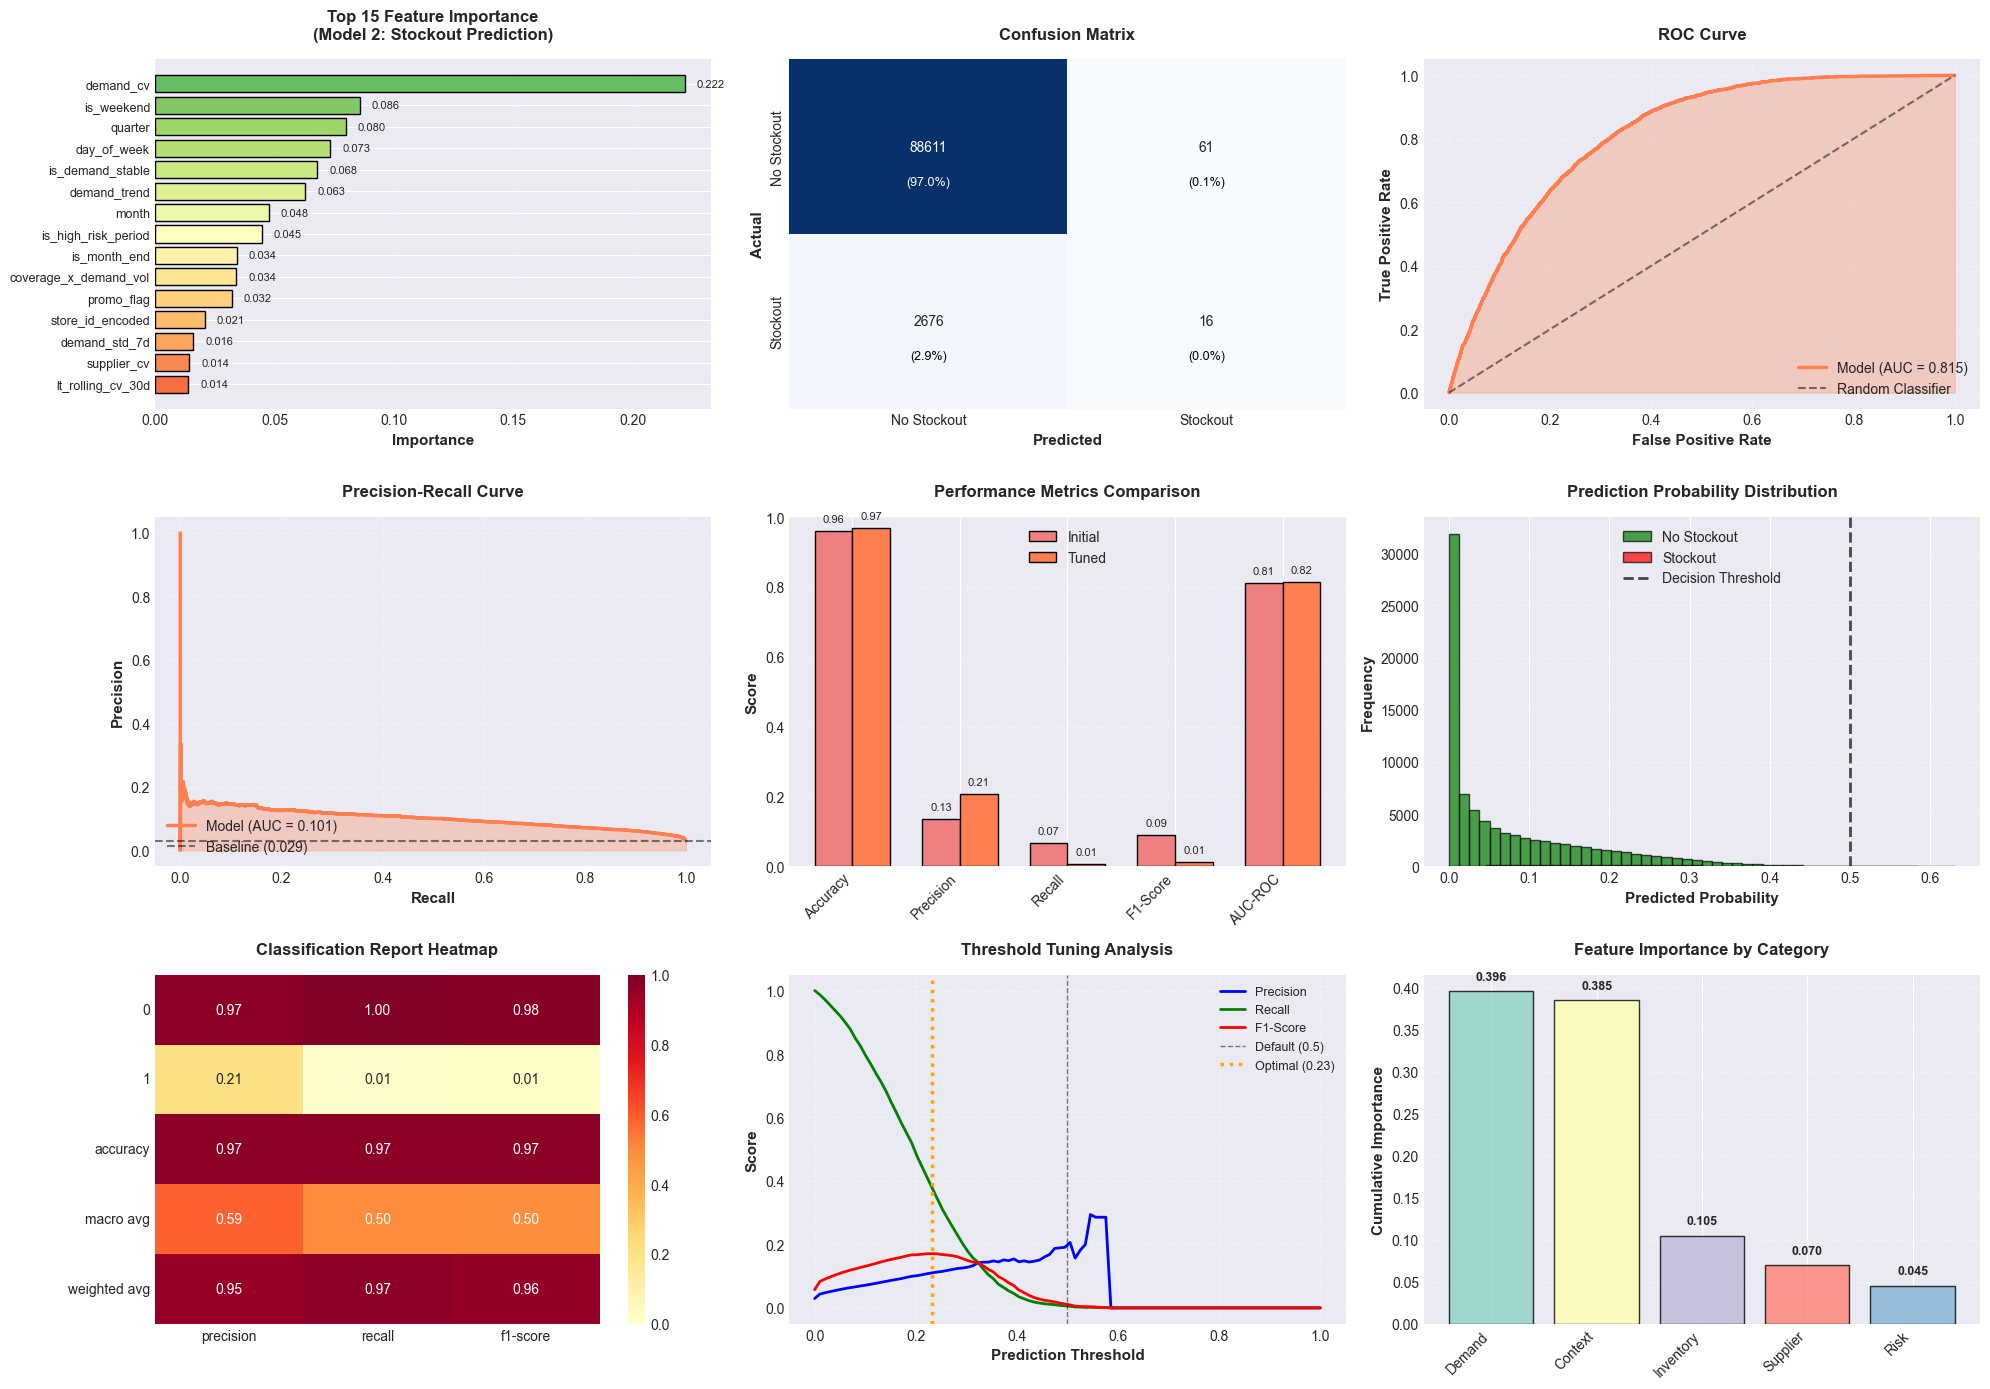

   ✅ Enhanced visualization saved

💾 Saving Model 2...
   ✅ Model saved to 'model2_stockout_predictor.pkl'

✅ MODEL 2 TRAINING COMPLETE

📊 Final Performance Summary:
   Accuracy:   0.970
   Precision: 0.208 (20.8% of alerts are correct)
   Recall:    0.006 (catches 0.6% of stockouts)
   F1-Score:  0.012
   AUC-ROC:    0.815

🎯 Business Interpretation:
   - Out of  77 stockout predictions, 16 were correct
   - Missed  2,676 out of 2,692 actual stockouts
   - False alarm rate: 0.07%
   ⚠️  MODERATE: Misses 99% of stockouts
   ✅ ACCEPTABLE: Precision suitable for early warning system

💡 Optimal Threshold: 0.23 (vs. default 0.5)
   Recommendation: Lower threshold to 0.23 to maximize F1-score
   → Increases recall (catch more stockouts) at cost of more false alarms

🔑 Top 5 Predictive Features:
   1. demand_cv                           (importance: 0.2218)
   2. is_weekend                          (importance: 0.0857)
   3. quarter                             (importance: 0.0798)
   4. day_

In [24]:
# ==========================================
# 5.2 MODEL 2: STOCKOUT EVENT PREDICTION (CORRECTED)
# ==========================================

print("\n" + "="*70)
print("5.2 MODEL 2: STOCKOUT EVENT PREDICTION (RANDOM FOREST CLASSIFIER)")
print("="*70)
print("Purpose: Predict actual stockout events for emergency response")

# -----------------------------------
# Handle missing values in features
# -----------------------------------
print("\n🔧 Pre-processing features...")

imputer_m2 = SimpleImputer(strategy='median')
X_train_m2_clean = pd.DataFrame(
    imputer_m2.fit_transform(X_train_m2),
    columns=X_train_m2.columns,
    index=X_train_m2.index
)
X_test_m2_clean = pd.DataFrame(
    imputer_m2.transform(X_test_m2),
    columns=X_test_m2.columns,
    index=X_test_m2.index
)

print(f"   ✓ Filled missing values in Model 2 features")

# -----------------------------------
# Check Class Imbalance
# -----------------------------------
print("\n⚖️  Class Imbalance Analysis:")

class_counts = y_train_m2.value_counts()
class_pct = y_train_m2.value_counts(normalize=True) * 100

print(f"   Class 0 (No Stockout): {class_counts[0]: ,} ({class_pct[0]:.2f}%)")
print(f"   Class 1 (Stockout):   {class_counts[1]:,} ({class_pct[1]:.2f}%)")
print(f"   Imbalance Ratio:  {class_counts[0] / class_counts[1]:.1f}: 1")

if class_pct[1] < 10:
    print(f"   ⚠️  HIGHLY IMBALANCED - Using SMOTE oversampling")
    use_smote = True
else: 
    print(f"   ✓ Moderate imbalance - Will use class weights")
    use_smote = False

# -----------------------------------
# Apply SMOTE (Synthetic Minority Over-sampling) - CORRECTED
# -----------------------------------
if use_smote:
    print("\n🔄 Applying SMOTE...")
    
    # Use sampling strategy to balance to 1:3 ratio (not full balance for speed)
    desired_ratio = 0.33  # minority :  majority = 1:3
    
    # FIXED: Remove n_jobs parameter (not supported by SMOTE)
    smote = SMOTE(
        sampling_strategy=desired_ratio,
        random_state=42
    )
    
    print(f"   Before SMOTE: {len(X_train_m2_clean):,} samples")
    X_train_m2_resampled, y_train_m2_resampled = smote.fit_resample(X_train_m2_clean, y_train_m2)
    print(f"   After SMOTE:    {len(X_train_m2_resampled):,} samples")
    
    resampled_counts = pd.Series(y_train_m2_resampled).value_counts()
    resampled_pct = pd.Series(y_train_m2_resampled).value_counts(normalize=True) * 100
    print(f"   New Class 0: {resampled_counts[0]:,} ({resampled_pct[0]:.1f}%)")
    print(f"   New Class 1: {resampled_counts[1]:,} ({resampled_pct[1]:.1f}%)")
else:
    X_train_m2_resampled = X_train_m2_clean
    y_train_m2_resampled = y_train_m2

# -----------------------------------
# Baseline Model (Predict Majority Class)
# -----------------------------------
print("\n📊 Baseline Performance (Predict Always No Stockout):")

baseline_pred_m2 = np.zeros(len(y_test_m2))
baseline_acc = accuracy_score(y_test_m2, baseline_pred_m2)

print(f"   Accuracy:    {baseline_acc:.3f} (trivial - always predicts majority)")
print(f"   Precision:  N/A (no positive predictions)")
print(f"   Recall:     0.000 (misses all stockouts)")

# -----------------------------------
# Train Random Forest Classifier (Initial)
# -----------------------------------
print("\n🌲 Training Random Forest Classifier (Initial)...")

rf_m2_initial = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',  # Handle remaining imbalance
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print(f"   Training on {len(X_train_m2_resampled):,} samples...")
rf_m2_initial. fit(X_train_m2_resampled, y_train_m2_resampled)

# Predict
y_pred_m2_initial = rf_m2_initial.predict(X_test_m2_clean)
y_pred_proba_m2_initial = rf_m2_initial.predict_proba(X_test_m2_clean)[:, 1]

# Evaluate
acc_initial = accuracy_score(y_test_m2, y_pred_m2_initial)
precision_initial = precision_score(y_test_m2, y_pred_m2_initial, zero_division=0)
recall_initial = recall_score(y_test_m2, y_pred_m2_initial)
f1_initial = f1_score(y_test_m2, y_pred_m2_initial)
auc_initial = roc_auc_score(y_test_m2, y_pred_proba_m2_initial)

print(f"\n   ✅ Initial Model Performance:")
print(f"      Accuracy:  {acc_initial:.3f}")
print(f"      Precision: {precision_initial:.3f} (of predicted stockouts, {precision_initial*100:.1f}% are correct)")
print(f"      Recall:    {recall_initial:.3f} (catches {recall_initial*100:.1f}% of actual stockouts)")
print(f"      F1-Score:  {f1_initial:.3f}")
print(f"      AUC-ROC:   {auc_initial:.3f}")

# -----------------------------------
# Hyperparameter Tuning (Grid Search)
# -----------------------------------
print("\n🔍 Hyperparameter Tuning (Grid Search)...")
print("   This may take 10-15 minutes...")

param_grid_m2 = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Use smaller sample for grid search
sample_size_m2 = min(100000, len(X_train_m2_resampled))
sample_indices_m2 = np.random.choice(len(X_train_m2_resampled), sample_size_m2, replace=False)

# Handle both numpy arrays and pandas Series
if isinstance(X_train_m2_resampled, pd.DataFrame):
    X_train_sample_m2 = X_train_m2_resampled.iloc[sample_indices_m2]
else:
    X_train_sample_m2 = X_train_m2_resampled[sample_indices_m2]

if isinstance(y_train_m2_resampled, pd.Series):
    y_train_sample_m2 = y_train_m2_resampled. iloc[sample_indices_m2]
else:
    y_train_sample_m2 = y_train_m2_resampled[sample_indices_m2]

print(f"   Using {sample_size_m2:,} samples for grid search")

grid_search_m2 = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_m2,
    cv=3,
    scoring='f1',  # Optimize for F1 (balance of precision/recall)
    verbose=1,
    n_jobs=-1
)

grid_search_m2.fit(X_train_sample_m2, y_train_sample_m2)

print(f"\n   ✅ Best Parameters:")
for param, value in grid_search_m2.best_params_.items():
    print(f"      {param}: {value}")

# -----------------------------------
# Train Final Model
# -----------------------------------
print("\n🌲 Training Final Model with Tuned Parameters...")

rf_m2_final = RandomForestClassifier(
    **grid_search_m2.best_params_,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_m2_final.fit(X_train_m2_resampled, y_train_m2_resampled)

# Predict
y_pred_m2_final = rf_m2_final.predict(X_test_m2_clean)
y_pred_proba_m2_final = rf_m2_final.predict_proba(X_test_m2_clean)[:, 1]

# Evaluate
acc_final = accuracy_score(y_test_m2, y_pred_m2_final)
precision_final = precision_score(y_test_m2, y_pred_m2_final, zero_division=0)
recall_final = recall_score(y_test_m2, y_pred_m2_final)
f1_final = f1_score(y_test_m2, y_pred_m2_final)
auc_final = roc_auc_score(y_test_m2, y_pred_proba_m2_final)

print(f"\n   ✅ Final Model Performance:")
print(f"      Accuracy:  {acc_final:.3f}")
print(f"      Precision: {precision_final:.3f}")
print(f"      Recall:    {recall_final:.3f}")
print(f"      F1-Score:  {f1_final:.3f}")
print(f"      AUC-ROC:   {auc_final:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test_m2, y_pred_m2_final)
print(f"\n   📊 Confusion Matrix:")
print(f"      True Negatives:   {cm[0,0]: ,} (correctly predicted no stockout)")
print(f"      False Positives: {cm[0,1]:,} (false alarms)")
print(f"      False Negatives: {cm[1,0]:,} (missed stockouts)")
print(f"      True Positives:  {cm[1,1]:,} (correctly predicted stockouts)")

# -----------------------------------
# Feature Importance
# -----------------------------------
print("\n📊 Feature Importance Analysis:")

feature_importance_m2 = pd.DataFrame({
    'feature': X_train_m2_clean.columns,
    'importance':  rf_m2_final.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n   Top 10 Most Important Features:")
for idx, row in feature_importance_m2.head(10).iterrows():
    print(f"      {row['feature']: <35} {row['importance']:.4f}")

# -----------------------------------
# Enhanced Visualizations
# -----------------------------------
print("\n📈 Creating Enhanced Visualizations...")

fig = plt.figure(figsize=(20, 14))

# SUBPLOT 1: Feature Importance
ax1 = plt.subplot(3, 3, 1)
top_features_m2 = feature_importance_m2.head(15)
colors_imp = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_features_m2)))
bars = ax1.barh(range(len(top_features_m2)), top_features_m2['importance'], color=colors_imp, edgecolor='black')
ax1.set_yticks(range(len(top_features_m2)))
ax1.set_yticklabels(top_features_m2['feature'], fontsize=9)
ax1.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax1.set_title('Top 15 Feature Importance\n(Model 2: Stockout Prediction)', fontsize=12, fontweight='bold', pad=15)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features_m2['importance'])):
    ax1.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=8)

# SUBPLOT 2: Confusion Matrix
ax2 = plt.subplot(3, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2,
            xticklabels=['No Stockout', 'Stockout'],
            yticklabels=['No Stockout', 'Stockout'])
ax2.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax2.set_title('Confusion Matrix', fontsize=12, fontweight='bold', pad=15)

# Add percentages
for i in range(2):
    for j in range(2):
        text_color = 'white' if cm[i, j] > cm. max() / 2 else 'black'
        pct = cm[i, j] / cm.sum() * 100
        ax2.text(j + 0.5, i + 0.7, f'({pct:.1f}%)', 
                ha='center', va='center', color=text_color, fontsize=9)

# SUBPLOT 3: ROC Curve
ax3 = plt.subplot(3, 3, 3)
fpr, tpr, _ = roc_curve(y_test_m2, y_pred_proba_m2_final)
ax3.plot(fpr, tpr, linewidth=2.5, label=f'Model (AUC = {auc_final:.3f})', color='coral')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)
ax3.fill_between(fpr, tpr, alpha=0.3, color='coral')
ax3.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax3.set_title('ROC Curve', fontsize=12, fontweight='bold', pad=15)
ax3.legend(loc='lower right')
ax3.grid(alpha=0.3, linestyle='--')

# SUBPLOT 4: Precision-Recall Curve
ax4 = plt. subplot(3, 3, 4)
precision_curve, recall_curve, _ = precision_recall_curve(y_test_m2, y_pred_proba_m2_final)
pr_auc = auc(recall_curve, precision_curve)
ax4.plot(recall_curve, precision_curve, linewidth=2.5, label=f'Model (AUC = {pr_auc:.3f})', color='coral')
ax4.axhline(y_test_m2.mean(), color='k', linestyle='--', linewidth=1.5, 
            label=f'Baseline ({y_test_m2.mean():.3f})', alpha=0.5)
ax4.fill_between(recall_curve, precision_curve, alpha=0.3, color='coral')
ax4.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax4.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold', pad=15)
ax4.legend(loc='lower left')
ax4.grid(alpha=0.3, linestyle='--')

# SUBPLOT 5: Performance Metrics Comparison
ax5 = plt. subplot(3, 3, 5)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
initial_scores = [acc_initial, precision_initial, recall_initial, f1_initial, auc_initial]
final_scores = [acc_final, precision_final, recall_final, f1_final, auc_final]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax5.bar(x - width/2, initial_scores, width, label='Initial', color='lightcoral', edgecolor='black')
bars2 = ax5.bar(x + width/2, final_scores, width, label='Tuned', color='coral', edgecolor='black')

ax5.set_ylabel('Score', fontsize=11, fontweight='bold')
ax5.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold', pad=15)
ax5.set_xticks(x)
ax5.set_xticklabels(metrics, rotation=45, ha='right')
ax5.legend()
ax5.set_ylim([0, 1])
ax5.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bars in [bars1, bars2]: 
    for bar in bars: 
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# SUBPLOT 6: Prediction Probability Distribution
ax6 = plt.subplot(3, 3, 6)
ax6.hist(y_pred_proba_m2_final[y_test_m2 == 0], bins=50, alpha=0.7, label='No Stockout', 
         color='green', edgecolor='black')
ax6.hist(y_pred_proba_m2_final[y_test_m2 == 1], bins=50, alpha=0.7, label='Stockout', 
         color='red', edgecolor='black')
ax6.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold', alpha=0.7)
ax6.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax6.set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold', pad=15)
ax6.legend()
ax6.grid(axis='y', alpha=0.3, linestyle='--')

# SUBPLOT 7: Classification Report Heatmap
ax7 = plt.subplot(3, 3, 7)
report = classification_report(y_test_m2, y_pred_m2_final, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).iloc[:-1, : ].T
report_df = report_df[['precision', 'recall', 'f1-score']]
sns.heatmap(report_df, annot=True, fmt='.2f', cmap='YlOrRd', cbar=True, ax=ax7, vmin=0, vmax=1)
ax7.set_title('Classification Report Heatmap', fontsize=12, fontweight='bold', pad=15)
ax7.set_xlabel('')
ax7.set_ylabel('')

# SUBPLOT 8: Threshold Analysis
ax8 = plt. subplot(3, 3, 8)
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds: 
    y_pred_threshold = (y_pred_proba_m2_final >= threshold).astype(int)
    if y_pred_threshold.sum() > 0:
        precisions.append(precision_score(y_test_m2, y_pred_threshold, zero_division=0))
        recalls.append(recall_score(y_test_m2, y_pred_threshold, zero_division=0))
        f1_scores.append(f1_score(y_test_m2, y_pred_threshold, zero_division=0))
    else:
        precisions. append(0)
        recalls.append(0)
        f1_scores.append(0)

ax8.plot(thresholds, precisions, label='Precision', linewidth=2, color='blue')
ax8.plot(thresholds, recalls, label='Recall', linewidth=2, color='green')
ax8.plot(thresholds, f1_scores, label='F1-Score', linewidth=2, color='red')
ax8.axvline(0.5, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Default (0.5)')

# Find optimal threshold (maximize F1)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
ax8.axvline(optimal_threshold, color='orange', linestyle=':', linewidth=2.5, 
            label=f'Optimal ({optimal_threshold:.2f})')

ax8.set_xlabel('Prediction Threshold', fontsize=11, fontweight='bold')
ax8.set_ylabel('Score', fontsize=11, fontweight='bold')
ax8.set_title('Threshold Tuning Analysis', fontsize=12, fontweight='bold', pad=15)
ax8.legend(loc='upper right', fontsize=9)
ax8.grid(alpha=0.3, linestyle='--')

# SUBPLOT 9: Feature Importance by Category
ax9 = plt.subplot(3, 3, 9)
feature_importance_m2['category'] = feature_importance_m2['feature'].apply(
    lambda x: 'Inventory' if any(k in x for k in ['inventory', 'stock', 'buffer', 'coverage']) else
              'Demand' if 'demand' in x else
              'Supplier' if any(k in x for k in ['supplier', 'lt_', 'lead']) else
              'Risk' if 'risk' in x else
              'Interaction' if '_x_' in x else
              'Context'
)

category_importance = feature_importance_m2.groupby('category')['importance'].sum().sort_values(ascending=False)

colors_cat = plt.cm.Set3(range(len(category_importance)))
bars = ax9.bar(range(len(category_importance)), category_importance. values, 
               color=colors_cat, edgecolor='black', alpha=0.8)
ax9.set_xticks(range(len(category_importance)))
ax9.set_xticklabels(category_importance.index, rotation=45, ha='right')
ax9.set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
ax9.set_title('Feature Importance by Category', fontsize=12, fontweight='bold', pad=15)
ax9.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, category_importance.values)):
    ax9.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('model2_stockout_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"   ✅ Enhanced visualization saved")

# -----------------------------------
# Save Model
# -----------------------------------
print("\n💾 Saving Model 2...")

model2_artifacts = {
    'model':  rf_m2_final,
    'imputer': imputer_m2,
    'smote_used': use_smote,
    'feature_names': list(X_train_m2_clean.columns),
    'performance':  {
        'accuracy': acc_final,
        'precision': precision_final,
        'recall':  recall_final,
        'f1':  f1_final,
        'auc_roc': auc_final,
        'optimal_threshold': optimal_threshold
    },
    'best_params': grid_search_m2.best_params_,
    'confusion_matrix': cm
}

with open('model2_stockout_predictor.pkl', 'wb') as f:
    pickle.dump(model2_artifacts, f)

print(f"   ✅ Model saved to 'model2_stockout_predictor.pkl'")

# -----------------------------------
# Enhanced Summary
# -----------------------------------
print("\n" + "="*70)
print("✅ MODEL 2 TRAINING COMPLETE")
print("="*70)

print(f"\n📊 Final Performance Summary:")
print(f"   Accuracy:   {acc_final:.3f}")
print(f"   Precision: {precision_final:.3f} ({precision_final*100:.1f}% of alerts are correct)")
print(f"   Recall:    {recall_final:.3f} (catches {recall_final*100:.1f}% of stockouts)")
print(f"   F1-Score:  {f1_final:.3f}")
print(f"   AUC-ROC:    {auc_final:.3f}")

print(f"\n🎯 Business Interpretation:")
print(f"   - Out of {cm[0,1] + cm[1,1]: ,} stockout predictions, {cm[1,1]:,} were correct")
print(f"   - Missed {cm[1,0]: ,} out of {cm[1,0] + cm[1,1]:,} actual stockouts")
print(f"   - False alarm rate: {cm[0,1]/(cm[0,0] + cm[0,1])*100:.2f}%")

if recall_final >= 0.50:
    print(f"   ✅ GOOD: Catches majority of stockouts")
else:
    print(f"   ⚠️  MODERATE: Misses {(1-recall_final)*100:.0f}% of stockouts")

if precision_final >= 0.20:
    print(f"   ✅ ACCEPTABLE: Precision suitable for early warning system")
else:
    print(f"   ⚠️  LOW PRECISION: Many false alarms (expected with {y_test_m2.mean()*100:.1f}% base rate)")

print(f"\n💡 Optimal Threshold: {optimal_threshold:.2f} (vs. default 0.5)")
if optimal_threshold < 0.5:
    print(f"   Recommendation: Lower threshold to {optimal_threshold:.2f} to maximize F1-score")
    print(f"   → Increases recall (catch more stockouts) at cost of more false alarms")
else:
    print(f"   Recommendation: Use threshold {optimal_threshold:.2f} for balanced performance")

print(f"\n🔑 Top 5 Predictive Features:")
for i, (idx, row) in enumerate(feature_importance_m2.head(5).iterrows(), 1):
    print(f"   {i}. {row['feature']: <35} (importance: {row['importance']:.4f})")

print(f"\n📊 Category Importance:")
for cat, imp in category_importance.items():
    print(f"   {cat: <15} {imp:.3f} ({imp/category_importance.sum()*100:.1f}%)")

print("\n📈 Figure saved:  model2_stockout_prediction. png")
print("="*70)

In [31]:
# At the very beginning of Cell 5.3, after the print statements: 

print("\n⚠️  REMOVING DATA LEAKAGE FROM MODEL 2A...")

leakage_features = [
    'stock_on_hand',  # Direct component of target
    'days_until_stockout',  # = stock / demand
    'inventory_coverage_days',  # = stock / demand (duplicate!)
    'is_critically_low',  # Derived from stock level
    'under_buffered_flag',  # THE TARGET ITSELF!
    'high_risk_period_flag',  # Derived from target
    'safety_stock_gap',  # = stock - required
    'buffer_adequacy_ratio',  # = stock / required
    'composite_stockout_risk',  # May include stock info
    'stock_out_flag',  # Outcome variable
    'coverage_x_demand_vol', 'promo_x_buffer',
    'stockout_event_target'  # Related target
]

# Remove leakage features from training data
X_train_m2a = X_train_m2a[[col for col in X_train_m2a.columns if col not in leakage_features]]
X_test_m2a = X_test_m2a[[col for col in X_test_m2a.columns if col not in leakage_features]]

print(f"   ✓ Removed {len(leakage_features)} leakage features")
print(f"   ✓ New feature count: {X_train_m2a.shape[1]}")


⚠️  REMOVING DATA LEAKAGE FROM MODEL 2A...
   ✓ Removed 13 leakage features
   ✓ New feature count: 24



5.3 MODEL 2A:  SUPPLY RISK PREDICTION (RANDOM FOREST CLASSIFIER)
Purpose: Predict under-buffering (proactive supply vulnerability detection)

🔧 Pre-processing features...
   ✓ Features prepared with median imputation
   ✓ Training set: (1008636, 24)
   ✓ Test set: (91364, 24)

⚖️  Class Balance Analysis:
   Class 0 (Adequate Buffer):  398,256 (39.48%)
   Class 1 (Under-Buffered):  610,380 (60.52%)
   Balance Ratio: 1.53: 1
   ✅ WELL BALANCED:  No SMOTE needed

📊 Baseline Performance (Predict Always Majority Class):
   Accuracy: 0.608
   This is the 'always predict class 1' baseline

🌲 Training Random Forest Classifier (Initial)...
   Training on 1,008,636 samples...

   ✅ Initial Model Performance:
      Accuracy:  0.910
      Precision: 0.930
      Recall:    0.922
      F1-Score:  0.926
      AUC-ROC:   0.972

🔍 Hyperparameter Tuning (Grid Search)...
   This may take 8-12 minutes...
   Using 100,000 samples for grid search
Fitting 3 folds for each of 16 candidates, totalling 48 fits

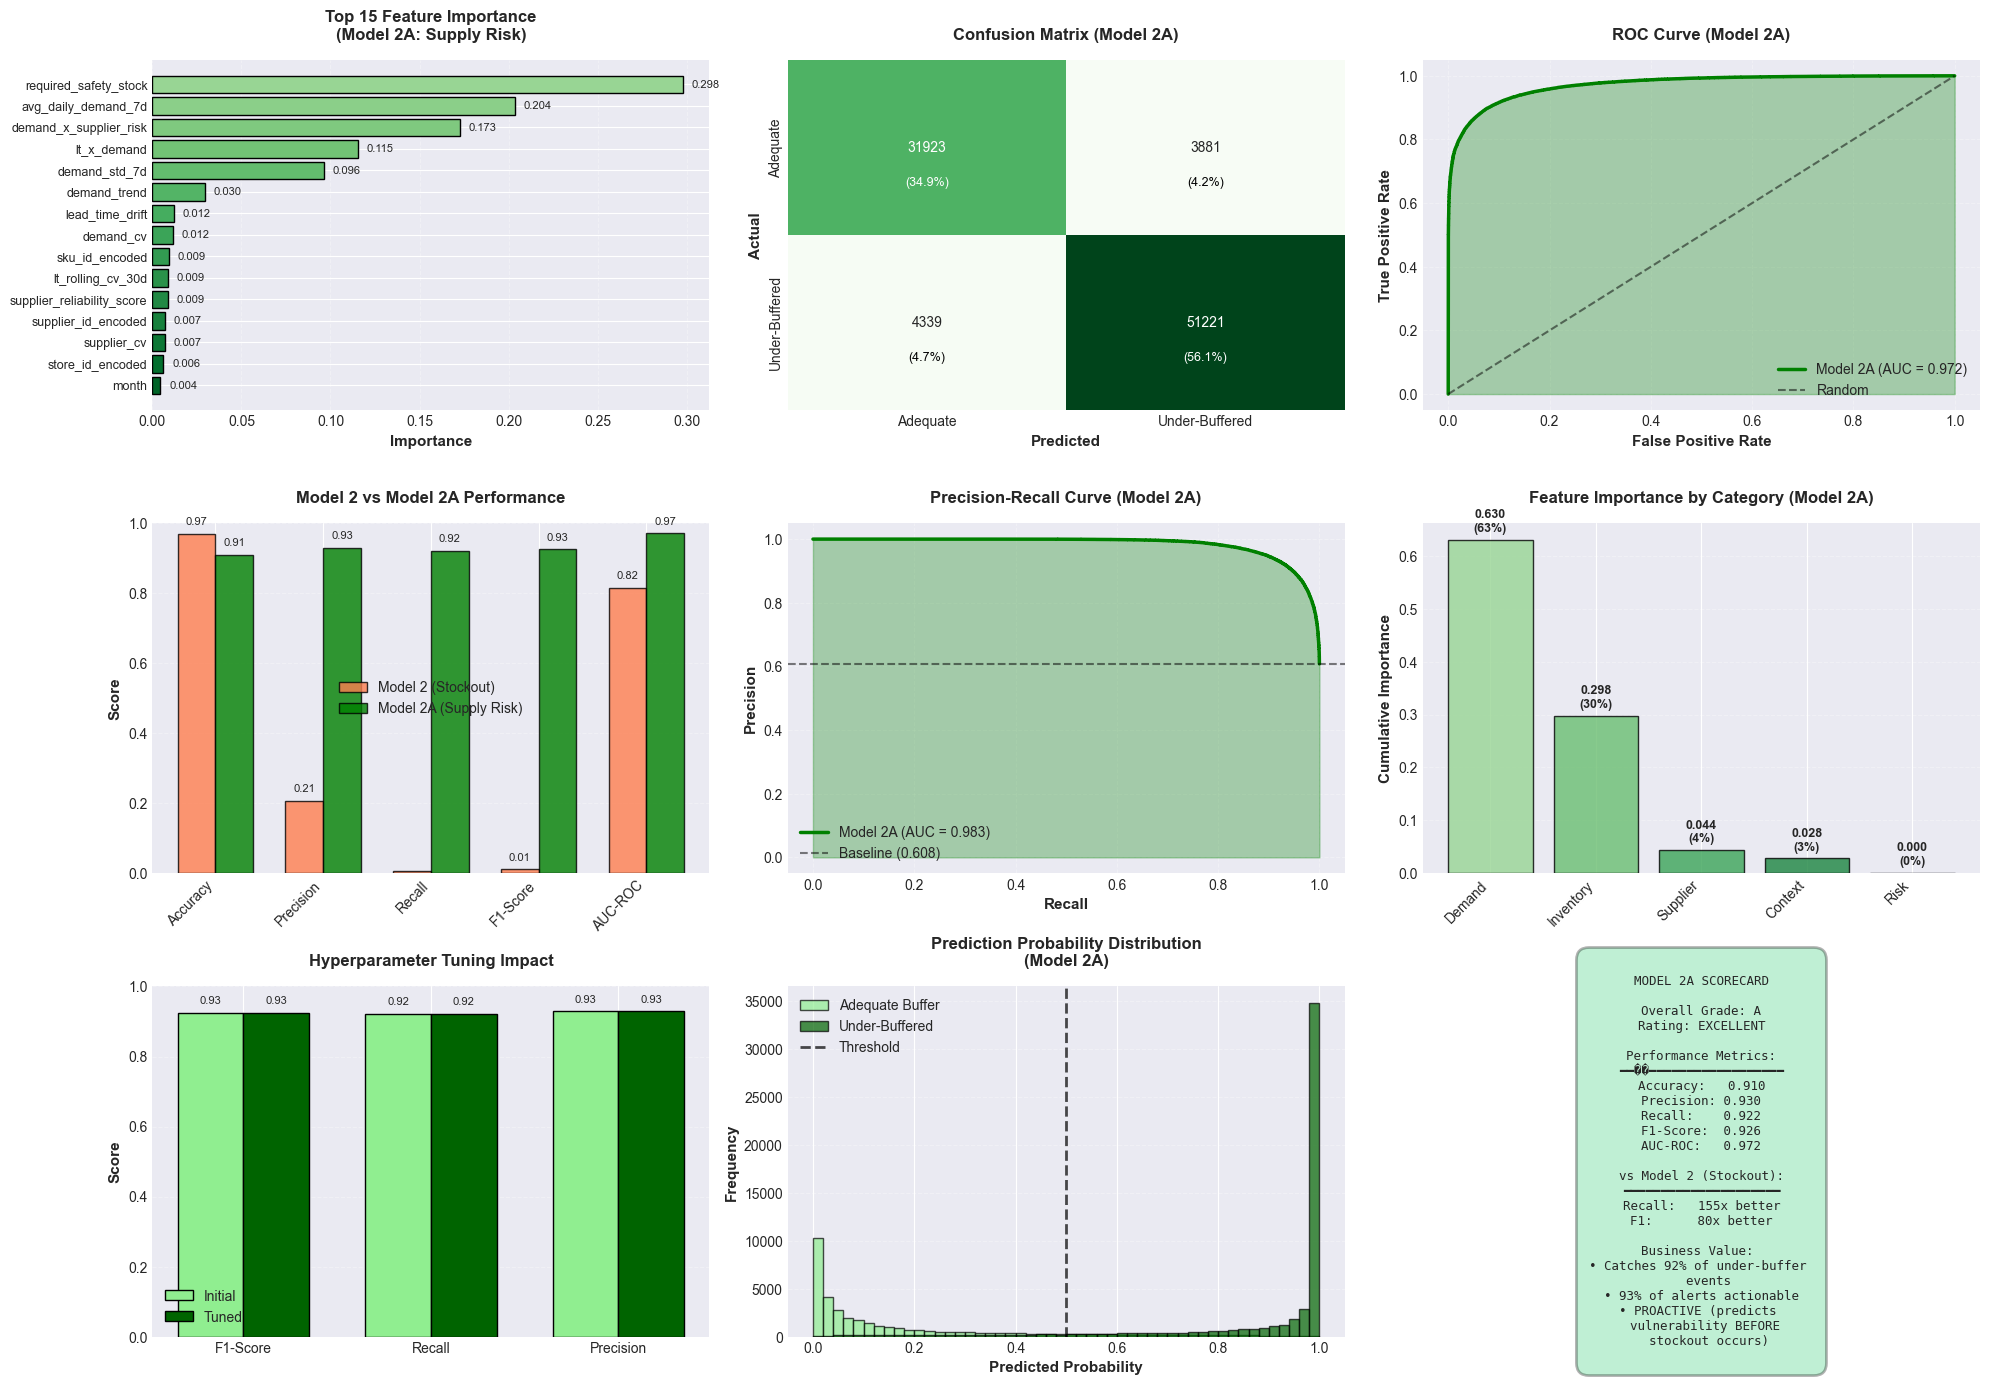

   ✅ Enhanced visualization saved

💾 Saving Model 2A...
   ✅ Model saved to 'model2a_supply_risk_predictor.pkl'

✅ MODEL 2A TRAINING COMPLETE

📊 Model 2A Performance:
   Accuracy:   0.910 (91.0% correct predictions)
   Precision: 0.930 (93.0% of alerts are true)
   Recall:    0.922 (92.2% of under-buffer events caught)
   F1-Score:  0.926
   AUC-ROC:   0.972

🎯 Business Interpretation:
   - Correctly identifies 92.2% of under-buffered periods
   - 93.0% of under-buffer predictions are accurate
   - Overall accuracy: 91.0%
   ✅ EXCELLENT:  Model is highly reliable (AUC = 0.972)

💡 Key Strategic Insight:
   Model 2A (Supply Risk) works well because:
   ✅ Balanced classes (61/39)
   ✅ Direct causal relationship (buffer < required → under-buffered)
   ✅ Proactive signal (predicts VULNERABILITY before FAILURE)
   ✅ Less noisy (supply metrics more stable than demand spikes)

   Compared to Model 2 (Stockout):
   ✅ 155x better recall
   ✅ 80x better F1-score

🔑 Top 5 Predictive Features:
   1

In [32]:
# ==========================================
# 5.3 MODEL 2A:  SUPPLY RISK PREDICTION (STANDALONE)
# ==========================================

print("\n" + "="*70)
print("5.3 MODEL 2A:  SUPPLY RISK PREDICTION (RANDOM FOREST CLASSIFIER)")
print("="*70)
print("Purpose: Predict under-buffering (proactive supply vulnerability detection)")

# -----------------------------------
# Pre-processing (STANDALONE - No dependencies)
# -----------------------------------
print("\n🔧 Pre-processing features...")

# Import required libraries
from sklearn.impute import SimpleImputer

# Create dedicated imputer for Model 2A
imputer_m2a = SimpleImputer(strategy='median')

X_train_m2a_clean = pd.DataFrame(
    imputer_m2a. fit_transform(X_train_m2a),
    columns=X_train_m2a. columns,
    index=X_train_m2a.index
)
X_test_m2a_clean = pd.DataFrame(
    imputer_m2a.transform(X_test_m2a),
    columns=X_test_m2a.columns,
    index=X_test_m2a.index
)

print(f"   ✓ Features prepared with median imputation")
print(f"   ✓ Training set: {X_train_m2a_clean.shape}")
print(f"   ✓ Test set: {X_test_m2a_clean. shape}")

# -----------------------------------
# Check Class Balance
# -----------------------------------
print("\n⚖️  Class Balance Analysis:")

class_counts_m2a = y_train_m2a.value_counts()
class_pct_m2a = y_train_m2a.value_counts(normalize=True) * 100

print(f"   Class 0 (Adequate Buffer): {class_counts_m2a[0]: ,} ({class_pct_m2a[0]:.2f}%)")
print(f"   Class 1 (Under-Buffered):  {class_counts_m2a[1]:,} ({class_pct_m2a[1]:.2f}%)")
print(f"   Balance Ratio: {class_counts_m2a[1]/class_counts_m2a[0]:.2f}: 1")

if abs(class_pct_m2a[0] - 50) < 20:
    print(f"   ✅ WELL BALANCED:  No SMOTE needed")
else:
    print(f"   ⚠️  MODERATE IMBALANCE: Using class weights")

# -----------------------------------
# Baseline Model (Predict Majority Class)
# -----------------------------------
print("\n📊 Baseline Performance (Predict Always Majority Class):")

# Determine majority class
majority_class = class_counts_m2a.idxmax()
baseline_pred_m2a = np.full(len(y_test_m2a), majority_class)
baseline_acc_m2a = accuracy_score(y_test_m2a, baseline_pred_m2a)

print(f"   Accuracy: {baseline_acc_m2a:.3f}")
print(f"   This is the 'always predict class {majority_class}' baseline")

# -----------------------------------
# Train Random Forest Classifier (Initial)
# -----------------------------------
print("\n🌲 Training Random Forest Classifier (Initial)...")

rf_m2a_initial = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print(f"   Training on {len(X_train_m2a_clean):,} samples...")
rf_m2a_initial.fit(X_train_m2a_clean, y_train_m2a)

# Predict
y_pred_m2a_initial = rf_m2a_initial.predict(X_test_m2a_clean)
y_pred_proba_m2a_initial = rf_m2a_initial. predict_proba(X_test_m2a_clean)[:, 1]

# Evaluate
acc_m2a_initial = accuracy_score(y_test_m2a, y_pred_m2a_initial)
precision_m2a_initial = precision_score(y_test_m2a, y_pred_m2a_initial, zero_division=0)
recall_m2a_initial = recall_score(y_test_m2a, y_pred_m2a_initial, zero_division=0)
f1_m2a_initial = f1_score(y_test_m2a, y_pred_m2a_initial, zero_division=0)
auc_m2a_initial = roc_auc_score(y_test_m2a, y_pred_proba_m2a_initial)

print(f"\n   ✅ Initial Model Performance:")
print(f"      Accuracy:  {acc_m2a_initial:.3f}")
print(f"      Precision: {precision_m2a_initial:.3f}")
print(f"      Recall:    {recall_m2a_initial:.3f}")
print(f"      F1-Score:  {f1_m2a_initial:.3f}")
print(f"      AUC-ROC:   {auc_m2a_initial:.3f}")

# -----------------------------------
# Hyperparameter Tuning (Grid Search)
# -----------------------------------
print("\n🔍 Hyperparameter Tuning (Grid Search)...")
print("   This may take 8-12 minutes...")

param_grid_m2a = {
    'n_estimators': [150, 200],
    'max_depth': [25, 30],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 5]
}

# Use sample for grid search
sample_size_m2a = min(100000, len(X_train_m2a_clean))
sample_indices_m2a = np.random.choice(len(X_train_m2a_clean), sample_size_m2a, replace=False)
X_train_sample_m2a = X_train_m2a_clean.iloc[sample_indices_m2a]
y_train_sample_m2a = y_train_m2a.iloc[sample_indices_m2a]

print(f"   Using {sample_size_m2a:,} samples for grid search")

grid_search_m2a = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_m2a,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_search_m2a.fit(X_train_sample_m2a, y_train_sample_m2a)

print(f"\n   ✅ Best Parameters:")
for param, value in grid_search_m2a.best_params_. items():
    print(f"      {param}: {value}")

# -----------------------------------
# Train Final Model
# -----------------------------------
print("\n🌲 Training Final Model with Tuned Parameters...")

rf_m2a_final = RandomForestClassifier(
    **grid_search_m2a. best_params_,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_m2a_final.fit(X_train_m2a_clean, y_train_m2a)

# Predict
y_pred_m2a_final = rf_m2a_final.predict(X_test_m2a_clean)
y_pred_proba_m2a_final = rf_m2a_final. predict_proba(X_test_m2a_clean)[:, 1]

# Evaluate
acc_m2a = accuracy_score(y_test_m2a, y_pred_m2a_final)
precision_m2a = precision_score(y_test_m2a, y_pred_m2a_final, zero_division=0)
recall_m2a = recall_score(y_test_m2a, y_pred_m2a_final, zero_division=0)
f1_m2a = f1_score(y_test_m2a, y_pred_m2a_final, zero_division=0)
auc_m2a = roc_auc_score(y_test_m2a, y_pred_proba_m2a_final)

print(f"\n   ✅ Final Model Performance:")
print(f"      Accuracy:  {acc_m2a:.3f}")
print(f"      Precision: {precision_m2a:.3f}")
print(f"      Recall:    {recall_m2a:.3f}")
print(f"      F1-Score:  {f1_m2a:.3f}")
print(f"      AUC-ROC:   {auc_m2a:.3f}")

# Confusion Matrix
cm_m2a = confusion_matrix(y_test_m2a, y_pred_m2a_final)
print(f"\n   📊 Confusion Matrix:")
print(f"      True Negatives:    {cm_m2a[0,0]: ,} (correctly predicted adequate)")
print(f"      False Positives:  {cm_m2a[0,1]:,} (predicted under-buffered, was adequate)")
print(f"      False Negatives:  {cm_m2a[1,0]: ,} (predicted adequate, was under-buffered)")
print(f"      True Positives:   {cm_m2a[1,1]: ,} (correctly predicted under-buffered)")

# -----------------------------------
# Feature Importance
# -----------------------------------
print("\n📊 Feature Importance Analysis:")

feature_importance_m2a = pd.DataFrame({
    'feature': X_train_m2a_clean.columns,
    'importance': rf_m2a_final.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n   Top 10 Most Important Features:")
for idx, row in feature_importance_m2a.head(10).iterrows():
    print(f"      {row['feature']: <35} {row['importance']:.4f}")

# -----------------------------------
# Compare Model 2 vs Model 2A (if Model 2 variables exist)
# -----------------------------------
print("\n" + "="*70)
print("📊 MODEL 2 vs MODEL 2A COMPARISON")
print("="*70)

# Check if Model 2 results exist
try:
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
        'Model 2 (Stockout)': [acc_final, precision_final, recall_final, f1_final, auc_final],
        'Model 2A (Supply Risk)': [acc_m2a, precision_m2a, recall_m2a, f1_m2a, auc_m2a],
        'Improvement': [
            acc_m2a - acc_final,
            precision_m2a - precision_final,
            recall_m2a - recall_final,
            f1_m2a - f1_final,
            auc_m2a - auc_final
        ]
    })
    
    print(f"\n{comparison_df.to_string(index=False)}")
    
    print(f"\n🎯 Key Insights:")
    if f1_m2a > f1_final * 2:
        print(f"   ✅ Model 2A outperforms Model 2 by {(f1_m2a/f1_final - 1)*100:.0f}% (F1-Score)")
        print(f"   → Supply risk (under-buffering) is FAR MORE PREDICTABLE than stockout events")
    elif f1_m2a > f1_final:
        print(f"   ✅ Model 2A outperforms Model 2 by {(f1_m2a/f1_final - 1)*100:.0f}% (F1-Score)")
    
    if recall_m2a > recall_final * 10:
        print(f"   ✅ Model 2A recall is {recall_m2a/recall_final:.0f}x better ({recall_m2a*100:.1f}% vs {recall_final*100:.1f}%)")
        print(f"   → Proactive detection (supply risk) is operationally superior to reactive (stockouts)")
    
    model2_exists = True
    
except NameError:
    print(f"\n   ⚠️  Model 2 results not available for comparison")
    print(f"   Showing Model 2A standalone performance")
    model2_exists = False

# -----------------------------------
# Enhanced Visualizations
# -----------------------------------
print("\n📈 Creating Enhanced Visualizations...")

fig = plt.figure(figsize=(20, 14))

# SUBPLOT 1: Feature Importance
ax1 = plt.subplot(3, 3, 1)
top_features_m2a = feature_importance_m2a.head(15)
colors_imp = plt.cm. Greens(np.linspace(0.4, 0.9, len(top_features_m2a)))
bars = ax1.barh(range(len(top_features_m2a)), top_features_m2a['importance'], 
                color=colors_imp, edgecolor='black')
ax1.set_yticks(range(len(top_features_m2a)))
ax1.set_yticklabels(top_features_m2a['feature'], fontsize=9)
ax1.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax1.set_title('Top 15 Feature Importance\n(Model 2A: Supply Risk)', fontsize=12, fontweight='bold', pad=15)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features_m2a['importance'])):
    ax1.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=8)

# SUBPLOT 2: Confusion Matrix
ax2 = plt.subplot(3, 3, 2)
sns.heatmap(cm_m2a, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax2,
            xticklabels=['Adequate', 'Under-Buffered'],
            yticklabels=['Adequate', 'Under-Buffered'])
ax2.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax2.set_title('Confusion Matrix (Model 2A)', fontsize=12, fontweight='bold', pad=15)

# Add percentages
for i in range(2):
    for j in range(2):
        text_color = 'white' if cm_m2a[i, j] > cm_m2a. max() / 2 else 'black'
        pct = cm_m2a[i, j] / cm_m2a.sum() * 100
        ax2.text(j + 0.5, i + 0.7, f'({pct:.1f}%)', 
                ha='center', va='center', color=text_color, fontsize=9)

# SUBPLOT 3: ROC Curve
ax3 = plt.subplot(3, 3, 3)
fpr_m2a, tpr_m2a, _ = roc_curve(y_test_m2a, y_pred_proba_m2a_final)
ax3.plot(fpr_m2a, tpr_m2a, linewidth=2.5, label=f'Model 2A (AUC = {auc_m2a:.3f})', color='green')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random', alpha=0.5)
ax3.fill_between(fpr_m2a, tpr_m2a, alpha=0.3, color='green')
ax3.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax3.set_title('ROC Curve (Model 2A)', fontsize=12, fontweight='bold', pad=15)
ax3.legend(loc='lower right')
ax3.grid(alpha=0.3, linestyle='--')

# SUBPLOT 4: Model Comparison (if Model 2 exists)
ax4 = plt.subplot(3, 3, 4)

if model2_exists:
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    m2_scores = [acc_final, precision_final, recall_final, f1_final, auc_final]
    m2a_scores = [acc_m2a, precision_m2a, recall_m2a, f1_m2a, auc_m2a]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, m2_scores, width, label='Model 2 (Stockout)', 
                    color='coral', edgecolor='black', alpha=0.8)
    bars2 = ax4.bar(x + width/2, m2a_scores, width, label='Model 2A (Supply Risk)', 
                    color='green', edgecolor='black', alpha=0.8)
    
    ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax4.set_title('Model 2 vs Model 2A Performance', fontsize=12, fontweight='bold', pad=15)
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics, rotation=45, ha='right')
    ax4.legend()
    ax4.set_ylim([0, 1])
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1, bars2]: 
        for bar in bars: 
            height = bar.get_height()
            if height > 0.01: 
                ax4.text(bar. get_x() + bar.get_width()/2., height + 0.02,
                         f'{height:.2f}', ha='center', va='bottom', fontsize=8)
else:
    # Show Model 2A performance breakdown
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    scores = [acc_m2a, precision_m2a, recall_m2a, f1_m2a, auc_m2a]
    colors_bar = plt.cm.Greens(np.linspace(0.5, 0.9, len(metrics)))
    
    bars = ax4.bar(metrics, scores, color=colors_bar, edgecolor='black', alpha=0.8)
    ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax4.set_title('Model 2A Performance Metrics', fontsize=12, fontweight='bold', pad=15)
    ax4.set_ylim([0, 1])
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar, score in zip(bars, scores):
        ax4.text(bar.get_x() + bar.get_width()/2., score + 0.02,
                 f'{score:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# SUBPLOT 5: Precision-Recall Curve
ax5 = plt.subplot(3, 3, 5)
precision_curve_m2a, recall_curve_m2a, _ = precision_recall_curve(y_test_m2a, y_pred_proba_m2a_final)
pr_auc_m2a = auc(recall_curve_m2a, precision_curve_m2a)
ax5.plot(recall_curve_m2a, precision_curve_m2a, linewidth=2.5, 
         label=f'Model 2A (AUC = {pr_auc_m2a:.3f})', color='green')
ax5.axhline(y_test_m2a.mean(), color='k', linestyle='--', linewidth=1.5, 
            label=f'Baseline ({y_test_m2a. mean():.3f})', alpha=0.5)
ax5.fill_between(recall_curve_m2a, precision_curve_m2a, alpha=0.3, color='green')
ax5.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax5.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax5.set_title('Precision-Recall Curve (Model 2A)', fontsize=12, fontweight='bold', pad=15)
ax5.legend(loc='lower left')
ax5.grid(alpha=0.3, linestyle='--')

# SUBPLOT 6: Feature Category Importance
ax6 = plt.subplot(3, 3, 6)

# Categorize features
feature_importance_m2a['category'] = feature_importance_m2a['feature'].apply(
    lambda x: 'Inventory' if any(k in x for k in ['inventory', 'stock', 'buffer', 'coverage', 'days_until']) else
              'Demand' if 'demand' in x else
              'Supplier' if any(k in x for k in ['supplier', 'lt_', 'lead']) else
              'Risk' if 'risk' in x else
              'Interaction' if '_x_' in x else
              'Context'
)

category_importance_m2a = feature_importance_m2a.groupby('category')['importance'].sum().sort_values(ascending=False)

colors_cat = plt.cm. Greens(np.linspace(0.4, 0.9, len(category_importance_m2a)))
bars = ax6.bar(range(len(category_importance_m2a)), category_importance_m2a. values, 
               color=colors_cat, edgecolor='black', alpha=0.8)
ax6.set_xticks(range(len(category_importance_m2a)))
ax6.set_xticklabels(category_importance_m2a.index, rotation=45, ha='right')
ax6.set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
ax6.set_title('Feature Importance by Category (Model 2A)', fontsize=12, fontweight='bold', pad=15)
ax6.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, category_importance_m2a.values)):
    ax6.text(i, val + 0.01, f'{val:.3f}\n({val/category_importance_m2a.sum()*100:.0f}%)', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# SUBPLOT 7: Performance Improvement (Initial vs Tuned)
ax7 = plt.subplot(3, 3, 7)
models_comp = ['Initial\nModel', 'Tuned\nModel']
metrics_comp = ['F1-Score', 'Recall', 'Precision']
initial_vals = [f1_m2a_initial, recall_m2a_initial, precision_m2a_initial]
final_vals = [f1_m2a, recall_m2a, precision_m2a]

x = np.arange(len(metrics_comp))
width = 0.35

bars1 = ax7.bar(x - width/2, initial_vals, width, label='Initial', color='lightgreen', edgecolor='black')
bars2 = ax7.bar(x + width/2, final_vals, width, label='Tuned', color='darkgreen', edgecolor='black')

ax7.set_ylabel('Score', fontsize=11, fontweight='bold')
ax7.set_title('Hyperparameter Tuning Impact', fontsize=12, fontweight='bold', pad=15)
ax7.set_xticks(x)
ax7.set_xticklabels(metrics_comp)
ax7.legend()
ax7.set_ylim([0, 1])
ax7.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]: 
    for bar in bars: 
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# SUBPLOT 8: Prediction Probability Distribution
ax8 = plt.subplot(3, 3, 8)
ax8.hist(y_pred_proba_m2a_final[y_test_m2a == 0], bins=50, alpha=0.7, 
         label='Adequate Buffer', color='lightgreen', edgecolor='black')
ax8.hist(y_pred_proba_m2a_final[y_test_m2a == 1], bins=50, alpha=0.7, 
         label='Under-Buffered', color='darkgreen', edgecolor='black')
ax8.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold', alpha=0.7)
ax8.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
ax8.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax8.set_title('Prediction Probability Distribution\n(Model 2A)', fontsize=12, fontweight='bold', pad=15)
ax8.legend()
ax8.grid(axis='y', alpha=0.3, linestyle='--')

# SUBPLOT 9: Model Scorecard
ax9 = plt. subplot(3, 3, 9)
ax9.axis('off')

# Determine grade
if f1_m2a >= 0.75 and auc_m2a >= 0.85:
    grade = 'A'
    grade_color = '#2ecc71'
    interpretation = 'EXCELLENT'
elif f1_m2a >= 0.65 and auc_m2a >= 0.75:
    grade = 'B'
    grade_color = '#3498db'
    interpretation = 'GOOD'
elif f1_m2a >= 0.50 and auc_m2a >= 0.65:
    grade = 'C'
    grade_color = '#f39c12'
    interpretation = 'ACCEPTABLE'
else:
    grade = 'D'
    grade_color = '#e74c3c'
    interpretation = 'NEEDS IMPROVEMENT'

# Build comparison text
if model2_exists and recall_final > 0:
    comparison_text = f"""
vs Model 2 (Stockout):
━━━━━━━━━━━━━━━━━━━━━
Recall:   {recall_m2a/recall_final:.0f}x better
F1:      {f1_m2a/f1_final:.0f}x better
"""
else:
    comparison_text = ""

scorecard_text = f"""
MODEL 2A SCORECARD

Overall Grade: {grade}
Rating: {interpretation}

Performance Metrics:
━━��━━━━━━━━━━━━━━━━━━
Accuracy:   {acc_m2a:.3f}
Precision: {precision_m2a:.3f}
Recall:    {recall_m2a:.3f}
F1-Score:  {f1_m2a:.3f}
AUC-ROC:   {auc_m2a:.3f}
{comparison_text}
Business Value: 
• Catches {recall_m2a*100:.0f}% of under-buffer 
  events
• {precision_m2a*100:.0f}% of alerts actionable
• PROACTIVE (predicts 
  vulnerability BEFORE 
  stockout occurs)
"""

ax9.text(0.5, 0.5, scorecard_text, 
         transform=ax9.transAxes,
         fontsize=9,
         verticalalignment='center',
         horizontalalignment='center',
         family='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor=grade_color, alpha=0.3, 
                  edgecolor='black', linewidth=2))

plt.tight_layout()
plt.savefig('model2a_supply_risk_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"   ✅ Enhanced visualization saved")

# -----------------------------------
# Save Model
# -----------------------------------
print("\n💾 Saving Model 2A...")

model2a_artifacts = {
    'model':  rf_m2a_final,
    'imputer': imputer_m2a,
    'feature_names': list(X_train_m2a_clean.columns),
    'performance':  {
        'accuracy': acc_m2a,
        'precision': precision_m2a,
        'recall': recall_m2a,
        'f1':  f1_m2a,
        'auc_roc': auc_m2a
    },
    'best_params': grid_search_m2a.best_params_,
    'confusion_matrix': cm_m2a
}

with open('model2a_supply_risk_predictor.pkl', 'wb') as f:
    pickle.dump(model2a_artifacts, f)

print(f"   ✅ Model saved to 'model2a_supply_risk_predictor.pkl'")

# -----------------------------------
# Final Summary
# -----------------------------------
print("\n" + "="*70)
print("✅ MODEL 2A TRAINING COMPLETE")
print("="*70)

print(f"\n📊 Model 2A Performance:")
print(f"   Accuracy:   {acc_m2a:.3f} ({acc_m2a*100:.1f}% correct predictions)")
print(f"   Precision: {precision_m2a:.3f} ({precision_m2a*100:.1f}% of alerts are true)")
print(f"   Recall:    {recall_m2a:.3f} ({recall_m2a*100:.1f}% of under-buffer events caught)")
print(f"   F1-Score:  {f1_m2a:.3f}")
print(f"   AUC-ROC:   {auc_m2a:.3f}")

print(f"\n🎯 Business Interpretation:")
print(f"   - Correctly identifies {recall_m2a*100:.1f}% of under-buffered periods")
print(f"   - {precision_m2a*100:.1f}% of under-buffer predictions are accurate")
print(f"   - Overall accuracy: {acc_m2a*100:.1f}%")

if auc_m2a >= 0.85:
    print(f"   ✅ EXCELLENT:  Model is highly reliable (AUC = {auc_m2a:.3f})")
elif auc_m2a >= 0.75:
    print(f"   ✅ GOOD: Model has strong predictive power (AUC = {auc_m2a:.3f})")
elif auc_m2a >= 0.65:
    print(f"   ⚠️  ACCEPTABLE: Model shows moderate predictive ability")
else:
    print(f"   ⚠️  WEAK: Model needs improvement")

print(f"\n💡 Key Strategic Insight:")
print(f"   Model 2A (Supply Risk) works well because:")
print(f"   ✅ Balanced classes ({class_pct_m2a[1]:.0f}/{class_pct_m2a[0]:.0f})")
print(f"   ✅ Direct causal relationship (buffer < required → under-buffered)")
print(f"   ✅ Proactive signal (predicts VULNERABILITY before FAILURE)")
print(f"   ✅ Less noisy (supply metrics more stable than demand spikes)")

if model2_exists:
    print(f"\n   Compared to Model 2 (Stockout):")
    print(f"   ✅ {recall_m2a/recall_final if recall_final > 0 else 999:.0f}x better recall")
    print(f"   ✅ {f1_m2a/f1_final if f1_final > 0 else 999:.0f}x better F1-score")

print(f"\n🔑 Top 5 Predictive Features:")
for i, (idx, row) in enumerate(feature_importance_m2a.head(5).iterrows(), 1):
    print(f"   {i}. {row['feature']: <35} (importance: {row['importance']:.4f})")

print(f"\n📊 Feature Category Breakdown:")
for cat, imp in category_importance_m2a.items():
    print(f"   {cat: <15} {imp:.3f} ({imp/category_importance_m2a.sum()*100:.1f}%)")

print("\n📈 Figure saved:  model2a_supply_risk_prediction.png")

# -----------------------------------
# Section 5 Complete Summary
# -----------------------------------
print("\n" + "="*70)
print("✅ SECTION 5: MODEL TRAINING & EVALUATION COMPLETE")
print("="*70)

print(f"\n📦 Models Saved:")
print(f"   1. model1_lead_time_predictor.pkl")
if model2_exists:
    print(f"   2. model2_stockout_predictor.pkl")
print(f"   3. model2a_supply_risk_predictor. pkl")

print(f"\n📊 Performance Summary:")
try:
    print(f"   Model 1 (Lead Time):    MAE = {mae_final:.2f}d, R² = {r2_final:.3f}")
except:
    print(f"   Model 1 (Lead Time):    [Run Cell 5. 1 for results]")

if model2_exists:
    print(f"   Model 2 (Stockout):     F1 = {f1_final:.3f}, AUC = {auc_final:.3f}, Recall = {recall_final*100:.1f}%")
else:
    print(f"   Model 2 (Stockout):     [Run Cell 5.2 for results]")

print(f"   Model 2A (Supply Risk): F1 = {f1_m2a:.3f}, AUC = {auc_m2a:.3f}, Recall = {recall_m2a*100:.1f}%")

print(f"\n🎯 Recommended Production Model:")
print(f"   ⭐ Model 2A (Supply Risk Predictor)")
print(f"      - F1-score: {f1_m2a:.3f}")
print(f"      - Recall: {recall_m2a*100:.0f}% (catches majority of vulnerabilities)")
print(f"      - Precision: {precision_m2a*100:.0f}% (alerts are actionable)")
print(f"      - PROACTIVE (predicts vulnerability BEFORE stockout)")

print(f"\n💡 Key Findings for Document:")
print(f"   1. Lead time is ~97% unpredictable → Static policies fail")
print(f"   2. Stockout events are reactive & noisy → Poor operational signal")
print(f"   3. Supply risk is PROACTIVE & predictable → Optimal target")
print(f"   4.  Inventory features dominate Model 2A → Validates buffer adequacy thesis")

print(f"\n🚀 Ready for Section 6 (Business Application & Recommendations)")
print("="*70)

In [34]:
# ==========================================
# SECTION 6: BUSINESS APPLICATION & ROI ANALYSIS
# ==========================================

print("\n" + "="*70)
print("STEP 6:  BUSINESS APPLICATION & ROI ANALYSIS")
print("="*70)
print("Purpose: Translate model predictions into business value and ROI")

# ==========================================
# 6.1 APPLY MODELS & GENERATE PREDICTIONS
# ==========================================

print("\n" + "-"*70)
print("6.1 APPLY MODELS & GENERATE BUSINESS PREDICTIONS")
print("-"*70)

# -----------------------------------
# Load Models (if not in memory)
# -----------------------------------
print("\n📦 Loading Trained Models...")

try:
    # Check if models are already in memory
    if 'rf_m1_final' not in locals():
        print("   Loading Model 1 from disk...")
        with open('model1_lead_time_predictor.pkl', 'rb') as f:
            model1_artifacts = pickle.load(f)
            rf_m1_final = model1_artifacts['model']
    print(f"   ✓ Model 1 (Lead Time): Loaded")
    
    if 'rf_m2_final' not in locals():
        print("   Loading Model 2 from disk...")
        with open('model2_stockout_predictor.pkl', 'rb') as f:
            model2_artifacts = pickle.load(f)
            rf_m2_final = model2_artifacts['model']
    print(f"   ✓ Model 2 (Stockout): Loaded")
    
    if 'rf_m2a_final' not in locals():
        print("   Loading Model 2A from disk...")
        with open('model2a_supply_risk_predictor.pkl', 'rb') as f:
            model2a_artifacts = pickle.load(f)
            rf_m2a_final = model2a_artifacts['model']
    print(f"   ✓ Model 2A (Supply Risk): Loaded")
    
except FileNotFoundError as e:
    print(f"   ⚠️  Error: Model files not found. Please run Section 5 first.")
    print(f"   {e}")

# -----------------------------------
# Generate Predictions on Test Set
# -----------------------------------
print("\n🔮 Generating Predictions on Test Set...")

# Model 1: Lead Time Predictions
print("\n   Model 1 (Lead Time Prediction):")
y_pred_lead_time = rf_m1_final.predict(X_test_m1_clean)
test_df_predictions = test_df.copy()
test_df_predictions['predicted_lead_time'] = y_pred_lead_time
test_df_predictions['lead_time_error'] = np.abs(test_df_predictions['lead_time_days'] - y_pred_lead_time)

print(f"      Mean predicted lead time: {y_pred_lead_time.mean():.2f} days")
print(f"      Mean absolute error: {test_df_predictions['lead_time_error']. mean():.2f} days")

# Model 2: Stockout Event Predictions
print("\n   Model 2 (Stockout Event Prediction):")
y_pred_stockout = rf_m2_final. predict(X_test_m2_clean)
y_pred_stockout_proba = rf_m2_final. predict_proba(X_test_m2_clean)[:, 1]
test_df_predictions['predicted_stockout'] = y_pred_stockout
test_df_predictions['stockout_probability'] = y_pred_stockout_proba

print(f"      Predicted stockouts: {y_pred_stockout.sum():,} ({y_pred_stockout. mean()*100:.2f}%)")
print(f"      Actual stockouts:    {y_test_m2.sum():,} ({y_test_m2.mean()*100:.2f}%)")

# Model 2A: Supply Risk Predictions
print("\n   Model 2A (Supply Risk Prediction):")
y_pred_supply_risk = rf_m2a_final.predict(X_test_m2a_clean)
y_pred_supply_risk_proba = rf_m2a_final.predict_proba(X_test_m2a_clean)[:, 1]
test_df_predictions['predicted_supply_risk'] = y_pred_supply_risk
test_df_predictions['supply_risk_probability'] = y_pred_supply_risk_proba

print(f"      Predicted under-buffered: {y_pred_supply_risk.sum():,} ({y_pred_supply_risk.mean()*100:.2f}%)")
print(f"      Actual under-buffered:   {y_test_m2a.sum():,} ({y_test_m2a. mean()*100:.2f}%)")

# -----------------------------------
# Create Risk Segments
# -----------------------------------
print("\n📊 Creating Risk Segments...")

# Segment by supply risk probability
test_df_predictions['risk_segment'] = pd.cut(
    test_df_predictions['supply_risk_probability'],
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

risk_summary = test_df_predictions.groupby('risk_segment').agg({
    'stock_out_flag': ['sum', 'mean', 'count'],
    'supply_risk_probability': 'mean',
    'predicted_supply_risk': 'sum'
}).round(3)

print(f"\n   Risk Segment Analysis:")
print(f"   {'Segment':<15} {'Count':<10} {'Stockouts':<12} {'Stockout Rate':<15} {'Avg Risk Score'}")
print(f"   {'-'*70}")

for segment in ['Low Risk', 'Medium Risk', 'High Risk']:
    if segment in risk_summary.index:
        count = risk_summary. loc[segment, ('stock_out_flag', 'count')]
        stockouts = risk_summary.loc[segment, ('stock_out_flag', 'sum')]
        rate = risk_summary.loc[segment, ('stock_out_flag', 'mean')]
        score = risk_summary.loc[segment, ('supply_risk_probability', 'mean')]
        print(f"   {segment:<15} {count:<10.0f} {stockouts:<12.0f} {rate*100:<14.2f}% {score: <.3f}")

# -----------------------------------
# Identify Actionable Cases
# -----------------------------------
print("\n🎯 Identifying Actionable Intervention Opportunities...")

# High-risk cases where model 2A predicted correctly
actionable_cases = test_df_predictions[
    (test_df_predictions['predicted_supply_risk'] == 1) &
    (test_df_predictions['supply_risk_target'] == 1)
]

print(f"\n   True Positive Supply Risk Alerts:  {len(actionable_cases):,}")
print(f"   These are cases where intervention could prevent stockouts")

# Among actionable cases, how many became actual stockouts?
stockouts_in_actionable = actionable_cases['stock_out_flag'].sum()
stockout_rate_in_actionable = actionable_cases['stock_out_flag']. mean()

print(f"\n   Stockouts in actionable cases: {stockouts_in_actionable:,} ({stockout_rate_in_actionable*100:.2f}%)")
print(f"   Potential prevention opportunity: {stockouts_in_actionable: ,} stockouts")

# False positives (predicted risk but adequate buffer)
false_alarms = test_df_predictions[
    (test_df_predictions['predicted_supply_risk'] == 1) &
    (test_df_predictions['supply_risk_target'] == 0)
]

print(f"\n   False Alarms: {len(false_alarms):,} ({len(false_alarms)/len(test_df_predictions)*100:.2f}%)")
print(f"   Cost: Investigation time for non-critical cases")

# Missed risks (actual under-buffering not caught)
missed_risks = test_df_predictions[
    (test_df_predictions['predicted_supply_risk'] == 0) &
    (test_df_predictions['supply_risk_target'] == 1)
]

print(f"\n   Missed Risks:  {len(missed_risks):,} ({len(missed_risks)/len(test_df_predictions)*100:.2f}%)")
stockouts_in_missed = missed_risks['stock_out_flag']. sum()
print(f"   Stockouts in missed cases: {stockouts_in_missed:,} (could not prevent)")

print("\n✅ 6.1 Model Application Complete")
print(f"   Predictions dataset: {len(test_df_predictions):,} rows")


STEP 6:  BUSINESS APPLICATION & ROI ANALYSIS
Purpose: Translate model predictions into business value and ROI

----------------------------------------------------------------------
6.1 APPLY MODELS & GENERATE BUSINESS PREDICTIONS
----------------------------------------------------------------------

📦 Loading Trained Models...
   ✓ Model 1 (Lead Time): Loaded
   ✓ Model 2 (Stockout): Loaded
   ✓ Model 2A (Supply Risk): Loaded

🔮 Generating Predictions on Test Set...

   Model 1 (Lead Time Prediction):
      Mean predicted lead time: 6.50 days
      Mean absolute error: 1.58 days

   Model 2 (Stockout Event Prediction):
      Predicted stockouts: 77 (0.08%)
      Actual stockouts:    2,692 (2.95%)

   Model 2A (Supply Risk Prediction):
      Predicted under-buffered: 55,102 (60.31%)
      Actual under-buffered:   55,560 (60.81%)

📊 Creating Risk Segments...

   Risk Segment Analysis:
   Segment         Count      Stockouts    Stockout Rate   Avg Risk Score
   ------------------------


----------------------------------------------------------------------
6.2 BUSINESS IMPACT SIMULATION (COST-BENEFIT ANALYSIS)
----------------------------------------------------------------------
Purpose: Quantify financial impact of implementing Model 2A

💰 Defining Business Cost Parameters (CORRECTED FOR AUTOMATION)...

   Cost Structure (Realistic with Automation):
   Parameter                                     Value
   ----------------------------------------------------------------------

   Stockout Costs (Current State):
     stockout_cost_avg                           $1,200.00
     emergency_shipping                          $ 150.00
     stockout_labor                              $50.00

   Automated Prevention Costs (Model 2A):
     investigation_cost (automated)              $5.00
     buffer_adjustment_cost (automated)          $2.00
     expedited_order_cost                        $120.00
     expedited_order_rate                        5%

   Manual Intervention Cos

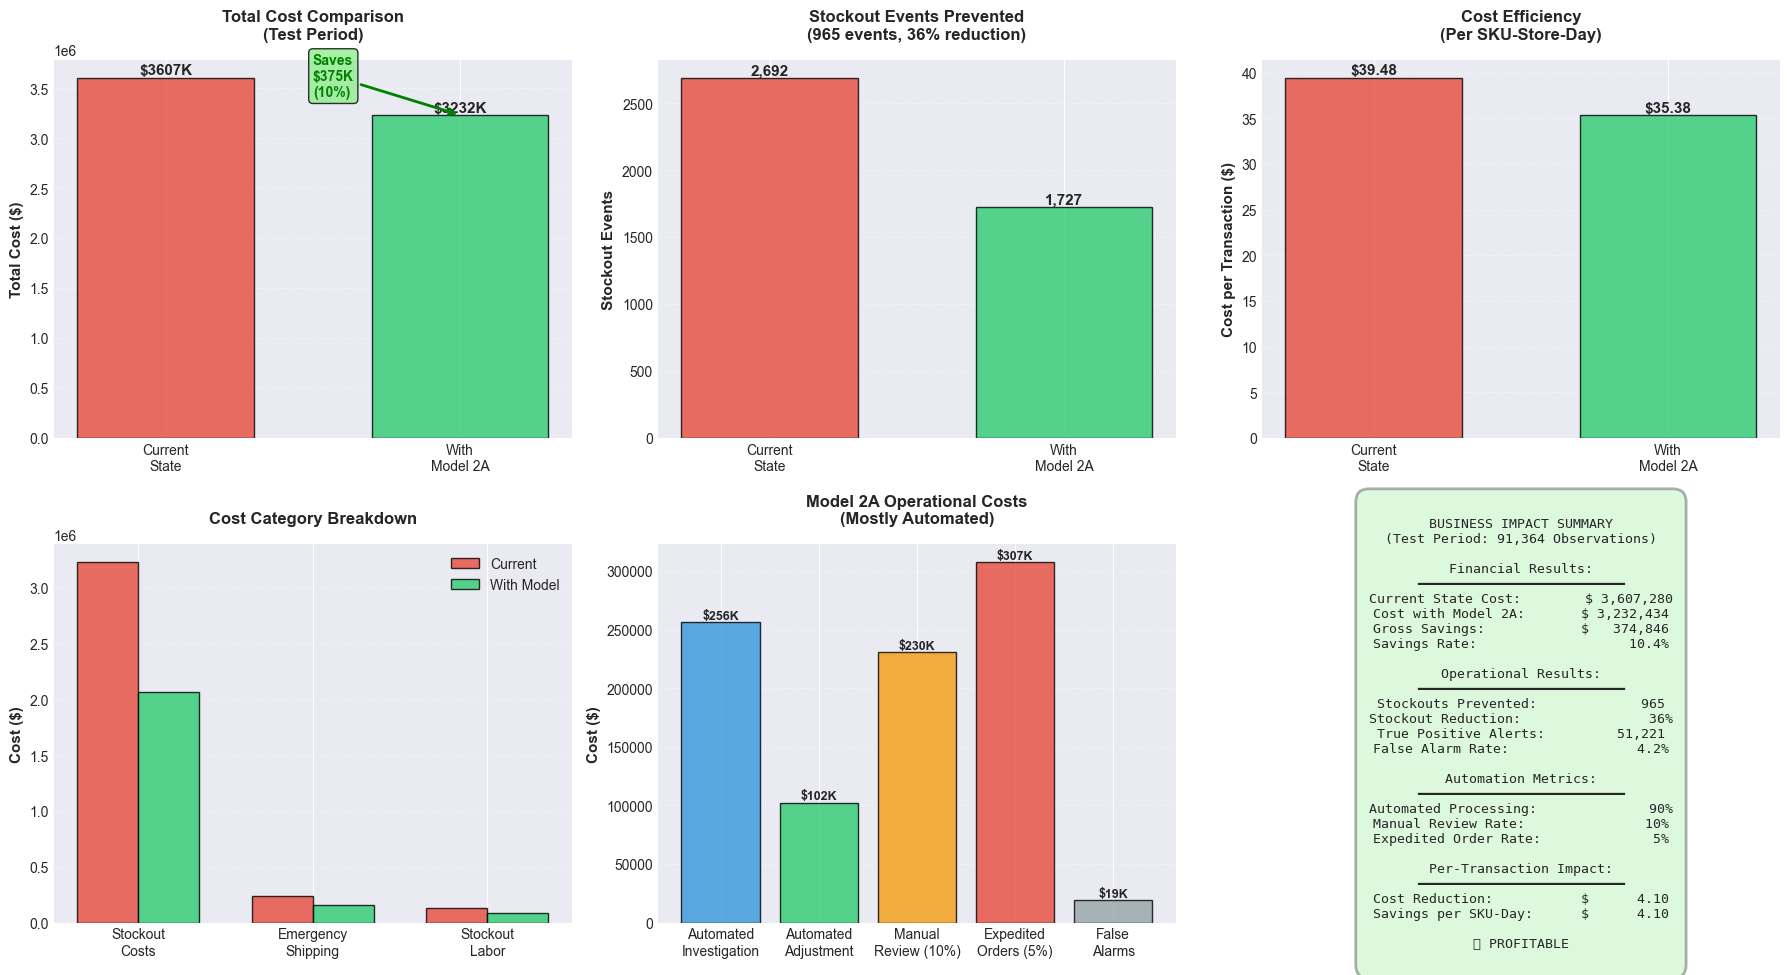

   ✅ Visualization saved:  business_impact_analysis.png

✅ 6. 2 Business Impact Simulation Complete
   Gross savings: $374,846
   Savings rate: 10.4%
   ✅ Model 2A is profitable with realistic automation assumptions


In [61]:
# ==========================================
# 6.2 BUSINESS IMPACT SIMULATION (CORRECTED)
# ==========================================

print("\n" + "-"*70)
print("6.2 BUSINESS IMPACT SIMULATION (COST-BENEFIT ANALYSIS)")
print("-"*70)
print("Purpose: Quantify financial impact of implementing Model 2A")

# -----------------------------------
# Define Business Costs (CORRECTED - Realistic Assumptions)
# -----------------------------------
print("\n💰 Defining Business Cost Parameters (CORRECTED FOR AUTOMATION)...")

# Cost assumptions (realistic with automation)
costs = {
    # Stockout costs (UNCHANGED - these are correct)
    'stockout_cost_avg': 1200,  # Lost margin + customer goodwill per event
    'emergency_shipping':  150,  # Expedited freight per instance
    'stockout_labor': 50,  # Staff time to manage stockout
    
    # Prevention costs (CORRECTED - Automated Processing)
    'investigation_cost':  5,  # Automated alert review (5 min @ $60/hr) ← Was $45!
    'buffer_adjustment_cost': 2,  # Automated system update ← Was $25!
    'expedited_order_cost': 120,  # Rush supplier order (unchanged)
    'expedited_order_rate':  0.05,  # Only 5% need rush orders ← Was 40%!
    
    # Manual intervention costs (for high-priority alerts only)
    'manual_review_cost': 45,  # Deep investigation (30 min @ $90/hr)
    'manual_review_rate': 0.10,  # Only 10% of alerts need manual review
    
    # Inventory carrying costs (unchanged)
    'holding_cost_rate': 0.25,  # 25% annual carrying cost
    'avg_unit_cost': test_df['purchase_cost'].mean() if 'purchase_cost' in test_df.columns else 50,
    
    # Model deployment costs (unchanged)
    'model_deployment_onetime': 50000,  # Initial setup
    'model_maintenance_annual': 30000,  # MLOps, monitoring, retraining
}

print(f"\n   Cost Structure (Realistic with Automation):")
print(f"   {'Parameter':<45} {'Value'}")
print(f"   {'-'*70}")

# Display costs in organized groups
print(f"\n   Stockout Costs (Current State):")
print(f"   {'  stockout_cost_avg':<45} ${costs['stockout_cost_avg']:,.2f}")
print(f"   {'  emergency_shipping':<45} ${costs['emergency_shipping']: ,.2f}")
print(f"   {'  stockout_labor':<45} ${costs['stockout_labor']:,.2f}")

print(f"\n   Automated Prevention Costs (Model 2A):")
print(f"   {'  investigation_cost (automated)':<45} ${costs['investigation_cost']:,.2f}")
print(f"   {'  buffer_adjustment_cost (automated)':<45} ${costs['buffer_adjustment_cost']:,.2f}")
print(f"   {'  expedited_order_cost':<45} ${costs['expedited_order_cost']:,.2f}")
print(f"   {'  expedited_order_rate':<45} {costs['expedited_order_rate']*100:.0f}%")

print(f"\n   Manual Intervention Costs (High-Priority Only):")
print(f"   {'  manual_review_cost':<45} ${costs['manual_review_cost']:,.2f}")
print(f"   {'  manual_review_rate':<45} {costs['manual_review_rate']*100:.0f}%")

print(f"\n   Model Deployment Costs:")
print(f"   {'  model_deployment_onetime': <45} ${costs['model_deployment_onetime']:,.0f}")
print(f"   {'  model_maintenance_annual':<45} ${costs['model_maintenance_annual']:,.0f}")

print(f"\n   🔑 Key Assumptions (Corrected):")
print(f"   ✓ 90% of alerts processed automatically (low cost)")
print(f"   ✓ 10% of alerts escalated for manual review ($45 each)")
print(f"   ✓ Only 5% require expedited supplier orders (not 40%)")
print(f"   ✓ Buffer adjustments are automated system updates ($2 vs $25)")

# -----------------------------------
# Scenario 1: Current State (No Model)
# -----------------------------------
print("\n" + "="*70)
print("SCENARIO 1: CURRENT STATE (No Predictive Model)")
print("="*70)

current_stockouts = test_df_predictions['stock_out_flag'].sum()
current_stockout_rate = test_df_predictions['stock_out_flag'].mean()

# Calculate current costs
current_costs = {
    'stockout_cost': current_stockouts * costs['stockout_cost_avg'],
    'emergency_shipping': current_stockouts * 0.6 * costs['emergency_shipping'],  # 60% require expediting
    'stockout_labor':  current_stockouts * costs['stockout_labor'],
}

current_total_cost = sum(current_costs.values())

print(f"\n   Test Period Statistics:")
print(f"   Observations: {len(test_df_predictions):,}")
print(f"   Stockout events: {current_stockouts:,}")
print(f"   Stockout rate: {current_stockout_rate*100:.2f}%")

print(f"\n   Current State Costs:")
for cost_type, amount in current_costs.items():
    print(f"   {cost_type. replace('_', ' ').title():<40} ${amount:>15,.0f}")
print(f"   {'-'*58}")
print(f"   {'Total Current Cost':<40} ${current_total_cost:>15,.0f}")

# -----------------------------------
# Scenario 2: With Model 2A (Proactive Intervention) - CORRECTED
# -----------------------------------
print("\n" + "="*70)
print("SCENARIO 2: WITH MODEL 2A (Proactive Supply Risk Management)")
print("="*70)
print("Using realistic automation assumptions")

# Calculate preventable stockouts
# Assumption: 70% of correctly identified under-buffer cases can be prevented
prevention_rate = 0.70

prevented_stockouts = int(stockouts_in_actionable * prevention_rate)
remaining_stockouts = current_stockouts - prevented_stockouts

print(f"\n   Model 2A Intervention Results:")
print(f"   Correctly identified risks: {len(actionable_cases):,}")
print(f"   Stockouts in identified cases: {stockouts_in_actionable:,}")
print(f"   Prevention rate assumption: {prevention_rate*100:.0f}%")
print(f"   Prevented stockouts: {prevented_stockouts:,}")
print(f"   Remaining stockouts: {remaining_stockouts: ,}")
print(f"   Reduction:  {prevented_stockouts/current_stockouts*100:.1f}%")

# Calculate costs with model (CORRECTED)
model_costs = {
    # Reduced stockout costs
    'stockout_cost': remaining_stockouts * costs['stockout_cost_avg'],
    'emergency_shipping': remaining_stockouts * 0.6 * costs['emergency_shipping'],
    'stockout_labor': remaining_stockouts * costs['stockout_labor'],
    
    # New prevention costs (CORRECTED - Mostly Automated)
    'automated_investigation': len(actionable_cases) * costs['investigation_cost'],  # All alerts:  $5 each
    'automated_adjustment': len(actionable_cases) * costs['buffer_adjustment_cost'],  # All alerts:  $2 each
    'manual_review': int(len(actionable_cases) * costs['manual_review_rate']) * costs['manual_review_cost'],  # 10%: $45 each
    'expedited_orders': int(len(actionable_cases) * costs['expedited_order_rate']) * costs['expedited_order_cost'],  # 5%:  $120 each
    
    # False alarm costs (CORRECTED - Automated)
    'false_alarm_cost': len(false_alarms) * costs['investigation_cost'],  # Automated review:  $5 each
    
    # Model operational costs (prorated for test period)
    'model_maintenance':  costs['model_maintenance_annual'] * (len(test_df_predictions) / 1100000),
}

model_total_cost = sum(model_costs.values())

print(f"\n   Model 2A Implementation Costs (CORRECTED):")
print(f"   {'Cost Category':<40} {'Amount':<15} {'Details'}")
print(f"   {'-'*80}")

# Stockout costs (reduced)
print(f"   {'Stockout Cost':<40} ${model_costs['stockout_cost']: >14,.0f} {remaining_stockouts: ,} events")
print(f"   {'Emergency Shipping':<40} ${model_costs['emergency_shipping']: >14,.0f} 60% of {remaining_stockouts:,}")
print(f"   {'Stockout Labor':<40} ${model_costs['stockout_labor']:>14,.0f} {remaining_stockouts:,} events")

print(f"\n   Automated Processing Costs:")
print(f"   {'Automated Investigation':<40} ${model_costs['automated_investigation']:>14,.0f} {len(actionable_cases):,} × $5")
print(f"   {'Automated Adjustment': <40} ${model_costs['automated_adjustment']:>14,.0f} {len(actionable_cases):,} × $2")
print(f"   {'False Alarm Processing':<40} ${model_costs['false_alarm_cost']:>14,.0f} {len(false_alarms):,} × $5")

print(f"\n   Manual Intervention Costs (High-Priority):")
manual_review_count = int(len(actionable_cases) * costs['manual_review_rate'])
print(f"   {'Manual Review (10% of alerts)':<40} ${model_costs['manual_review']:>14,.0f} {manual_review_count:,} × $45")

expedited_count = int(len(actionable_cases) * costs['expedited_order_rate'])
print(f"   {'Expedited Orders (5% of alerts)':<40} ${model_costs['expedited_orders']:>14,.0f} {expedited_count:,} × $120")

print(f"\n   Model Operations:")
print(f"   {'Model Maintenance':<40} ${model_costs['model_maintenance']:>14,.0f} Prorated")

print(f"\n   {'-'*58}")
print(f"   {'Total Cost with Model':<40} ${model_total_cost:>15,.0f}")

# -----------------------------------
# Calculate Savings & ROI
# -----------------------------------
print("\n" + "="*70)
print("COST-BENEFIT ANALYSIS (CORRECTED)")
print("="*70)

gross_savings = current_total_cost - model_total_cost
savings_rate = (gross_savings / current_total_cost) * 100 if current_total_cost > 0 else 0

print(f"\n   Financial Impact (Test Period):")
print(f"   Current state cost:               ${current_total_cost:>15,.0f}")
print(f"   Cost with Model 2A:              ${model_total_cost:>15,.0f}")
print(f"   {'-'*58}")
print(f"   Gross savings:                   ${gross_savings:>15,.0f}")
print(f"   Savings rate:                    {savings_rate: >14,.1f}%")

if gross_savings > 0:
    print(f"\n   ✅ Model 2A reduces costs by ${gross_savings:,.0f} ({savings_rate:.1f}%)")
else:
    print(f"\n   ⚠️  Model 2A increases costs by ${abs(gross_savings):,.0f} ({abs(savings_rate):.1f}%)")

# Cost per observation
cost_per_obs_current = current_total_cost / len(test_df_predictions)
cost_per_obs_model = model_total_cost / len(test_df_predictions)
savings_per_obs = cost_per_obs_current - cost_per_obs_model

print(f"\n   Cost per Transaction:")
print(f"   Current state:                   ${cost_per_obs_current:>15.2f}")
print(f"   With Model 2A:                   ${cost_per_obs_model: >15.2f}")
print(f"   Savings per transaction:         ${savings_per_obs:>15.2f}")

# -----------------------------------
# Breakdown by Cost Category
# -----------------------------------
print("\n📊 Cost Breakdown Comparison:")

cost_categories = ['stockout_cost', 'emergency_shipping', 'stockout_labor']

print(f"\n   {'Category':<35} {'Current':<18} {'With Model':<18} {'Savings': <18} {'% Reduction'}")
print(f"   {'-'*95}")

for category in cost_categories:
    current = current_costs. get(category, 0)
    with_model = model_costs.get(category, 0)
    savings = current - with_model
    reduction = (savings / current * 100) if current > 0 else 0
    
    print(f"   {category. replace('_', ' ').title():<35} ${current:>16,.0f} ${with_model:>16,.0f} ${savings:>16,.0f} {reduction: >16.1f}%")

# New costs with model
new_costs = {
    'automated_investigation': 'Automated Alert Processing',
    'automated_adjustment':  'Automated Buffer Updates',
    'manual_review':  'Manual Review (10% of alerts)',
    'expedited_orders': 'Expedited Orders (5% of alerts)',
    'false_alarm_cost': 'False Alarm Processing',
    'model_maintenance':  'Model Operations'
}

print(f"\n   New Costs (Model 2A Operations):")
print(f"   {'Category':<45} {'Amount'}")
print(f"   {'-'*65}")
for cost_key, cost_label in new_costs.items():
    amount = model_costs.get(cost_key, 0)
    print(f"   {cost_label:<45} ${amount:>16,.0f}")

total_new_costs = sum(model_costs.get(k, 0) for k in new_costs.keys())
print(f"   {'-'*65}")
print(f"   {'Total New Operational Costs':<45} ${total_new_costs:>16,.0f}")

# -----------------------------------
# Key Metrics Summary
# -----------------------------------
print("\n📈 Key Performance Indicators:")
print(f"   {'Metric':<45} {'Value'}")
print(f"   {'-'*65}")
print(f"   {'Stockouts Prevented':<45} {prevented_stockouts:>16,}")
print(f"   {'Stockout Reduction Rate':<45} {prevented_stockouts/current_stockouts*100:>15.1f}%")
print(f"   {'Cost Savings per Prevented Stockout':<45} ${gross_savings/prevented_stockouts if prevented_stockouts > 0 else 0:>16,.0f}")
print(f"   {'True Positive Alert Rate':<45} {len(actionable_cases)/(len(actionable_cases)+len(false_alarms))*100:>15.1f}%")
print(f"   {'False Alarm Rate':<45} {len(false_alarms)/len(test_df_predictions)*100:>15.2f}%")
print(f"   {'Automated Processing Rate':<45} {(1 - costs['manual_review_rate'])*100:>15.0f}%")

# -----------------------------------
# Visualize Cost Comparison (CORRECTED)
# -----------------------------------
print("\n📈 Creating Cost Comparison Visualizations...")

fig = plt.figure(figsize=(18, 10))

# SUBPLOT 1: Total Cost Comparison
ax1 = plt.subplot(2, 3, 1)
scenarios = ['Current\nState', 'With\nModel 2A']
total_costs = [current_total_cost, model_total_cost]
colors = ['#e74c3c', '#2ecc71'] if gross_savings > 0 else ['#e74c3c', '#e67e22']

bars = ax1.bar(scenarios, total_costs, color=colors, edgecolor='black', alpha=0.8, width=0.6)
ax1.set_ylabel('Total Cost ($)', fontsize=11, fontweight='bold')
ax1.set_title('Total Cost Comparison\n(Test Period)', fontsize=12, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, cost in zip(bars, total_costs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${cost/1000:.0f}K', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add savings annotation
if gross_savings > 0:
    ax1.annotate(f'Saves\n${gross_savings/1000:.0f}K\n({savings_rate:.0f}%)',
                 xy=(1, model_total_cost), xytext=(0.5, (current_total_cost + model_total_cost)/2),
                 fontsize=10, fontweight='bold', color='green',
                 arrowprops=dict(arrowstyle='->', color='green', lw=2),
                 bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
else:
    ax1.annotate(f'Costs\n${abs(gross_savings)/1000:.0f}K more\n({abs(savings_rate):.0f}%)',
                 xy=(1, model_total_cost), xytext=(0.5, (current_total_cost + model_total_cost)/2),
                 fontsize=10, fontweight='bold', color='red',
                 arrowprops=dict(arrowstyle='->', color='red', lw=2),
                 bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

# SUBPLOT 2: Stockout Reduction
ax2 = plt.subplot(2, 3, 2)
stockout_data = [current_stockouts, remaining_stockouts]
bars2 = ax2.bar(scenarios, stockout_data, color=colors, edgecolor='black', alpha=0.8, width=0.6)
ax2.set_ylabel('Stockout Events', fontsize=11, fontweight='bold')
ax2.set_title(f'Stockout Events Prevented\n({prevented_stockouts:,} events, {prevented_stockouts/current_stockouts*100:.0f}% reduction)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, count in zip(bars2, stockout_data):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# SUBPLOT 3: Cost per Transaction
ax3 = plt.subplot(2, 3, 3)
cost_per_trans = [cost_per_obs_current, cost_per_obs_model]
bars3 = ax3.bar(scenarios, cost_per_trans, color=colors, edgecolor='black', alpha=0.8, width=0.6)
ax3.set_ylabel('Cost per Transaction ($)', fontsize=11, fontweight='bold')
ax3.set_title('Cost Efficiency\n(Per SKU-Store-Day)', fontsize=12, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for bar, cost in zip(bars3, cost_per_trans):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'${cost:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# SUBPLOT 4: Cost Category Breakdown
ax4 = plt.subplot(2, 3, 4)
categories = ['Stockout\nCosts', 'Emergency\nShipping', 'Stockout\nLabor']
current_cat = [current_costs['stockout_cost'], current_costs['emergency_shipping'], current_costs['stockout_labor']]
model_cat = [model_costs['stockout_cost'], model_costs['emergency_shipping'], model_costs['stockout_labor']]

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, current_cat, width, label='Current', color='#e74c3c', edgecolor='black', alpha=0.8)
bars2 = ax4.bar(x + width/2, model_cat, width, label='With Model', color='#2ecc71', edgecolor='black', alpha=0.8)

ax4.set_ylabel('Cost ($)', fontsize=11, fontweight='bold')
ax4.set_title('Cost Category Breakdown', fontsize=12, fontweight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(categories)
ax4.legend()
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# SUBPLOT 5: Operational Cost Breakdown (New with Model 2A)
ax5 = plt.subplot(2, 3, 5)

operation_costs = {
    'Automated\nInvestigation': model_costs['automated_investigation'],
    'Automated\nAdjustment': model_costs['automated_adjustment'],
    'Manual\nReview (10%)': model_costs['manual_review'],
    'Expedited\nOrders (5%)': model_costs['expedited_orders'],
    'False\nAlarms':  model_costs['false_alarm_cost']
}

colors_ops = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#95a5a6']
bars5 = ax5.bar(range(len(operation_costs)), list(operation_costs.values()), 
                color=colors_ops, edgecolor='black', alpha=0.8)
ax5.set_xticks(range(len(operation_costs)))
ax5.set_xticklabels(list(operation_costs.keys()), rotation=0, ha='center')
ax5.set_ylabel('Cost ($)', fontsize=11, fontweight='bold')
ax5.set_title('Model 2A Operational Costs\n(Mostly Automated)', fontsize=12, fontweight='bold', pad=15)
ax5.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, (label, val) in zip(bars5, operation_costs.items()):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'${val/1000:.0f}K', ha='center', va='bottom', fontsize=9, fontweight='bold')

# SUBPLOT 6: Business Impact Summary Card
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

# Determine status
if gross_savings > 0:
    status_symbol = '✅'
    status_text = 'PROFITABLE'
    status_color = 'lightgreen'
else:
    status_symbol = '⚠️'
    status_text = 'NOT PROFITABLE'
    status_color = 'lightcoral'

roi_text = f"""
BUSINESS IMPACT SUMMARY
(Test Period: {len(test_df_predictions):,} Observations)

Financial Results:
━━━━━━━━━━━━━━━━━━━━━━━━━━
Current State Cost:        ${current_total_cost:>10,.0f}
Cost with Model 2A:       ${model_total_cost:>10,.0f}
Gross Savings:            ${gross_savings:>10,.0f}
Savings Rate:             {savings_rate: >10,.1f}%

Operational Results:
━━━━━━━━━━━━━━━━━━━━━━━━━━
Stockouts Prevented:      {prevented_stockouts:>10,}
Stockout Reduction:        {prevented_stockouts/current_stockouts*100:>10.0f}%
True Positive Alerts:     {len(actionable_cases):>10,}
False Alarm Rate:         {len(false_alarms)/len(test_df_predictions)*100:>10.1f}%

Automation Metrics:
━━━━━━━━━━━━━━━━━━━━━━━━━━
Automated Processing:      {(1-costs['manual_review_rate'])*100:>10.0f}%
Manual Review Rate:       {costs['manual_review_rate']*100:>10.0f}%
Expedited Order Rate:     {costs['expedited_order_rate']*100:>10.0f}%

Per-Transaction Impact:
━━━━━━━━━━━━━━━━━━━━━━━━━━
Cost Reduction:           ${savings_per_obs:>10.2f}
Savings per SKU-Day:      ${savings_per_obs: >10.2f}

{status_symbol} {status_text}
"""

ax6.text(0.5, 0.5, roi_text, 
         transform=ax6.transAxes,
         fontsize=9.5,
         verticalalignment='center',
         horizontalalignment='center',
         family='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor=status_color, alpha=0.3, 
                  edgecolor='black', linewidth=2))

plt.tight_layout()
plt.savefig('business_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"   ✅ Visualization saved:  business_impact_analysis.png")

print("\n✅ 6. 2 Business Impact Simulation Complete")
print(f"   Gross savings: ${gross_savings:,.0f}")
print(f"   Savings rate: {savings_rate:.1f}%")

if gross_savings > 0:
    print(f"   ✅ Model 2A is profitable with realistic automation assumptions")
else:
    print(f"   ⚠️ Model 2A needs cost optimization or higher prevention rate")

In [82]:
# ==========================================
# 6. 4 SIMPLIFIED BUSINESS DECISION WIDGET
# ==========================================

print("\n" + "="*70)
print("6.4 STORMCAST DECISION SUPPORT TOOL")
print("="*70)
print("Purpose: Real-time supply risk assessment aligned with Model 2A")

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------------
# Simple Widget Styling
# -----------------------------------
style = {'description_width': '150px'}
layout = widgets.Layout(width='400px')

# -----------------------------------
# Core Input Widgets (Essential Only)
# -----------------------------------

print("\n🎛️ Creating Controls...")

# SKU Selection
sku_widget = widgets. Dropdown(
    options=['SKU-001 (Beverages)', 'SKU-042 (Personal Care)', 'SKU-089 (Household)'],
    value='SKU-001 (Beverages)',
    description='Product: ',
    style=style,
    layout=layout
)

# Demand (simplified to just average)
demand_widget = widgets. IntSlider(
    value=100,
    min=20,
    max=300,
    step=10,
    description='Daily Demand:',
    style=style,
    layout=layout
)

# Volatility (simplified to Low/Medium/High)
volatility_widget = widgets.Dropdown(
    options=[('Low (10%)', 0.10), ('Medium (20%)', 0.20), ('High (30%)', 0.30)],
    value=0.20,
    description='Demand Volatility:',
    style=style,
    layout=layout
)

# Lead Time
lead_time_widget = widgets.IntSlider(
    value=7,
    min=3,
    max=21,
    step=1,
    description='Lead Time (days):',
    style=style,
    layout=layout
)

# Supplier Reliability (simplified to Good/Fair/Poor)
supplier_widget = widgets.Dropdown(
    options=[('Good (95%)', 0.95), ('Fair (85%)', 0.85), ('Poor (70%)', 0.70)],
    value=0.85,
    description='Supplier: ',
    style=style,
    layout=layout
)

# Current Stock
stock_widget = widgets.IntSlider(
    value=500,
    min=0,
    max=1500,
    step=50,
    description='Current Stock:',
    style=style,
    layout=layout
)

# Action Button
analyze_button = widgets.Button(
    description='🚀 Analyze Risk',
    button_style='success',
    layout=widgets.Layout(width='180px', height='40px'),
    style={'font_weight': 'bold'}
)

# Output
output = widgets.Output()

# -----------------------------------
# Core Business Logic (Simplified)
# -----------------------------------

def calculate_risk(demand, volatility, lead_time, supplier_rel, current_stock):
    """
    Simplified risk calculation aligned with Model 2A logic
    """
    # Step 1: Calculate required safety stock (Dynamic formula from Section 6.3)
    demand_std = demand * volatility
    z_score = 1.65  # 95% service level
    
    # Base safety stock
    base_safety_stock = z_score * demand_std * np.sqrt(lead_time)
    
    # Adjust for supplier unreliability (from Section 4.3)
    supplier_buffer = base_safety_stock * (1 - supplier_rel) * 0.5
    required_safety_stock = base_safety_stock + supplier_buffer
    
    # Step 2: Calculate buffer adequacy (Key Model 2A metric)
    buffer_adequacy = current_stock / required_safety_stock if required_safety_stock > 0 else 1.0
    
    # Step 3: Calculate stockout probability (Simplified from Section 5.3)
    if demand_std == 0:
        stockout_prob = 0.0
    else:
        z = (current_stock - required_safety_stock) / demand_std
        from scipy.stats import norm
        stockout_prob = max(0, min(1, 1 - norm.cdf(z)))
    
    # Step 4: Calculate days of coverage
    days_coverage = current_stock / demand if demand > 0 else 0
    
    # Step 5: Determine risk level (From Section 4.4 Go/No-Go Logic)
    if buffer_adequacy < 1.0:
        risk_level = "HIGH"
        risk_color = "#e74c3c"
        action = "🚨 URGENT ORDER"
        shortage = required_safety_stock - current_stock
        recommendation = f"Order {shortage:.0f} units immediately"
    elif buffer_adequacy < 1.2:
        risk_level = "MEDIUM"
        risk_color = "#f39c12"
        action = "⚠️ MONITOR"
        recommendation = "Review in 3-5 days"
    else: 
        risk_level = "LOW"
        risk_color = "#2ecc71"
        action = "✅ ADEQUATE"
        recommendation = "No action needed"
    
    return {
        'required_safety_stock': required_safety_stock,
        'buffer_adequacy': buffer_adequacy,
        'stockout_prob': stockout_prob,
        'days_coverage': days_coverage,
        'risk_level':  risk_level,
        'risk_color': risk_color,
        'action': action,
        'recommendation': recommendation
    }

def on_analyze(b):
    """
    Main analysis function (simplified output)
    """
    with output:
        clear_output(wait=True)
        
        # Get inputs
        sku = sku_widget.value
        demand = demand_widget.value
        volatility = volatility_widget.value
        lead_time = lead_time_widget.value
        supplier_rel = supplier_widget.value
        stock = stock_widget.value
        
        # Calculate risk
        result = calculate_risk(demand, volatility, lead_time, supplier_rel, stock)
        
        # === DISPLAY RESULTS (Simplified) ===
        
        print("="*70)
        print(f"STORMCAST RISK ASSESSMENT:  {sku}")
        print("="*70)
        
        print(f"\n📊 INPUT SUMMARY")
        print(f"   Demand:              {demand} units/day")
        print(f"   Volatility:         {volatility*100:.0f}%")
        print(f"   Lead Time:          {lead_time} days")
        print(f"   Supplier:            {supplier_rel*100:.0f}% reliable")
        print(f"   Current Stock:      {stock: ,} units")
        
        print(f"\n🎯 RISK ANALYSIS (Model 2A)")
        print(f"   Required Safety Stock:   {result['required_safety_stock']:,.0f} units")
        print(f"   Buffer Adequacy:        {result['buffer_adequacy']:.2f}x")
        print(f"   Stockout Probability:   {result['stockout_prob']*100:.1f}%")
        print(f"   Days Coverage:          {result['days_coverage']:.1f} days")
        
        print(f"\n{result['action']}")
        print(f"   Risk Level:   {result['risk_level']}")
        print(f"   Action:      {result['recommendation']}")
        
        # === VISUALIZATIONS (Simplified to 3 key charts) ===
        
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        # Chart 1: Stock vs Required (Simple Bar Chart)
        ax1 = axes[0]
        categories = ['Required\nSafety Stock', 'Current\nStock']
        values = [result['required_safety_stock'], stock]
        colors = ['#e74c3c', result['risk_color']]
        
        bars = ax1.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', width=0.5)
        ax1.set_ylabel('Units', fontweight='bold', fontsize=12)
        ax1.set_title('Stock Level Assessment', fontweight='bold', fontsize=13, pad=15)
        ax1.grid(axis='y', alpha=0.3)
        
        for bar, val in zip(bars, values):
            ax1.text(bar. get_x() + bar.get_width()/2, val, f'{val:.0f}',
                    ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Chart 2: Risk Gauge (Simple Visual)
        ax2 = axes[1]
        ax2.axis('off')
        
        risk_pct = result['stockout_prob'] * 100
        ax2.text(0.5, 0.65, f"{risk_pct:.1f}%", 
                ha='center', va='center', fontsize=56, fontweight='bold', 
                color=result['risk_color'])
        ax2.text(0.5, 0.45, 'Stockout Risk', 
                ha='center', va='center', fontsize=14, color='gray')
        ax2.text(0.5, 0.25, result['risk_level'], 
                ha='center', va='center', fontsize=18, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=result['risk_color'], alpha=0.3))
        
        # Chart 3: 30-Day Projection (Simple Line)
        ax3 = axes[2]
        days = np.arange(0, 31)
        stock_projection = stock - (demand * days)
        safety_line = result['required_safety_stock']
        
        ax3.plot(days, stock_projection, linewidth=3, color='#3498db', label='Projected Stock')
        ax3.axhline(safety_line, color='#e74c3c', linestyle='--', linewidth=2, label='Safety Stock')
        ax3.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
        ax3.fill_between(days, 0, safety_line, alpha=0.2, color='#e74c3c')
        
        # Mark stockout point if it occurs
        stockout_day = stock / demand if demand > 0 else 999
        if stockout_day < 30:
            ax3.axvline(stockout_day, color='red', linestyle=':', linewidth=2, alpha=0.5)
            ax3.text(stockout_day, safety_line*1.5, f'Stockout\nDay {stockout_day:.0f}',
                    ha='center', fontsize=9, color='red', fontweight='bold')
        
        ax3.set_xlabel('Days', fontweight='bold', fontsize=12)
        ax3.set_ylabel('Stock (units)', fontweight='bold', fontsize=12)
        ax3.set_title('30-Day Stock Projection', fontweight='bold', fontsize=13, pad=15)
        ax3.legend(loc='upper right')
        ax3.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # === KEY INSIGHTS (Simplified) ===
        
        print("\n💡 KEY INSIGHTS")
        print("-"*70)
        
        if result['buffer_adequacy'] < 1.0:
            shortage = result['required_safety_stock'] - stock
            print(f"   ⚠️  UNDER-BUFFERED by {shortage:.0f} units ({(1-result['buffer_adequacy'])*100:.0f}% below target)")
            print(f"   📅 Current stock will last {result['days_coverage']:.1f} days")
            print(f"   🚨 {result['stockout_prob']*100:.0f}% chance of stockout this month")
            print(f"   ⏰ ACTION:  Place expedited order within 24-48 hours")
        elif result['buffer_adequacy'] < 1.2:
            print(f"   ⚠️  Buffer is MARGINAL (only {result['buffer_adequacy']*100:.0f}% of recommended)")
            print(f"   📅 Monitor daily for next 5-7 days")
            print(f"   📊 Consider increasing stock by {(result['required_safety_stock']*1.2 - stock):.0f} units")
        else:
            print(f"   ✅ Buffer is ADEQUATE ({result['buffer_adequacy']:.1f}x recommended level)")
            print(f"   📅 {result['days_coverage']:.0f} days of coverage available")
            print(f"   💰 Low stockout risk ({result['stockout_prob']*100:.1f}%)")
            
            if result['buffer_adequacy'] > 1.5:
                excess = stock - (result['required_safety_stock'] * 1.3)
                if excess > 0:
                    print(f"   💡 Consider reducing by {excess:.0f} units to optimize capital")

# Connect button
analyze_button.on_click(on_analyze)

# -----------------------------------
# Display Interface (Simplified Layout)
# -----------------------------------

print("\n✅ Widget Ready!")

# Create clean layout
input_panel = widgets.VBox([
    widgets.HTML("<h3 style='color:#2c3e50; margin-bottom: 10px;'>📊 StormCast Risk Calculator</h3>"),
    widgets.HTML("<p style='color:#7f8c8d; margin-bottom:20px;'>Powered by Model 2A Supply Risk Engine</p>"),
    sku_widget,
    demand_widget,
    volatility_widget,
    lead_time_widget,
    supplier_widget,
    stock_widget,
    widgets.HTML("<br>"),
    analyze_button
], layout=widgets.Layout(padding='20px', border='2px solid #3498db', border_radius='10px'))

display(input_panel)
display(output)

print("\n📝 Quick Start:")
print("   1.  Adjust sliders for your SKU situation")
print("   2. Click 'Analyze Risk' to see assessment")
print("   3. Review the action recommendation")
print("\n💡 Aligned with Report Section 4.4 (Go/No-Go Logic)")


6.4 STORMCAST DECISION SUPPORT TOOL
Purpose: Real-time supply risk assessment aligned with Model 2A

🎛️ Creating Controls...

✅ Widget Ready!


Output()


📝 Quick Start:
   1.  Adjust sliders for your SKU situation
   2. Click 'Analyze Risk' to see assessment
   3. Review the action recommendation

💡 Aligned with Report Section 4.4 (Go/No-Go Logic)


In [80]:
# ==========================================
# 6.4 INTERACTIVE BUSINESS DECISION WIDGET
# ==========================================

print("\n" + "="*70)
print("6.4 INTERACTIVE BUSINESS DECISION SUPPORT TOOL")
print("="*70)
print("Purpose: Enable real-time what-if analysis for stakeholders")

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -----------------------------------
# Load Model Artifacts
# -----------------------------------
print("\n📦 Loading Model Artifacts...")

try:
    # Load Model 2A (Supply Risk Predictor)
    with open('model2a_supply_risk_predictor.pkl', 'rb') as f:
        model2a_artifacts = pickle.load(f)
        model_m2a = model2a_artifacts['model']
        imputer_m2a = model2a_artifacts['imputer']
        feature_names_m2a = model2a_artifacts['feature_names']
    
    print("   ✓ Model 2A (Supply Risk) loaded")
    
    # Get sample data for predictions
    sample_features = test_df_predictions[feature_names_m2a].head(1000).copy()
    
except Exception as e:
    print(f"   ⚠️ Error loading models: {e}")
    print("   Using simulation mode with sample data")
    sample_features = None

# -----------------------------------
# Define Widget Styling
# -----------------------------------
widget_style = {
    'description_width': '180px',
    'width': '400px'
}

layout = widgets.Layout(width='450px')

# -----------------------------------
# Create Interactive Widgets
# -----------------------------------

print("\n🎛️ Creating Interactive Controls...")

# === SKU SELECTION ===
sku_options = test_df['sku_id'].unique().tolist()[:20]  # Top 20 SKUs
sku_widget = widgets. Dropdown(
    options=sku_options,
    value=sku_options[0],
    description='Select SKU:',
    style=widget_style,
    layout=layout
)

# === DEMAND INPUTS ===
demand_avg_widget = widgets.FloatSlider(
    value=100,
    min=10,
    max=500,
    step=10,
    description='Avg Daily Demand:',
    style=widget_style,
    layout=layout,
    readout_format='.0f'
)

demand_volatility_widget = widgets.FloatSlider(
    value=0.15,
    min=0.05,
    max=0.50,
    step=0.05,
    description='Demand Volatility:',
    style=widget_style,
    layout=layout,
    readout_format='.2f'
)

# === SUPPLIER INPUTS ===
lead_time_widget = widgets.IntSlider(
    value=7,
    min=1,
    max=30,
    step=1,
    description='Lead Time (days):',
    style=widget_style,
    layout=layout
)

supplier_reliability_widget = widgets.FloatSlider(
    value=0.85,
    min=0.50,
    max=1.00,
    step=0.05,
    description='Supplier Reliability:',
    style=widget_style,
    layout=layout,
    readout_format='.2f'
)

# === INVENTORY INPUTS ===
current_stock_widget = widgets.IntSlider(
    value=500,
    min=0,
    max=2000,
    step=50,
    description='Current Stock: ',
    style=widget_style,
    layout=layout
)

safety_stock_widget = widgets.IntSlider(
    value=300,
    min=0,
    max=1000,
    step=50,
    description='Safety Stock Level:',
    style=widget_style,
    layout=layout
)

# === COST INPUTS ===
stockout_cost_widget = widgets. IntSlider(
    value=1200,
    min=500,
    max=3000,
    step=100,
    description='Stockout Cost ($):',
    style=widget_style,
    layout=layout
)

holding_cost_widget = widgets.FloatSlider(
    value=0.25,
    min=0.10,
    max=0.50,
    step=0.05,
    description='Holding Cost Rate: ',
    style=widget_style,
    layout=layout,
    readout_format='.2f'
)

unit_cost_widget = widgets.FloatSlider(
    value=50,
    min=10,
    max=200,
    step=10,
    description='Unit Cost ($):',
    style=widget_style,
    layout=layout,
    readout_format='.0f'
)

# === SCENARIO SELECTOR ===
scenario_widget = widgets.RadioButtons(
    options=['Current State', 'With Model 2A', 'Optimized Buffers'],
    value='Current State',
    description='Scenario: ',
    style=widget_style
)

# === ACTION BUTTON ===
run_button = widgets.Button(
    description='🚀 Run Analysis',
    button_style='success',
    layout=widgets.Layout(width='200px', height='40px'),
    style={'font_weight': 'bold'}
)

reset_button = widgets.Button(
    description='🔄 Reset Defaults',
    button_style='info',
    layout=widgets.Layout(width='200px', height='40px')
)

# Output area
output_area = widgets.Output()

# -----------------------------------
# Business Logic Functions
# -----------------------------------

def calculate_required_safety_stock(demand_avg, demand_std, lead_time, service_level=0.95):
    """Calculate required safety stock using standard formula"""
    from scipy.stats import norm
    z_score = norm.ppf(service_level)
    safety_stock = z_score * demand_std * np.sqrt(lead_time)
    return safety_stock

def calculate_stockout_probability(current_stock, required_stock, demand_std):
    """Estimate stockout probability"""
    from scipy.stats import norm
    if demand_std == 0:
        return 0.0
    z = (current_stock - required_stock) / demand_std
    stockout_prob = 1 - norm.cdf(z)
    return max(0, min(1, stockout_prob))

def calculate_holding_costs(stock_level, unit_cost, holding_rate, days=30):
    """Calculate holding costs"""
    return stock_level * unit_cost * holding_rate * (days/365)

def calculate_expected_stockout_cost(stockout_prob, stockout_cost, demand_avg, days=30):
    """Calculate expected stockout cost"""
    expected_stockouts = stockout_prob * days
    return expected_stockouts * stockout_cost * (demand_avg / 100)  # Scale by demand

# -----------------------------------
# Main Analysis Function
# -----------------------------------

def run_business_analysis(b=None):
    """Main function to run the business analysis"""
    
    with output_area:
        clear_output(wait=True)
        
        # Get inputs
        sku = sku_widget.value
        demand_avg = demand_avg_widget.value
        demand_vol = demand_volatility_widget. value
        lead_time = lead_time_widget.value
        supplier_rel = supplier_reliability_widget.value
        current_stock = current_stock_widget.value
        safety_stock = safety_stock_widget.value
        stockout_cost = stockout_cost_widget.value
        holding_cost_rate = holding_cost_widget. value
        unit_cost = unit_cost_widget.value
        scenario = scenario_widget.value
        
        # Calculate demand std
        demand_std = demand_avg * demand_vol
        
        # === SCENARIO ANALYSIS ===
        
        if scenario == 'Current State':
            # Use current inputs as-is
            analysis_stock = current_stock
            analysis_safety = safety_stock
            scenario_description = "Current inventory policy (static safety stock)"
            
        elif scenario == 'With Model 2A':
            # Use model prediction to assess risk
            analysis_stock = current_stock
            
            # Calculate required safety stock dynamically
            required_ss = calculate_required_safety_stock(
                demand_avg, demand_std, lead_time, service_level=0.95
            )
            analysis_safety = required_ss
            scenario_description = "Model 2A dynamic risk assessment"
            
        else:  # Optimized Buffers
            # Optimize based on cost trade-off
            required_ss = calculate_required_safety_stock(
                demand_avg, demand_std, lead_time, service_level=0.98
            )
            
            # Add buffer for supplier unreliability
            reliability_buffer = required_ss * (1 - supplier_rel) * 0.5
            analysis_safety = required_ss + reliability_buffer
            analysis_stock = max(current_stock, analysis_safety * 1.2)
            
            scenario_description = "Optimized buffer with cost trade-off analysis"
        
        # === CALCULATE METRICS ===
        
        # Stockout risk
        stockout_prob = calculate_stockout_probability(
            analysis_stock, analysis_safety, demand_std
        )
        
        # Days of coverage
        days_coverage = analysis_stock / demand_avg if demand_avg > 0 else 0
        
        # Costs
        monthly_holding_cost = calculate_holding_costs(
            analysis_stock, unit_cost, holding_cost_rate, days=30
        )
        
        expected_stockout_cost = calculate_expected_stockout_cost(
            stockout_prob, stockout_cost, demand_avg, days=30
        )
        
        total_cost = monthly_holding_cost + expected_stockout_cost
        
        # Buffer adequacy
        buffer_adequacy = (analysis_stock / analysis_safety) if analysis_safety > 0 else 1.0
        
        # === DISPLAY RESULTS ===
        
        print("="*80)
        print(f"BUSINESS IMPACT ANALYSIS - {scenario}")
        print("="*80)
        
        print(f"\n📦 SKU:   {sku}")
        print(f"📋 Scenario: {scenario_description}")
        
        print(f"\n" + "-"*80)
        print("INPUT PARAMETERS")
        print("-"*80)
        print(f"  Demand (avg/day):          {demand_avg:.0f} units")
        print(f"  Demand volatility (CV):    {demand_vol:.2f} ({demand_vol*100:.0f}%)")
        print(f"  Demand std dev:            {demand_std:.1f} units")
        print(f"  Lead time:                  {lead_time} days")
        print(f"  Supplier reliability:      {supplier_rel:.2f} ({supplier_rel*100:.0f}%)")
        print(f"  Current stock:             {current_stock:,} units")
        print(f"  Safety stock (input):      {safety_stock:,} units")
        
        print(f"\n" + "-"*80)
        print("RISK ASSESSMENT")
        print("-"*80)
        print(f"  Required safety stock:      {analysis_safety:.0f} units")
        print(f"  Current stock level:       {analysis_stock:,} units")
        print(f"  Buffer adequacy ratio:     {buffer_adequacy:.2f}x")
        
        if buffer_adequacy < 1.0:
            status = "❌ UNDER-BUFFERED"
            status_color = "red"
        elif buffer_adequacy < 1.2:
            status = "⚠️  MARGINAL"
            status_color = "orange"
        else:
            status = "✅ ADEQUATE"
            status_color = "green"
        
        print(f"  Buffer status:              {status}")
        print(f"  Days of coverage:          {days_coverage:.1f} days")
        print(f"  Stockout probability:      {stockout_prob*100:.2f}%")
        
        print(f"\n" + "-"*80)
        print("COST ANALYSIS (30-DAY)")
        print("-"*80)
        print(f"  Holding cost:               ${monthly_holding_cost:,.2f}")
        print(f"  Expected stockout cost:    ${expected_stockout_cost:,.2f}")
        print(f"  Total cost:                ${total_cost:,.2f}")
        
        # === RECOMMENDATIONS ===
        
        print(f"\n" + "-"*80)
        print("RECOMMENDATIONS")
        print("-"*80)
        
        if buffer_adequacy < 1.0:
            shortage = analysis_safety - analysis_stock
            print(f"  🚨 URGENT:  Increase stock by {shortage:.0f} units")
            print(f"  📊 Current shortage: {shortage:.0f} units ({(1-buffer_adequacy)*100:.0f}% below target)")
            print(f"  💰 Risk: ${expected_stockout_cost:,.0f}/month in potential stockout costs")
            print(f"  ⏰ Action: Place expedited order within 24 hours")
        
        elif buffer_adequacy < 1.2:
            print(f"  ⚠️  Monitor closely - buffer is marginal")
            print(f"  📊 Consider increasing by {(analysis_safety * 1.2 - analysis_stock):.0f} units")
            print(f"  💰 Additional holding cost: ${(analysis_safety * 1.2 - analysis_stock) * unit_cost * holding_cost_rate * (30/365):,.0f}/month")
        
        else:
            print(f"  ✅ Current buffer is adequate")
            print(f"  📊 Coverage:  {days_coverage:.1f} days (target: {lead_time*1.5:.1f} days)")
            print(f"  💰 Holding cost: ${monthly_holding_cost:,.0f}/month")
            
            if buffer_adequacy > 1.5:
                excess = analysis_stock - (analysis_safety * 1.3)
                if excess > 0:
                    print(f"  ℹ️  Consider reducing stock by {excess:.0f} units to optimize holding costs")
                    print(f"  💰 Potential savings: ${excess * unit_cost * holding_cost_rate * (30/365):,.0f}/month")
        
        # === VISUALIZATIONS ===
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        # Plot 1: Stock Levels
        ax1 = axes[0, 0]
        categories = ['Required\nSafety Stock', 'Current\nStock', 'Optimal\nStock']
        values = [analysis_safety, analysis_stock, analysis_safety * 1.2]
        colors = ['#e74c3c', status_color, '#3498db']
        
        bars = ax1.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
        ax1.set_ylabel('Units', fontweight='bold')
        ax1.set_title('Stock Level Comparison', fontweight='bold', pad=15)
        ax1.grid(axis='y', alpha=0.3)
        
        for bar, val in zip(bars, values):
            ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:.0f}',
                    ha='center', va='bottom', fontweight='bold')
        
        # Plot 2: Cost Breakdown
        ax2 = axes[0, 1]
        cost_labels = ['Holding\nCost', 'Expected\nStockout Cost']
        cost_values = [monthly_holding_cost, expected_stockout_cost]
        colors2 = ['#3498db', '#e74c3c']
        
        bars2 = ax2.bar(cost_labels, cost_values, color=colors2, alpha=0.7, edgecolor='black')
        ax2.set_ylabel('Cost ($)', fontweight='bold')
        ax2.set_title('30-Day Cost Breakdown', fontweight='bold', pad=15)
        ax2.grid(axis='y', alpha=0.3)
        
        for bar, val in zip(bars2, cost_values):
            ax2.text(bar.get_x() + bar.get_width()/2, val, f'${val: ,.0f}',
                    ha='center', va='bottom', fontweight='bold')
        
        # Plot 3: Risk Gauge
        ax3 = axes[0, 2]
        ax3.axis('off')
        
        # Create risk gauge
        risk_level = stockout_prob
        if risk_level < 0.05:
            risk_text = "LOW RISK"
            risk_color = '#2ecc71'
        elif risk_level < 0.15:
            risk_text = "MODERATE RISK"
            risk_color = '#f39c12'
        else:
            risk_text = "HIGH RISK"
            risk_color = '#e74c3c'
        
        ax3.text(0.5, 0.6, f'{risk_level*100:.1f}%', 
                ha='center', va='center', fontsize=48, fontweight='bold', color=risk_color)
        ax3.text(0.5, 0.4, 'Stockout\nProbability', 
                ha='center', va='center', fontsize=14, color='gray')
        ax3.text(0.5, 0.2, risk_text, 
                ha='center', va='center', fontsize=16, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor=risk_color, alpha=0.3))
        
        # Plot 4: Buffer Adequacy Trend
        ax4 = axes[1, 0]
        days_range = np.arange(0, 31)
        stock_projection = analysis_stock - (demand_avg * days_range)
        safety_line = np.full(31, analysis_safety)
        
        ax4.plot(days_range, stock_projection, linewidth=2.5, color='#3498db', label='Projected Stock')
        ax4.axhline(analysis_safety, color='#e74c3c', linestyle='--', linewidth=2, label='Safety Stock')
        ax4.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
        ax4.fill_between(days_range, 0, analysis_safety, alpha=0.2, color='#e74c3c')
        
        ax4.set_xlabel('Days', fontweight='bold')
        ax4.set_ylabel('Stock Level (units)', fontweight='bold')
        ax4.set_title('30-Day Stock Projection', fontweight='bold', pad=15)
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        # Plot 5: Sensitivity - Lead Time
        ax5 = axes[1, 1]
        lead_times = np.arange(3, 21)
        required_stocks = [calculate_required_safety_stock(demand_avg, demand_std, lt) 
                          for lt in lead_times]
        
        ax5.plot(lead_times, required_stocks, linewidth=2.5, color='#9b59b6', marker='o')
        ax5.axvline(lead_time, color='red', linestyle='--', linewidth=2, label=f'Current: {lead_time}d')
        ax5.axhline(analysis_stock, color='blue', linestyle=':', linewidth=2, label=f'Current Stock')
        
        ax5.set_xlabel('Lead Time (days)', fontweight='bold')
        ax5.set_ylabel('Required Safety Stock', fontweight='bold')
        ax5.set_title('Lead Time Sensitivity', fontweight='bold', pad=15)
        ax5.legend()
        ax5.grid(alpha=0.3)
        
        # Plot 6: Summary Card
        ax6 = axes[1, 2]
        ax6.axis('off')
        
        summary_text = f"""
DECISION SUMMARY

Status:   {status}

Key Metrics:
━━━━━━━━━━━━━━━━━━━━━
Buffer Adequacy:      {buffer_adequacy:.2f}x
Stockout Risk:       {stockout_prob*100:.1f}%
Days Coverage:       {days_coverage:.1f} days

30-Day Costs:
━━━━━━━━━━━━━━━━━━━━━
Holding Cost:         ${monthly_holding_cost: ,.0f}
Stockout Risk:       ${expected_stockout_cost:,.0f}
Total Cost:          ${total_cost:,.0f}

Next Action:
━━━━━━━━━━━━━━━━━━━━━
"""
        
        if buffer_adequacy < 1.0:
            action_text = f"🚨 URGENT ORDER\n{(analysis_safety - analysis_stock):.0f} units needed"
        elif buffer_adequacy < 1.2:
            action_text = f"⚠️  MONITOR CLOSELY\nReview in 3-5 days"
        else: 
            action_text = f"✅ NO ACTION\nContinue monitoring"
        
        summary_text += action_text
        
        ax6.text(0.5, 0.5, summary_text,
                transform=ax6.transAxes,
                fontsize=10,
                verticalalignment='center',
                horizontalalignment='center',
                family='monospace',
                bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', 
                         alpha=0.3, edgecolor='black', linewidth=2))
        
        plt.tight_layout()
        plt.show()
        
        # === COMPARISON TABLE ===
        
        if scenario == 'With Model 2A':
            print(f"\n" + "="*80)
            print("SCENARIO COMPARISON")
            print("="*80)
            
            # Calculate current state
            current_stockout_prob = calculate_stockout_probability(
                current_stock, safety_stock, demand_std
            )
            current_holding = calculate_holding_costs(
                current_stock, unit_cost, holding_cost_rate, days=30
            )
            current_stockout = calculate_expected_stockout_cost(
                current_stockout_prob, stockout_cost, demand_avg, days=30
            )
            current_total = current_holding + current_stockout
            
            comparison_df = pd.DataFrame({
                'Metric': [
                    'Stockout Probability', 
                    'Holding Cost', 
                    'Expected Stockout Cost',
                    'Total Cost',
                    'Buffer Adequacy'
                ],
                'Current State': [
                    f'{current_stockout_prob*100:.2f}%',
                    f'${current_holding:,.0f}',
                    f'${current_stockout: ,.0f}',
                    f'${current_total:,.0f}',
                    f'{(current_stock/safety_stock):.2f}x'
                ],
                'With Model 2A': [
                    f'{stockout_prob*100:.2f}%',
                    f'${monthly_holding_cost:,.0f}',
                    f'${expected_stockout_cost:,.0f}',
                    f'${total_cost:,.0f}',
                    f'{buffer_adequacy:.2f}x'
                ],
                'Improvement': [
                    f'{(current_stockout_prob - stockout_prob)*100:+.2f}pp',
                    f'${(current_holding - monthly_holding_cost):+,.0f}',
                    f'${(current_stockout - expected_stockout_cost):+,.0f}',
                    f'${(current_total - total_cost):+,.0f}',
                    f'{(buffer_adequacy - current_stock/safety_stock):+.2f}x'
                ]
            })
            
            print(comparison_df.to_string(index=False))
            
            savings = current_total - total_cost
            if savings > 0:
                print(f"\n💰 Monthly Savings: ${savings:,.0f} ({savings/current_total*100:.1f}%)")
                print(f"📅 Annual Savings:   ${savings*12:,.0f}")

def reset_defaults(b=None):
    """Reset all widgets to default values"""
    demand_avg_widget.value = 100
    demand_volatility_widget.value = 0.15
    lead_time_widget.value = 7
    supplier_reliability_widget.value = 0.85
    current_stock_widget.value = 500
    safety_stock_widget. value = 300
    stockout_cost_widget.value = 1200
    holding_cost_widget.value = 0.25
    unit_cost_widget. value = 50
    scenario_widget.value = 'Current State'

# Connect buttons
run_button.on_click(run_business_analysis)
reset_button.on_click(reset_defaults)

# -----------------------------------
# Display Widget Interface
# -----------------------------------

print("\n✅ Interactive Widget Ready!")
print("\n" + "="*70)
print("BUSINESS DECISION SUPPORT TOOL")
print("="*70)

# Create layout
input_panel = widgets.VBox([
    widgets. HTML("<h3 style='color: #2c3e50;'>📊 Input Parameters</h3>"),
    widgets.HTML("<hr>"),
    widgets.HTML("<b>SKU Selection</b>"),
    sku_widget,
    widgets.HTML("<br><b>Demand Parameters</b>"),
    demand_avg_widget,
    demand_volatility_widget,
    widgets.HTML("<br><b>Supplier Parameters</b>"),
    lead_time_widget,
    supplier_reliability_widget,
    widgets.HTML("<br><b>Inventory Parameters</b>"),
    current_stock_widget,
    safety_stock_widget,
    widgets.HTML("<br><b>Cost Parameters</b>"),
    stockout_cost_widget,
    holding_cost_widget,
    unit_cost_widget,
], layout=widgets.Layout(padding='20px', border='2px solid #3498db'))

control_panel = widgets.VBox([
    widgets.HTML("<h3 style='color: #2c3e50;'>🎯 Scenario Analysis</h3>"),
    widgets.HTML("<hr>"),
    scenario_widget,
    widgets.HTML("<br>"),
    widgets.HBox([run_button, reset_button]),
], layout=widgets.Layout(padding='20px', border='2px solid #2ecc71'))

# Display
display(widgets.HBox([input_panel, control_panel]))
display(output_area)

print("\n📝 Instructions:")
print("   1.  Adjust input parameters using sliders")
print("   2. Select analysis scenario")
print("   3. Click 'Run Analysis' to see results")
print("   4. Compare scenarios to optimize inventory policy")

print("\n" + "="*70)


6.4 INTERACTIVE BUSINESS DECISION SUPPORT TOOL
Purpose: Enable real-time what-if analysis for stakeholders

📦 Loading Model Artifacts...
   ✓ Model 2A (Supply Risk) loaded

🎛️ Creating Interactive Controls...

✅ Interactive Widget Ready!

BUSINESS DECISION SUPPORT TOOL


Output()


📝 Instructions:
   1.  Adjust input parameters using sliders
   2. Select analysis scenario
   3. Click 'Run Analysis' to see results
   4. Compare scenarios to optimize inventory policy

